# Detection of Shallow Reef Structures Using Machine Learning

The goal of this notebook is to facilitate and train a Convolutional Neural Network (CNN) with the express purpose of detecting shallow reef structures. We will leverage data from Sentinel-2, due to its high resolution imagery, especially important for CNNs, which learn the context of surrounding pixels.

We will be training our CNN on the Great Barrier Reef. We will choose two cloudless tiles, adjacent to eachother where images were taken on the same day. One will be used to extract regions of interest for manual classification using the Intelligently Reinforced Image Segmentation (IRIS) software, which will be used as training data for our CNN. The other will be used as a rollout region. This classification will then be compared to a mask provided by the Allen Coral Atlas (ACA) which will serve as the ground truth.

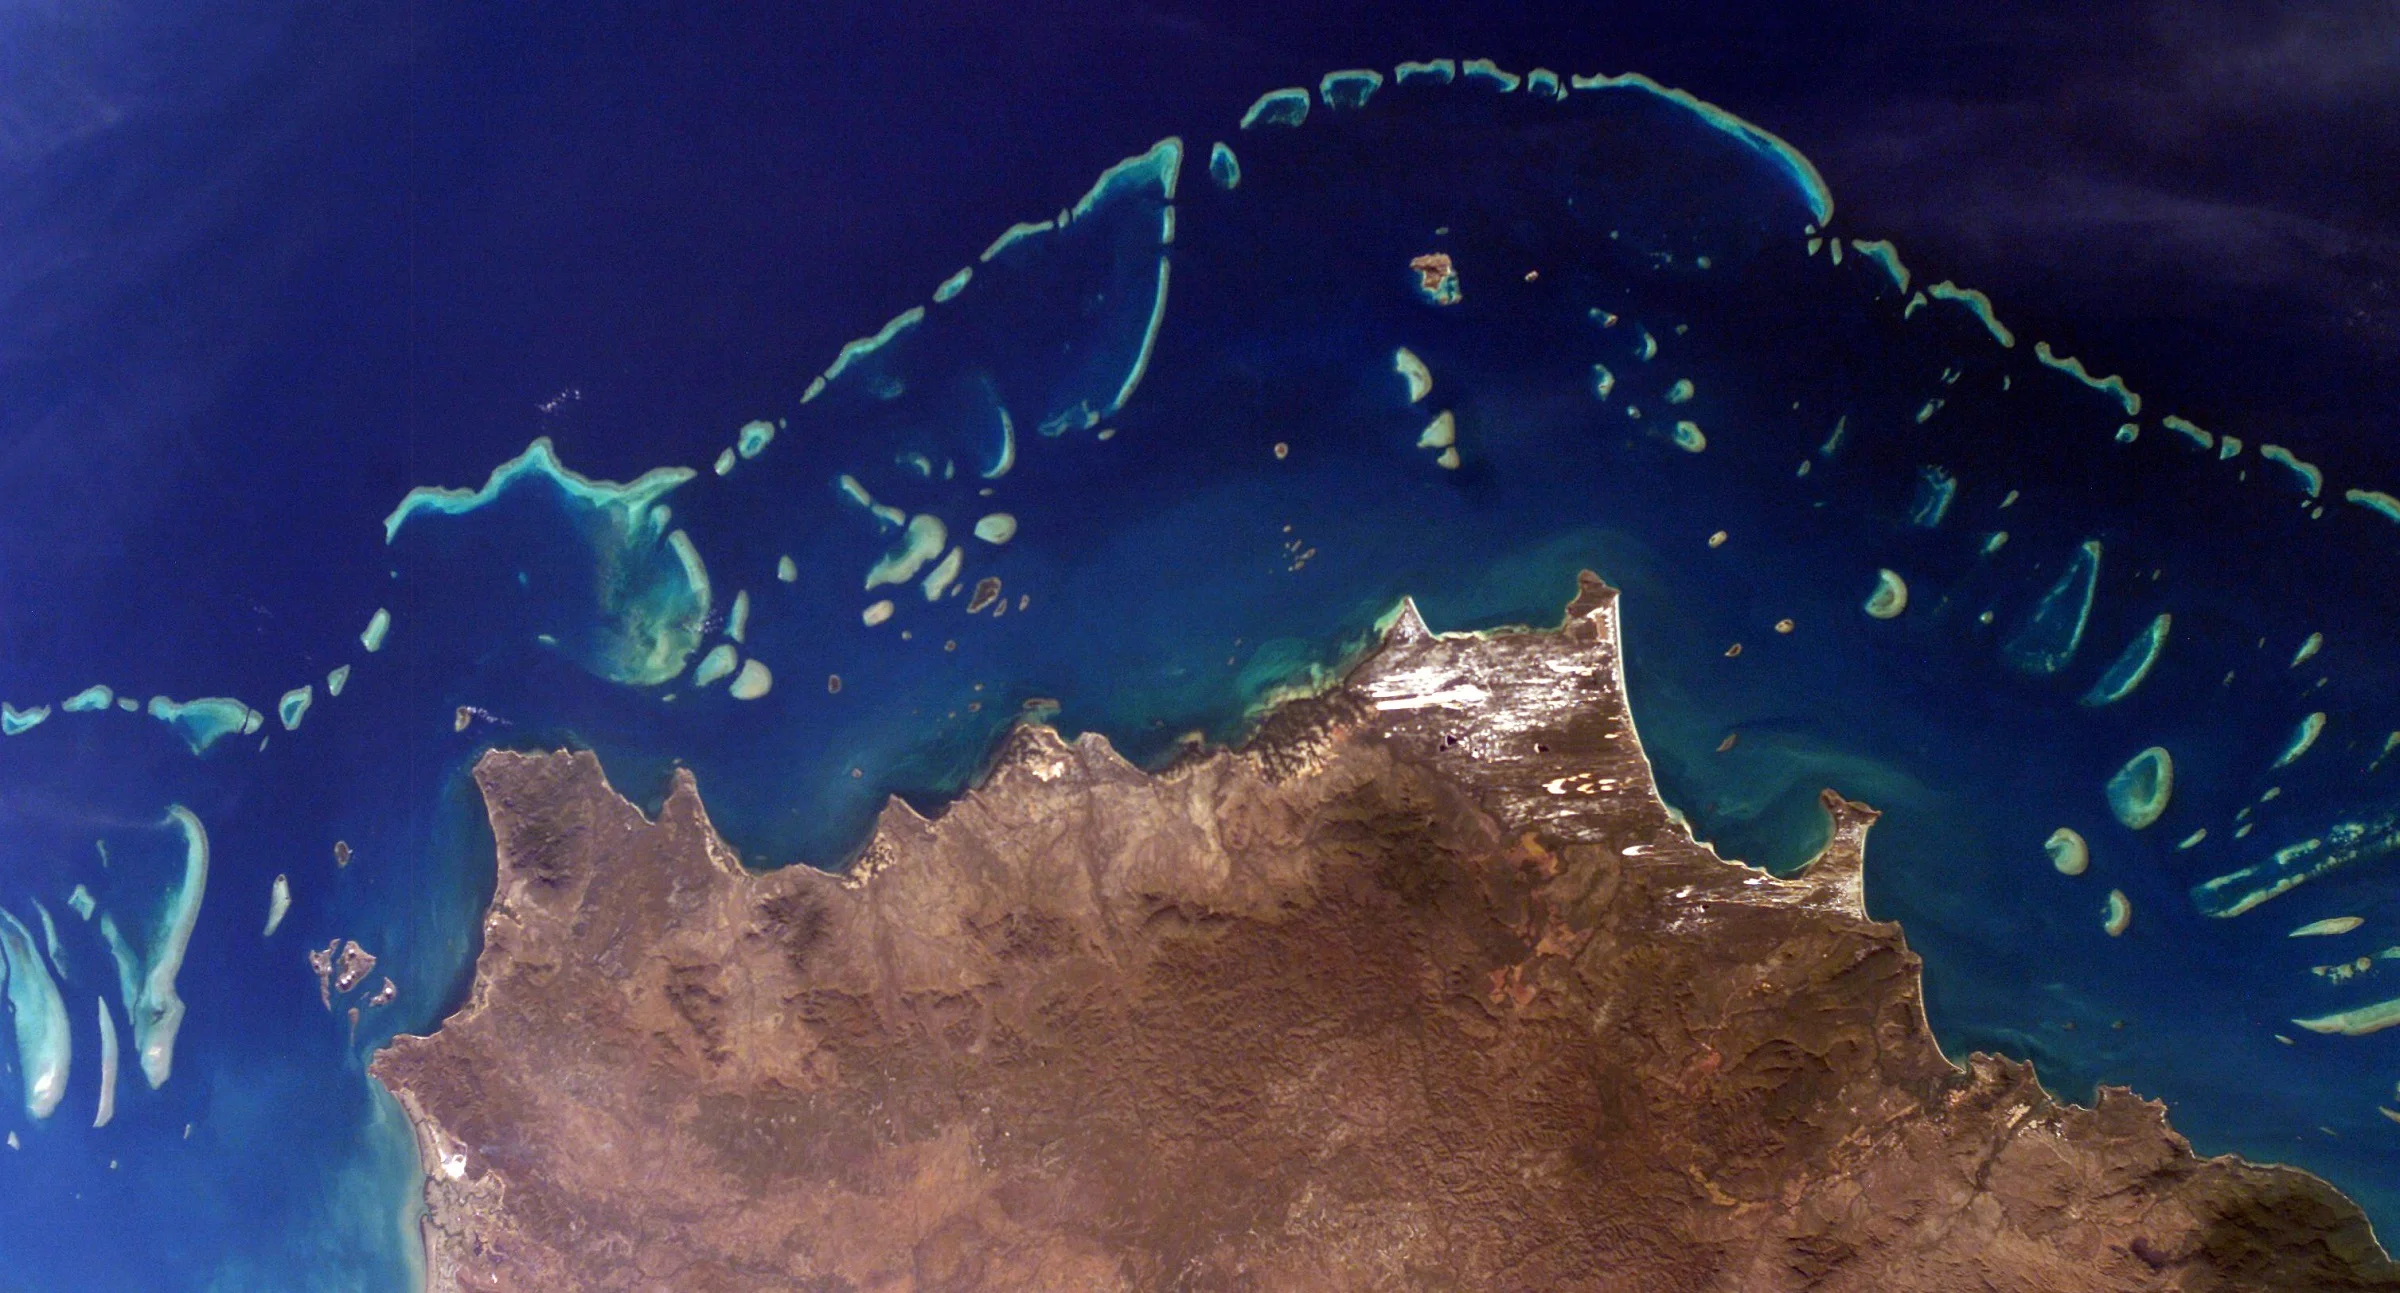

# Getting Started

This setup installs essential libraries for geospatial and remote sensing workflows. requests allows you to download data from online APIs, while shapely provides tools for manipulating geometric shapes like polygons and points. rasterio handles raster data such as satellite imagery, and fiona enables reading vector files like shapefiles or GeoPackages. CodeCarbon will allow us to track emissions for our most computationally heavy tasks, such as model training. Finally, tqdm adds progress bars to loops, making long-running tasks easier to track.

In [1]:
# ---------------------- Install Dependencies ----------------------
!pip -q install requests shapely rasterio tqdm fiona codecarbon

Mount your Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Retreival

Now we will read in some useful functions for obtaining our Sentinel-2 data. Once the functions have been read in you will be prompted to input your Copernicus Data Space Ecosystem username and password.

In [5]:
# ------------------------- 1. Imports ------------------------------
import os, zipfile, requests, warnings
import numpy as np, pandas as pd, rasterio
from shapely.geometry import Polygon
from tqdm.notebook import tqdm
warnings.filterwarnings("ignore", category=rasterio.errors.NotGeoreferencedWarning)

# ---------------------- 2. Credentials -----------------------------
from getpass import getpass
username = input("Copernicus username: ")
password = getpass("Copernicus password: ")

# ------------------ 3. Copernicus token helpers --------------------
def get_tokens(user, pwd):
    url  = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
    data = {"grant_type":"password","username":user,"password":pwd,"client_id":"cdse-public"}
    return requests.post(url, data=data, timeout=60).json()

def refresh_atoken(rtoken):
    url  = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
    data = {"grant_type":"refresh_token","refresh_token":rtoken,"client_id":"cdse-public"}
    return requests.post(url, data=data, timeout=60).json()

tokens = get_tokens(username, password)
atok, rtok = tokens["access_token"], tokens["refresh_token"]

def api_call(url, method="GET"):
    global atok, rtok
    hdr = {"Authorization": f"Bearer {atok}"}
    r   = requests.request(method, url, headers=hdr, timeout=120)
    if r.status_code in (401,403):
        new = refresh_atoken(rtok)
        atok = new["access_token"]
        rtok = new.get("refresh_token", rtok)
        hdr  = {"Authorization": f"Bearer {atok}"}
        r    = requests.request(method, url, headers=hdr, timeout=120)
    r.raise_for_status()
    return r

# ---------- 4. Query Sentinel-2 MSI L2A scenes -------------
def query_s2(start, end, wkt, max_items=100, max_cloud_pct=1):
    # 1) remove extra space in WKT to match "POLYGON((...))" syntax
    wkt_clean = wkt.replace("POLYGON ((", "POLYGON((").replace("))", "))")

    # 2) build all clauses, using 'cloudCover' attribute
    clauses = [
        "Collection/Name eq 'SENTINEL-2'",
        "Attributes/OData.CSC.StringAttribute/any(att:att/Name eq 'productType' and att/Value eq 'S2MSI2A')",
        f"Attributes/OData.CSC.DoubleAttribute/any(att:att/Name eq 'cloudCover' and att/Value lt {max_cloud_pct})",
        f"ContentDate/Start gt {start}T00:00:00.000Z",
        f"ContentDate/Start lt {end}T23:59:59.999Z",
        f"OData.CSC.Intersects(area=geography'SRID=4326;{wkt_clean}')"
    ]
    filter_str = " and ".join(clauses)

    # 3) quote the whole filter once
    url = (
        "https://catalogue.dataspace.copernicus.eu/odata/v1/Products"
        f"?$filter={requests.utils.quote(filter_str)}"
        f"&$top={max_items}"
    )

    rows, next_url = [], url
    while next_url:
        js = api_call(next_url).json()
        rows.extend(js["value"])
        next_url = js.get("@odata.nextLink")
    return pd.DataFrame(rows)

# ------------------ 5. Download & extract ----------------------------
DL_DIR = "s2_tiles"
os.makedirs(DL_DIR, exist_ok=True)

def download_and_extract(pid, name, out_base=DL_DIR):
    zip_path = os.path.join(out_base, f"{name}.zip")
    folder   = os.path.join(out_base, name)
    if not os.path.isdir(folder):
        # download
        url = f"https://zipper.dataspace.copernicus.eu/odata/v1/Products({pid})/$value"
        with api_call(url, "GET") as r, open(zip_path, "wb") as f:
            for chunk in r.iter_content(256_000):
                f.write(chunk)
        # unzip
        with zipfile.ZipFile(zip_path, "r") as z:
            z.extractall(folder)
    return folder

# --------- 6. Load & save only 10 m bands per tile ----------
def save_10m_bands(tile_folder, bands=("B02","B03","B04","B08")):
    out_numpy = {}
    for root, _, files in os.walk(tile_folder):
        for f in files:
            for b in bands:
                if f.endswith(f"{b}_10m.jp2"):
                    with rasterio.open(os.path.join(root, f)) as src:
                        arr = src.read(1).astype("float32") / 10000.0
                    out_numpy[b] = arr
    for b, arr in out_numpy.items():
        np.save(os.path.join(tile_folder, f"{b}_10m.npy"), arr)
        del arr
    print(f"Saved bands {list(out_numpy)} for {os.path.basename(tile_folder)}")

Copernicus username: jonomclennan@gmail.com
Copernicus password: ··········


With our functions read in we are now ready to extract some data.

This code below will download two adjacent, nearly cloudless tiles between the specified dates. This approach facilitates the most precise classification of our reefs, and allows us to roll our our model on untrained areas without worrying about factors like differing solar zenith angle between observations.

We focus on the four 10 m Sentinel-2 bands: blue, green, red, and near-infrared (NIR). These provide the ideal spectral combination for reef classification—blue and green penetrate shallow water to reveal reef flats and lagoons, while red and NIR help distinguish land, vegetation, and benthic cover. Together, they enable both water masking (e.g., via NDWI) and geomorphic feature detection, all while maintaining high spatial detail.

In [9]:
# ---------------------- 6. Define two reef ROIs & date window ----------------------
from shapely.geometry import Polygon
import os
from tqdm.notebook import tqdm

reef_rois = {
    "reef_loc1": Polygon([
        (145.50, -14.82),
        (145.50, -14.84),
        (145.52, -14.84),
        (145.52, -14.82),
    ]).wkt,
    "reef_loc2": Polygon([
        (145.55, -15.80),
        (145.55, -15.82),
        (145.57, -15.82),
        (145.57, -15.80),
    ]).wkt,
}
start_date, end_date = "2019-02-01", "2019-04-30"  # bleaching period
DL_DIR = "s2_tiles"
os.makedirs(DL_DIR, exist_ok=True)

# ---------------------- 7. Query 2 scenes per ROI, pick unique ----------------------
df_list = []
used_names = set()

for loc_name, wkt in reef_rois.items():
    # fetch the first 2 low-cloud scenes for this ROI
    candidates = query_s2(start_date, end_date, wkt, max_cloud_pct=1, max_items=2)
    # pick the first one whose Name we haven't used yet
    for _, row in candidates.iterrows():
        if row["Name"] not in used_names:
            used_names.add(row["Name"])
            row["Location"] = loc_name
            df_list.append(row)
            break
    else:
        raise RuntimeError(f"No unique low-cloud tile found for {loc_name}")

df_tiles = pd.DataFrame(df_list)
print(f"Processing {len(df_tiles)} distinct tiles with <1% cloud…")

# ---------------------- 8. Download, extract & save 10m bands ----------------------
for _, row in tqdm(df_tiles.iterrows(), total=len(df_tiles), desc="Tiles"):
    pid, name = row["Id"], row["Name"]
    tile_folder = download_and_extract(pid, name, out_base=DL_DIR)
    save_10m_bands(tile_folder)

print("Done: two unique low-cloud tiles downloaded and saved.")

Processing 2 distinct tiles with <1% cloud…


Tiles:   0%|          | 0/2 [00:00<?, ?it/s]

Saved bands ['B08', 'B03', 'B02', 'B04'] for S2B_MSIL2A_20190211T003709_N0500_R059_T55LCD_20221214T103040.SAFE
Saved bands ['B08', 'B04', 'B03', 'B02'] for S2B_MSIL2A_20190211T003709_N0500_R059_T55LCC_20221214T103040.SAFE
Done: two unique low-cloud tiles downloaded and saved.


Now we will combine the blue, green and red bands to produce a true colour image of our two tiles for a quick visual inspection.

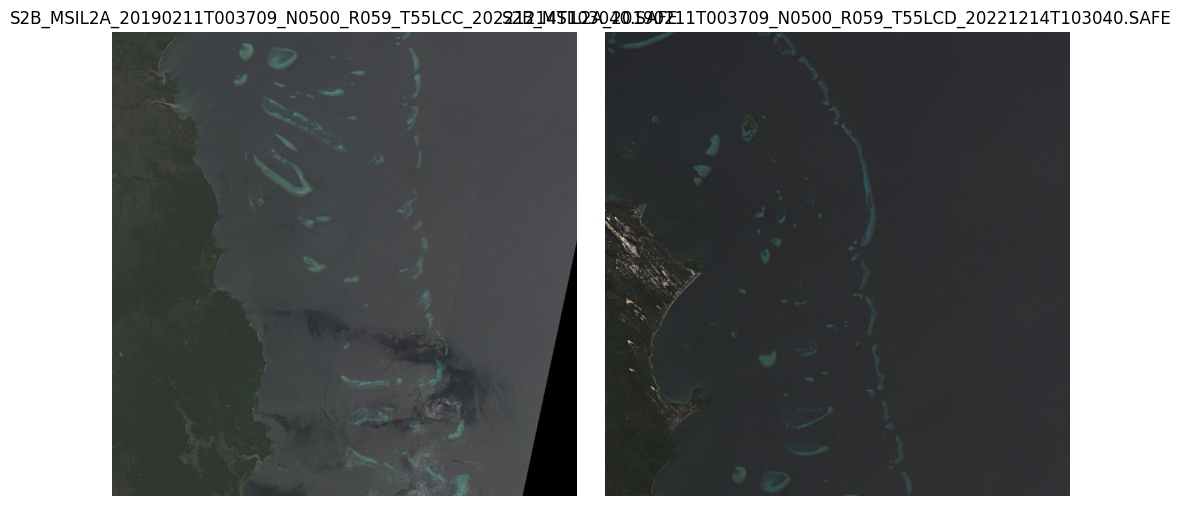

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

def display_tile_rgb(tile_path, scale=0.1, vmax=None):
    """
    Load Sentinel-2 bands B04 (red), B03 (green), B02 (blue) via memory-map,
    downsample by `scale`, normalize, and plot.

    Parameters
    ----------
    tile_path : str
        Path to the .SAFE folder containing B02_10m.npy, B03_10m.npy, B04_10m.npy
    scale : float
        Fraction of pixels to keep in each direction (e.g. 0.1 = 10% → 1/10th resolution)
    vmax : int or None
        Optional upper clip value for reflectance (if you know the data range,
        e.g. 10000); if None, auto-scale from min–max.
    """
    # memory-map the three bands
    blue  = np.load(os.path.join(tile_path, 'B02_10m.npy'), mmap_mode='r')
    green = np.load(os.path.join(tile_path, 'B03_10m.npy'), mmap_mode='r')
    red   = np.load(os.path.join(tile_path, 'B04_10m.npy'), mmap_mode='r')

    # compute integer step so we keep roughly `scale*100%` of pixels
    step = max(1, int(1/scale))

    # slice every `step`th pixel in each axis
    red_ds   = red[::step, ::step]
    green_ds = green[::step, ::step]
    blue_ds  = blue[::step, ::step]

    # stack into H×W×3 (RGB order)
    rgb = np.dstack((red_ds, green_ds, blue_ds)).astype(np.float32)

    # optional clipping for extreme values
    if vmax is not None:
        rgb = np.clip(rgb, 0, vmax)

    # normalize to [0,1]
    mn, mx = rgb.min(), rgb.max()
    rgb = (rgb - mn) / (mx - mn + 1e-6)

    # plot
    plt.imshow(rgb)
    plt.title(os.path.basename(tile_path))
    plt.axis('off')


if __name__ == '__main__':
    # list your two SAFE folders here
    tiles = [
        '/content/s2_tiles/S2B_MSIL2A_20190211T003709_N0500_R059_T55LCC_20221214T103040.SAFE',
        '/content/s2_tiles/S2B_MSIL2A_20190211T003709_N0500_R059_T55LCD_20221214T103040.SAFE',
    ]

    # make a figure with one subplot per tile
    plt.figure(figsize=(10, 5))
    for i, t in enumerate(tiles, 1):
        plt.subplot(1, len(tiles), i)
        display_tile_rgb(t, scale=0.1, vmax=10000)
    plt.tight_layout()
    plt.show()

# Creating a Baseline using NDWI:

With our data downloaded, one of the simplest ways to pop out our reefs is by using the Normalised Difference Water Index or NDWI 1996 by S.K. McFeeters. It is calculated for each pixel as follows:

$$
\mathrm{NDWI} = \frac{G - \mathrm{NIR}}{G + \mathrm{NIR}}
$$

Here G is the green band value, with NIR being the Near Infrared band, corresponding respectively to B03 and B08 in our code. We have chosen our reef mask to be any pixel which fits the requirement:

$$
0.1 < \mathrm{NDWI} < 0.5
$$

NDWI values above 0.5 typically indicate deep or open water, where NIR reflectance is strongly absorbed due to water’s high attenuation in the near-infrared, while the green band reflects moderately. This yields a large numerator in the NDWI formula, pushing values upward.

Conversely, land and dry reef surfaces tend to reflect strongly in both green and NIR, especially over vegetation or bare rock, reducing the contrast between the two bands and lowering the NDWI.

NDWI masks for both tiles are calculated and plotted below:

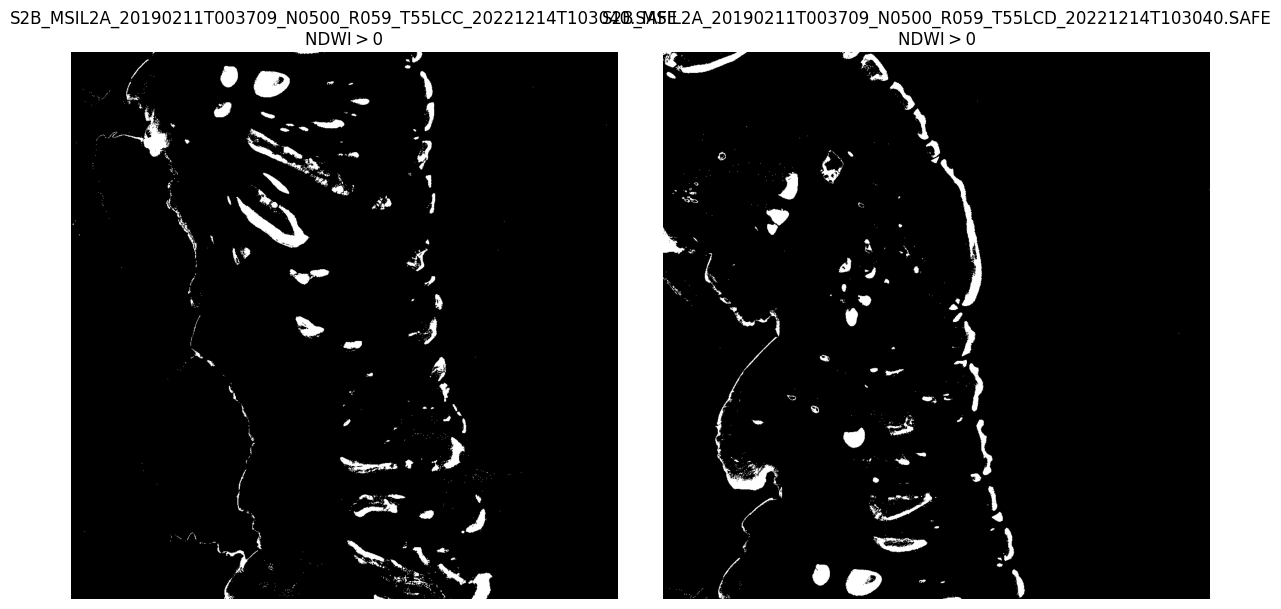

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import gc

# — your two SAFE directories —
tile_dirs = [
    Path("/content/s2_tiles/S2B_MSIL2A_20190211T003709_N0500_R059_T55LCC_20221214T103040.SAFE"),
    Path("/content/s2_tiles/S2B_MSIL2A_20190211T003709_N0500_R059_T55LCD_20221214T103040.SAFE"),
]

# all bands filenames
bands = {
    "blue": "B02_10m.npy",
    "green": "B03_10m.npy",
    "red": "B04_10m.npy",
    "nir": "B08_10m.npy",
}

# Phase 1: determine the downsampled (every-10th) shape for each tile
ds_shapes = []
for td in tile_dirs:
    mm = np.load(td / bands["blue"], mmap_mode="r")
    h, w = mm.shape
    ds_shapes.append(((h + 9)//10, (w + 9)//10))
    del mm

# common downsampled size
h_ds, w_ds = map(min, zip(*ds_shapes))

# Phase 2: load, slice, compute NDWI mask, plot, cleanup
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for ax, td in zip(axes, tile_dirs):
    # mmap each band
    mmaps = {name: np.load(td / fname, mmap_mode="r") for name, fname in bands.items()}

    # slice + downsample: take rows 0…h_ds*10 stepping 10, same for cols
    slices = {
        name: mm[:h_ds*10:10, :w_ds*10:10].astype(np.float32)
        for name, mm in mmaps.items()
    }

    # compute NDWI = (green - nir) / (green + nir)
    g = slices["green"]
    nir = slices["nir"]
    ndwi = (g - nir) / (g + nir + 1e-6)
    mask = (ndwi >= 0.1) & (ndwi <= 0.5)

    ax.imshow(mask, cmap="gray")
    ax.set_title(f"{td.name}\nNDWI > 0")
    ax.axis("off")

    # tidy up
    del mmaps, slices, g, nir, ndwi, mask
    gc.collect()

plt.tight_layout()
plt.show()

# Creating Training Data for our CNN

Now that we've downloaded our Sentinel-2 tiles, we stack the relevant 10 m bands (B02, B03, B04, B08) into 4-channel image cubes for each scene, ready for analysis and model input.

In [2]:
# === Stack and save cubes for both tiles with custom names ===
import os
import numpy as np

# 1. Point this to where your tiles live
base_dir = "s2_tiles"

# 2. Discover the two tile folders
tile_dirs = sorted([
    d for d in os.listdir(base_dir)
    if os.path.isdir(os.path.join(base_dir, d))
])[:2]

# 3. Specify the 10 m bands you want to stack
bands = ["B02", "B03", "B04", "B08"]

# 4. Loop over each tile, load, stack, and save with specific names
for tile in tile_dirs:
    tile_path = os.path.join(base_dir, tile)
    arrays = []
    for b in bands:
        fn = os.path.join(tile_path, f"{b}_10m.npy")
        arr = np.load(fn)            # shape H×W
        arrays.append(arr)
    cube = np.stack(arrays, axis=-1)  # shape H×W×4
    print(f"{tile}: stacked cube shape = {cube.shape}")

    # 5. Determine output filename
    if "T55LCC" in tile:
        out_name = "stacked_cube_gen.npy"
    else:
        out_name = "stacked_cube.npy"

    # 6. Save locally
    out_local = os.path.join(base_dir, out_name)
    np.save(out_local, cube)

    # 7. Also save to your Drive folder
    out_drive = os.path.expanduser(
        f"~/MyDrive/AI4EO/Final_Project/{out_name}"
    )
    os.makedirs(os.path.dirname(out_drive), exist_ok=True)
    np.save(out_drive, cube)

print("Done: stacked_cube and stacked_cube_gen saved.")

S2B_MSIL2A_20190211T003709_N0500_R059_T55LCC_20221214T103040.SAFE: stacked cube shape = (10980, 10980, 4)
S2B_MSIL2A_20190211T003709_N0500_R059_T55LCD_20221214T103040.SAFE: stacked cube shape = (10980, 10980, 4)
Done: stacked_cube and stacked_cube_gen saved.


Now we will start working on creating training data for IRIS - This snippet lets us zoom in on specific regions in our training tile so that we can extract interesting regions for training

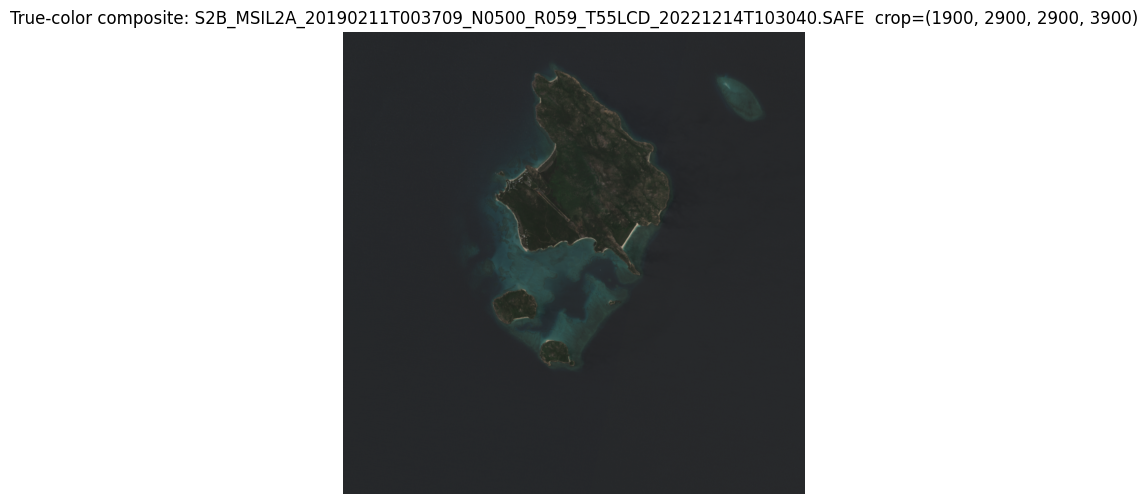

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt

def plot_truecolor(tile_path, crop_window=None, vmin=0, vmax=1.0):
    """
    Plot a true‐color composite from a Sentinel‐2 tile folder, optionally cropped.

    Args:
      tile_path (str): path to the .SAFE folder containing B02_10m.npy … B08_10m.npy
      crop_window (tuple or None): (y0, y1, x0, x1) pixel indices to crop to
      vmin, vmax (float): display stretch
    """
    # load bands
    b2 = np.load(os.path.join(tile_path, "B02_10m.npy"))
    b3 = np.load(os.path.join(tile_path, "B03_10m.npy"))
    b4 = np.load(os.path.join(tile_path, "B04_10m.npy"))

    # stack to RGB
    rgb = np.dstack([b4, b3, b2])

    # apply crop if requested
    if crop_window is not None:
        y0, y1, x0, x1 = crop_window
        rgb = rgb[y0:y1, x0:x1]

    # plot
    plt.figure(figsize=(6, 6))
    plt.imshow(rgb, vmin=vmin, vmax=vmax)
    plt.axis("off")
    title = os.path.basename(tile_path)
    if crop_window:
        title += f"  crop={crop_window}"
    plt.title(f"True‐color composite: {title}")
    plt.show()


# ------------------ USAGE ------------------

# 1) point to your base dir & pick a tile
base_dir = "s2_tiles"
tiles = [d for d in os.listdir(base_dir)
         if os.path.isdir(os.path.join(base_dir, d))]
tile = tiles[0]   # or change index
tile_path = os.path.join(base_dir, tile)

# 2) set your crop window here (y0, y1, x0, x1), or None for full image
#    tweak these values to zoom in/out and trial different ROIs
crop_window = 1900, 2900, 2900, 3900

# 3) call the plot function
plot_truecolor(tile_path, crop_window=crop_window, vmin=0, vmax=0.2)

Save your identified interesting regions as .npy files in a local folder and proceed to training with IRIS.

In [ ]:
import numpy as np

# 1) load the full cube in memory-mapped mode
cube = np.load('/content/drive/MyDrive/AI4EO/Final_Project/stacked_cube.npy', mmap_mode='r')
h, w, b = cube.shape
print("Full cube:", cube.shape)

# 2) define your crop box (row_min, row_max, col_min, col_max)
#r0, r1, c0, c1 = 1900, 2900, 2900, 3900 ### Lizard Island location         ###
#r0, r1, c0, c1 = 3300, 4300, 200, 1200  ### Shallow Coastal Water location ###
#r0, r1, c0, c1 = 1500, 2500, 5000, 6000 ### Horseshoe Reef location        ###
#r0, r1, c0, c1 = 7500, 8500, 3500, 4500 ### Forraster Reef                 ###
#r0, r1, c0, c1 = 7000, 8000, 1000, 2000 ### Micivor River opening          ###
#r0, r1, c0, c1 = 2500, 3500, 2000, 3000 ### Eyrie and Martin Reef          ###
#r0, r1, c0, c1 = 9000, 10000, 9000, 10000

# 3) slice out the sub-cube
sub = cube[r0:r1, c0:c1, :]      # shape will be (r1-r0, c1-c0, 4)
print("Sub-cube:", sub.shape)

# 4) save that smaller chunk
np.save('/content/s2_tiles/reefimage6.npy', sub)
print("Wrote reefimage.npy")

Full cube: (10980, 10980, 4)
Sub-cube: (1000, 1000, 4)
Wrote reefimage.npy


Below is an example mask for Lizard Island created in IRIS, one of the regions of interest chosen for training. Blue regions are shallow sand, yellow is deep water, red is land and white are reef flats and lagoons, another class not shown here is sediment/turbid sand, which runs off the coastal areas of the great barrier reef. Once your masks are complete, upload them with your configuration file to your google drive and proceed with creating balanced training data.

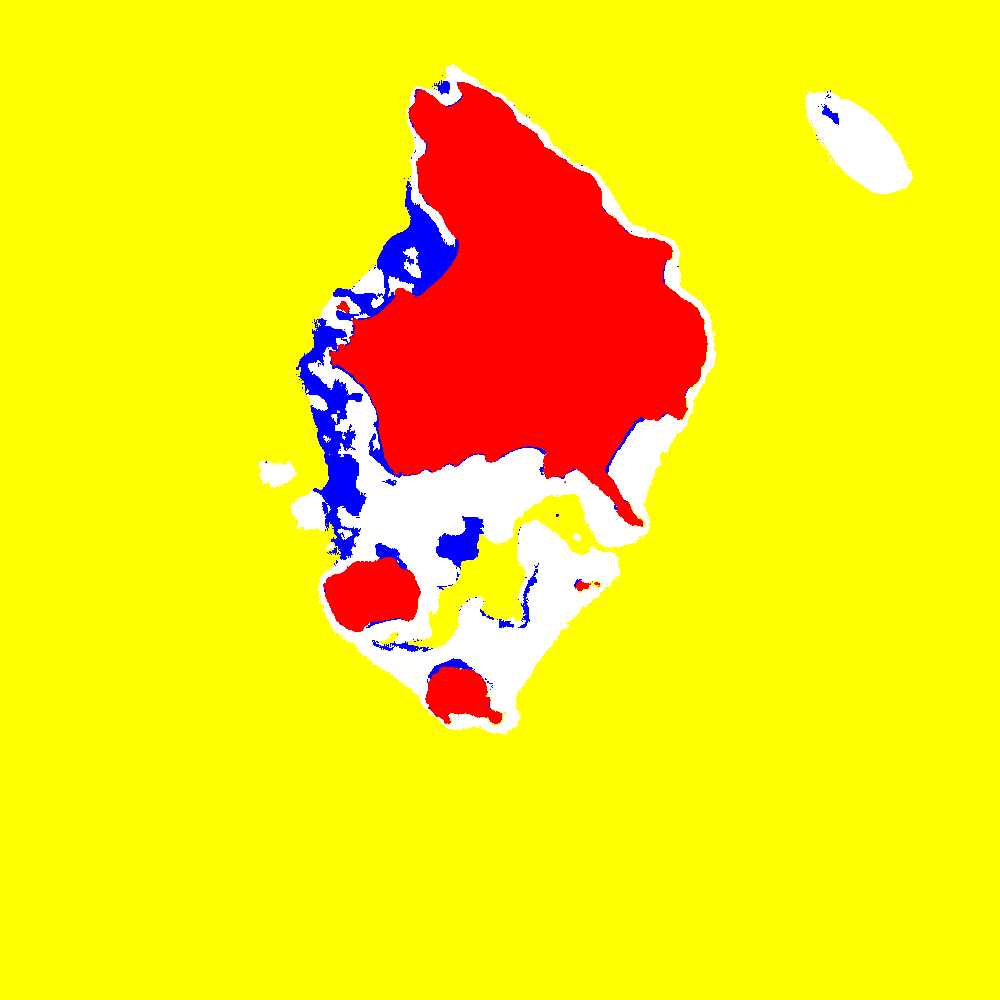

We now extract balanced training and testing datasets by sampling fixed-size image patches (11x11) from labeled reef regions, using memmaps for efficiency and stratified splitting to preserve class distribution.

In [ ]:
import os
import numpy as np
import cv2
import json
from sklearn.model_selection import train_test_split

# ─── Configuration ────────────────────────────────────────────────────────────
IMAGE_PATH  = '/content/drive/MyDrive/AI4EO/Final_Project/stacked_cube.npy'
MASK_PATHS  = {
    'l': '/content/drive/MyDrive/AI4EO/Final_Project/Masks/mask0.png',
    'c': '/content/drive/MyDrive/AI4EO/Final_Project/Masks/mask1.png',
    'b': '/content/drive/MyDrive/AI4EO/Final_Project/Masks/mask2.png',
    'd': '/content/drive/MyDrive/AI4EO/Final_Project/Masks/mask3.png',
    'e': '/content/drive/MyDrive/AI4EO/Final_Project/Masks/mask4.png',
}
BBOX        = {
    'l': (2900, 1900, 3900, 2900),
    'c': (5000, 1500, 6000, 2500),
    'b': (3500, 7500, 4500, 8500),
    'd': (1000, 7000, 2000, 8000),
    'e': ( 200, 3300, 1200, 4300),
}
CONFIG_PATH = '/content/drive/MyDrive/AI4EO/Final_Project/config_reef.json'
OUT_DIR     = '/content/drive/MyDrive/AI4EO/Final_Project/TrainingData/test_run'
PATCH_SIZE  = 11
OFFSET      = PATCH_SIZE // 2
TEST_SIZE   = 0.1

os.makedirs(OUT_DIR, exist_ok=True)

# ─── Helpers ───────────────────────────────────────────────────────────────────
cube = np.load(IMAGE_PATH)  # (H, W, 4)

with open(CONFIG_PATH) as f:
    cfg = json.load(f)
classes    = cfg['classes']
colour2idx = {tuple(c['colour'][:3]): i for i, c in enumerate(classes)}

def rgb_to_labels(mask_rgb):
    h, w = mask_rgb.shape[:2]
    lbl  = np.zeros((h, w), dtype=np.int8)
    for rgb, idx in colour2idx.items():
        lbl[np.all(mask_rgb[..., :3] == rgb, axis=-1)] = idx
    return lbl

# ─── PASS 1: count total patches & per-class population ───────────────────────
total_patches = 0
class_counts  = np.zeros(len(classes), dtype=np.int64)

for cid, mask_path in MASK_PATHS.items():
    x0, y0, x1, y1 = BBOX[cid]
    roi_h, roi_w  = (y1 - y0), (x1 - x0)
    if roi_h < PATCH_SIZE or roi_w < PATCH_SIZE:
        raise ValueError(f"ROI {cid} too small for {PATCH_SIZE}")

    n_patches = (roi_h - 2*OFFSET) * (roi_w - 2*OFFSET)
    total_patches += n_patches

    mask_bgr  = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
    mask_rgb  = cv2.cvtColor(mask_bgr, cv2.COLOR_BGR2RGB)
    lbl2d     = rgb_to_labels(mask_rgb)
    valid     = lbl2d[OFFSET:roi_h-OFFSET, OFFSET:roi_w-OFFSET].ravel()
    uniq, cnt = np.unique(valid, return_counts=True)
    class_counts[uniq] += cnt

min_count = class_counts.min()

# ─── PASS 2: write to memmap & reservoir‐sample per class ────────────────────
X_all = np.memmap(
    os.path.join(OUT_DIR, f'X{PATCH_SIZE}_all.dat'),
    dtype=cube.dtype, mode='w+',
    shape=(total_patches, PATCH_SIZE, PATCH_SIZE, cube.shape[2])
)
y_all = np.memmap(
    os.path.join(OUT_DIR,      'y_all.dat'),
    dtype=np.int8,  mode='w+',
    shape=(total_patches,)
)

reservoir = {cls: [] for cls in range(len(classes))}
seen      = np.zeros(len(classes), dtype=np.int64)

idx = 0
for cid, mask_path in MASK_PATHS.items():
    x0, y0, x1, y1 = BBOX[cid]
    roi            = cube[y0:y1, x0:x1, :]
    h, w           = roi.shape[:2]

    mask_bgr = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
    mask_rgb = cv2.cvtColor(mask_bgr, cv2.COLOR_BGR2RGB)
    lbl2d    = rgb_to_labels(mask_rgb)

    for i in range(OFFSET, h - OFFSET):
        for j in range(OFFSET, w - OFFSET):
            patch = roi[i-OFFSET : i+OFFSET+1, j-OFFSET : j+OFFSET+1, :]
            cls   = int(lbl2d[i, j])

            X_all[idx] = patch
            y_all[idx] = cls

            seen[cls] += 1
            if len(reservoir[cls]) < min_count:
                reservoir[cls].append(idx)
            else:
                r = np.random.randint(seen[cls])
                if r < min_count:
                    reservoir[cls][r] = idx

            idx += 1

bal_indices = np.concatenate([np.array(reservoir[c]) for c in range(len(classes))])

# ─── PASS 3: stratified split & write final .npy files ──────────────────────
y_bal = y_all[bal_indices]
train_pos, test_pos = train_test_split(
    np.arange(len(bal_indices)),
    test_size=TEST_SIZE,
    stratify=y_bal
)

n_train = len(train_pos)
n_test  = len(test_pos)

X_train = np.memmap(
    os.path.join(OUT_DIR, f'X{PATCH_SIZE}_train.dat'),
    dtype=cube.dtype, mode='w+',
    shape=(n_train, PATCH_SIZE, PATCH_SIZE, cube.shape[2])
)
y_train = np.memmap(
    os.path.join(OUT_DIR,       'y_train.dat'),
    dtype=np.int8,  mode='w+',
    shape=(n_train,)
)
X_test  = np.memmap(
    os.path.join(OUT_DIR, f'X{PATCH_SIZE}_test.dat'),
    dtype=cube.dtype, mode='w+',
    shape=(n_test, PATCH_SIZE, PATCH_SIZE, cube.shape[2])
)
y_test  = np.memmap(
    os.path.join(OUT_DIR,      'y_test.dat'),
    dtype=np.int8,  mode='w+',
    shape=(n_test,)
)

for out_idx, src in enumerate(train_pos):
    real_idx        = bal_indices[src]
    X_train[out_idx] = X_all[real_idx]
    y_train[out_idx] = y_all[real_idx]

for out_idx, src in enumerate(test_pos):
    real_idx       = bal_indices[src]
    X_test[out_idx] = X_all[real_idx]
    y_test[out_idx] = y_all[real_idx]

# save as .npy for compatibility
np.save(os.path.join(OUT_DIR, f'X{PATCH_SIZE}_train.npy'), np.array(X_train))
np.save(os.path.join(OUT_DIR, f'X{PATCH_SIZE}_test.npy'),  np.array(X_test))
np.save(os.path.join(OUT_DIR,              'y_train.npy'), np.array(y_train))
np.save(os.path.join(OUT_DIR,              'y_test.npy'),  np.array(y_test))

print(f"Done—extracted {PATCH_SIZE}×{PATCH_SIZE} patches ({n_train} train, {n_test} test) into {OUT_DIR}")

Done—extracted 11×11 patches (404811 train, 44979 test) into /content/drive/MyDrive/AI4EO/Final_Project/TrainingData/test_run


# Training Our CNN

We now train a convolutional neural network on the extracted patch data, using an appended NDWI channel to enhance spectral sensitivity, class weighting to address imbalance, and early stopping to prevent overfitting. As this is by far the most computationally heavy task, we track our emissions using the CodeCarbon package.

Data shapes: X_train=(404811, 11, 11, 4), X_test=(44979, 11, 11, 4), y_train=(404811,), y_test=(44979,)
Class weight dict: {0: np.float64(2.0000049405894123), 1: np.float64(1.0000024702947061), 2: np.float64(1.0000024702947061), 3: np.float64(1.0000024702947061), 4: np.float64(1.999980237886442)}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 11, 11, 32)     │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 11, 11, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 11, 11, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 11, 11, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 5, 5, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 5, 5, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 5, 5, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 5, 5, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,877 (296.39 KB)

 Trainable params: 75,493 (294.89 KB)

 Non-trainable params: 384 (1.50 KB)

[codecarbon WARNING @ 20:25:02] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 20:25:02] [setup] RAM Tracking...
[codecarbon INFO @ 20:25:02] [setup] CPU Tracking...
[codecarbon WARNING @ 20:25:03] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 20:25:03] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 20:25:03] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 20:25:03] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 20:25:03] [setup] GPU Tracking...
[codecarbon INFO @ 20:25:03] No GPU found.
[codecarbon INFO @ 20:25:03] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

Epoch 1/50
  76/2847 ━━━━━━━━━━━━━━━━━━━━ 5:30 119ms/step - accuracy: 0.7120 - loss: 1.0342

[codecarbon INFO @ 20:25:18] Energy consumed for RAM : 0.000042 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:25:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:25:18] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 20:25:18] 0.000219 kWh of electricity used since the beginning.


 215/2847 ━━━━━━━━━━━━━━━━━━━━ 4:54 112ms/step - accuracy: 0.8019 - loss: 0.7484

[codecarbon INFO @ 20:25:33] Energy consumed for RAM : 0.000083 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:25:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:25:33] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 20:25:33] 0.000437 kWh of electricity used since the beginning.


 357/2847 ━━━━━━━━━━━━━━━━━━━━ 4:32 109ms/step - accuracy: 0.8325 - loss: 0.6464

[codecarbon INFO @ 20:25:48] Energy consumed for RAM : 0.000125 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:25:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:25:48] Energy consumed for All CPU : 0.000531 kWh
[codecarbon INFO @ 20:25:48] 0.000656 kWh of electricity used since the beginning.


 503/2847 ━━━━━━━━━━━━━━━━━━━━ 4:12 108ms/step - accuracy: 0.8494 - loss: 0.5888

[codecarbon INFO @ 20:26:03] Energy consumed for RAM : 0.000167 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:26:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:26:03] Energy consumed for All CPU : 0.000708 kWh
[codecarbon INFO @ 20:26:03] 0.000875 kWh of electricity used since the beginning.


 644/2847 ━━━━━━━━━━━━━━━━━━━━ 3:56 107ms/step - accuracy: 0.8599 - loss: 0.5512

[codecarbon INFO @ 20:26:18] Energy consumed for RAM : 0.000208 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:26:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:26:18] Energy consumed for All CPU : 0.000886 kWh
[codecarbon INFO @ 20:26:18] 0.001094 kWh of electricity used since the beginning.


 786/2847 ━━━━━━━━━━━━━━━━━━━━ 3:40 107ms/step - accuracy: 0.8677 - loss: 0.5226

[codecarbon INFO @ 20:26:33] Energy consumed for RAM : 0.000250 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:26:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:26:33] Energy consumed for All CPU : 0.001063 kWh
[codecarbon INFO @ 20:26:33] 0.001313 kWh of electricity used since the beginning.


 928/2847 ━━━━━━━━━━━━━━━━━━━━ 3:25 107ms/step - accuracy: 0.8739 - loss: 0.4997

[codecarbon INFO @ 20:26:48] Energy consumed for RAM : 0.000292 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:26:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:26:48] Energy consumed for All CPU : 0.001240 kWh
[codecarbon INFO @ 20:26:48] 0.001531 kWh of electricity used since the beginning.


1069/2847 ━━━━━━━━━━━━━━━━━━━━ 3:09 107ms/step - accuracy: 0.8790 - loss: 0.4810

[codecarbon INFO @ 20:27:03] Energy consumed for RAM : 0.000333 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:27:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:27:03] Energy consumed for All CPU : 0.001417 kWh
[codecarbon INFO @ 20:27:03] 0.001750 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:27:03] 0.003185 g.CO2eq/s mean an estimation of 100.45069824180825 kg.CO2eq/year


1210/2847 ━━━━━━━━━━━━━━━━━━━━ 2:54 107ms/step - accuracy: 0.8832 - loss: 0.4651

[codecarbon INFO @ 20:27:18] Energy consumed for RAM : 0.000375 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:27:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:27:18] Energy consumed for All CPU : 0.001594 kWh
[codecarbon INFO @ 20:27:18] 0.001969 kWh of electricity used since the beginning.


1351/2847 ━━━━━━━━━━━━━━━━━━━━ 2:39 107ms/step - accuracy: 0.8869 - loss: 0.4513

[codecarbon INFO @ 20:27:33] Energy consumed for RAM : 0.000417 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:27:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:27:33] Energy consumed for All CPU : 0.001771 kWh
[codecarbon INFO @ 20:27:33] 0.002187 kWh of electricity used since the beginning.


1491/2847 ━━━━━━━━━━━━━━━━━━━━ 2:24 107ms/step - accuracy: 0.8901 - loss: 0.4393

[codecarbon INFO @ 20:27:48] Energy consumed for RAM : 0.000458 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:27:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:27:48] Energy consumed for All CPU : 0.001948 kWh
[codecarbon INFO @ 20:27:48] 0.002406 kWh of electricity used since the beginning.


1640/2847 ━━━━━━━━━━━━━━━━━━━━ 2:08 106ms/step - accuracy: 0.8930 - loss: 0.4280

[codecarbon INFO @ 20:28:03] Energy consumed for RAM : 0.000500 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:28:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:28:03] Energy consumed for All CPU : 0.002125 kWh
[codecarbon INFO @ 20:28:03] 0.002625 kWh of electricity used since the beginning.


1782/2847 ━━━━━━━━━━━━━━━━━━━━ 1:53 106ms/step - accuracy: 0.8956 - loss: 0.4184

[codecarbon INFO @ 20:28:18] Energy consumed for RAM : 0.000542 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:28:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:28:18] Energy consumed for All CPU : 0.002302 kWh
[codecarbon INFO @ 20:28:18] 0.002844 kWh of electricity used since the beginning.


1923/2847 ━━━━━━━━━━━━━━━━━━━━ 1:38 106ms/step - accuracy: 0.8978 - loss: 0.4097

[codecarbon INFO @ 20:28:33] Energy consumed for RAM : 0.000583 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:28:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:28:33] Energy consumed for All CPU : 0.002479 kWh
[codecarbon INFO @ 20:28:33] 0.003062 kWh of electricity used since the beginning.


2062/2847 ━━━━━━━━━━━━━━━━━━━━ 1:23 106ms/step - accuracy: 0.8998 - loss: 0.4020

[codecarbon INFO @ 20:28:48] Energy consumed for RAM : 0.000625 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:28:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W


2063/2847 ━━━━━━━━━━━━━━━━━━━━ 1:23 106ms/step - accuracy: 0.8998 - loss: 0.4019

[codecarbon INFO @ 20:28:48] Energy consumed for All CPU : 0.002656 kWh
[codecarbon INFO @ 20:28:48] 0.003281 kWh of electricity used since the beginning.


2201/2847 ━━━━━━━━━━━━━━━━━━━━ 1:08 106ms/step - accuracy: 0.9017 - loss: 0.3949

[codecarbon INFO @ 20:29:03] Energy consumed for RAM : 0.000666 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:29:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:29:03] Energy consumed for All CPU : 0.002833 kWh
[codecarbon INFO @ 20:29:03] 0.003500 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:29:03] 0.003185 g.CO2eq/s mean an estimation of 100.44816343879097 kg.CO2eq/year


2341/2847 ━━━━━━━━━━━━━━━━━━━━ 53s 106ms/step - accuracy: 0.9034 - loss: 0.3883

[codecarbon INFO @ 20:29:18] Energy consumed for RAM : 0.000708 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:29:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:29:18] Energy consumed for All CPU : 0.003010 kWh
[codecarbon INFO @ 20:29:18] 0.003718 kWh of electricity used since the beginning.


2480/2847 ━━━━━━━━━━━━━━━━━━━━ 39s 106ms/step - accuracy: 0.9050 - loss: 0.3822

[codecarbon INFO @ 20:29:33] Energy consumed for RAM : 0.000750 kWh. RAM Power : 10.0 W


2481/2847 ━━━━━━━━━━━━━━━━━━━━ 38s 106ms/step - accuracy: 0.9050 - loss: 0.3821

[codecarbon INFO @ 20:29:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:29:33] Energy consumed for All CPU : 0.003187 kWh
[codecarbon INFO @ 20:29:33] 0.003937 kWh of electricity used since the beginning.


2622/2847 ━━━━━━━━━━━━━━━━━━━━ 23s 106ms/step - accuracy: 0.9065 - loss: 0.3764

[codecarbon INFO @ 20:29:48] Energy consumed for RAM : 0.000791 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:29:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:29:48] Energy consumed for All CPU : 0.003364 kWh
[codecarbon INFO @ 20:29:48] 0.004156 kWh of electricity used since the beginning.


2761/2847 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - accuracy: 0.9078 - loss: 0.3711

[codecarbon INFO @ 20:30:03] Energy consumed for RAM : 0.000833 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:30:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:30:03] Energy consumed for All CPU : 0.003541 kWh
[codecarbon INFO @ 20:30:03] 0.004374 kWh of electricity used since the beginning.


2846/2847 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9086 - loss: 0.3680

[codecarbon INFO @ 20:30:18] Energy consumed for RAM : 0.000875 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:30:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:30:18] Energy consumed for All CPU : 0.003719 kWh
[codecarbon INFO @ 20:30:18] 0.004593 kWh of electricity used since the beginning.


2847/2847 ━━━━━━━━━━━━━━━━━━━━ 319s 111ms/step - accuracy: 0.9087 - loss: 0.3680 - val_accuracy: 0.8860 - val_loss: 0.3626 - learning_rate: 0.0010
Epoch 2/50
  92/2847 ━━━━━━━━━━━━━━━━━━━━ 4:37 101ms/step - accuracy: 0.9523 - loss: 0.2000

[codecarbon INFO @ 20:30:33] Energy consumed for RAM : 0.000916 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:30:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:30:34] Energy consumed for All CPU : 0.003896 kWh
[codecarbon INFO @ 20:30:34] 0.004812 kWh of electricity used since the beginning.


 227/2847 ━━━━━━━━━━━━━━━━━━━━ 4:40 107ms/step - accuracy: 0.9537 - loss: 0.1939

[codecarbon INFO @ 20:30:49] Energy consumed for RAM : 0.000958 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:30:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:30:49] Energy consumed for All CPU : 0.004073 kWh
[codecarbon INFO @ 20:30:49] 0.005031 kWh of electricity used since the beginning.


 363/2847 ━━━━━━━━━━━━━━━━━━━━ 4:28 108ms/step - accuracy: 0.9542 - loss: 0.1911

[codecarbon INFO @ 20:31:04] Energy consumed for RAM : 0.001000 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:31:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:31:04] Energy consumed for All CPU : 0.004250 kWh
[codecarbon INFO @ 20:31:04] 0.005249 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:31:04] 0.003185 g.CO2eq/s mean an estimation of 100.45118501357199 kg.CO2eq/year


 500/2847 ━━━━━━━━━━━━━━━━━━━━ 4:14 108ms/step - accuracy: 0.9547 - loss: 0.1889

[codecarbon INFO @ 20:31:19] Energy consumed for RAM : 0.001041 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:31:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:31:19] Energy consumed for All CPU : 0.004427 kWh
[codecarbon INFO @ 20:31:19] 0.005468 kWh of electricity used since the beginning.


 638/2847 ━━━━━━━━━━━━━━━━━━━━ 4:00 109ms/step - accuracy: 0.9548 - loss: 0.1876

[codecarbon INFO @ 20:31:34] Energy consumed for RAM : 0.001083 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:31:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:31:34] Energy consumed for All CPU : 0.004604 kWh
[codecarbon INFO @ 20:31:34] 0.005687 kWh of electricity used since the beginning.


 775/2847 ━━━━━━━━━━━━━━━━━━━━ 3:45 109ms/step - accuracy: 0.9549 - loss: 0.1868

[codecarbon INFO @ 20:31:49] Energy consumed for RAM : 0.001125 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:31:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:31:49] Energy consumed for All CPU : 0.004781 kWh
[codecarbon INFO @ 20:31:49] 0.005906 kWh of electricity used since the beginning.


 911/2847 ━━━━━━━━━━━━━━━━━━━━ 3:31 109ms/step - accuracy: 0.9550 - loss: 0.1860

[codecarbon INFO @ 20:32:04] Energy consumed for RAM : 0.001166 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:32:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:32:04] Energy consumed for All CPU : 0.004958 kWh
[codecarbon INFO @ 20:32:04] 0.006124 kWh of electricity used since the beginning.


1049/2847 ━━━━━━━━━━━━━━━━━━━━ 3:15 109ms/step - accuracy: 0.9552 - loss: 0.1854

[codecarbon INFO @ 20:32:19] Energy consumed for RAM : 0.001208 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:32:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:32:19] Energy consumed for All CPU : 0.005135 kWh
[codecarbon INFO @ 20:32:19] 0.006343 kWh of electricity used since the beginning.


1188/2847 ━━━━━━━━━━━━━━━━━━━━ 3:00 109ms/step - accuracy: 0.9553 - loss: 0.1848

[codecarbon INFO @ 20:32:34] Energy consumed for RAM : 0.001250 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:32:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:32:34] Energy consumed for All CPU : 0.005312 kWh
[codecarbon INFO @ 20:32:34] 0.006562 kWh of electricity used since the beginning.


1325/2847 ━━━━━━━━━━━━━━━━━━━━ 2:45 109ms/step - accuracy: 0.9554 - loss: 0.1843

[codecarbon INFO @ 20:32:49] Energy consumed for RAM : 0.001291 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:32:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:32:49] Energy consumed for All CPU : 0.005489 kWh
[codecarbon INFO @ 20:32:49] 0.006781 kWh of electricity used since the beginning.


1461/2847 ━━━━━━━━━━━━━━━━━━━━ 2:31 109ms/step - accuracy: 0.9555 - loss: 0.1838

[codecarbon INFO @ 20:33:04] Energy consumed for RAM : 0.001333 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:33:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:33:04] Energy consumed for All CPU : 0.005666 kWh
[codecarbon INFO @ 20:33:04] 0.006999 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:33:04] 0.003186 g.CO2eq/s mean an estimation of 100.46207059803167 kg.CO2eq/year


1600/2847 ━━━━━━━━━━━━━━━━━━━━ 2:15 109ms/step - accuracy: 0.9556 - loss: 0.1834

[codecarbon INFO @ 20:33:19] Energy consumed for RAM : 0.001375 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:33:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:33:19] Energy consumed for All CPU : 0.005844 kWh
[codecarbon INFO @ 20:33:19] 0.007219 kWh of electricity used since the beginning.


1733/2847 ━━━━━━━━━━━━━━━━━━━━ 2:01 109ms/step - accuracy: 0.9557 - loss: 0.1830

[codecarbon INFO @ 20:33:34] Energy consumed for RAM : 0.001416 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:33:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:33:34] Energy consumed for All CPU : 0.006021 kWh
[codecarbon INFO @ 20:33:34] 0.007437 kWh of electricity used since the beginning.


1872/2847 ━━━━━━━━━━━━━━━━━━━━ 1:46 109ms/step - accuracy: 0.9559 - loss: 0.1825

[codecarbon INFO @ 20:33:49] Energy consumed for RAM : 0.001458 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:33:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:33:49] Energy consumed for All CPU : 0.006198 kWh
[codecarbon INFO @ 20:33:49] 0.007656 kWh of electricity used since the beginning.


2006/2847 ━━━━━━━━━━━━━━━━━━━━ 1:31 109ms/step - accuracy: 0.9560 - loss: 0.1821

[codecarbon INFO @ 20:34:04] Energy consumed for RAM : 0.001500 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:34:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:34:04] Energy consumed for All CPU : 0.006375 kWh
[codecarbon INFO @ 20:34:04] 0.007875 kWh of electricity used since the beginning.


2142/2847 ━━━━━━━━━━━━━━━━━━━━ 1:17 109ms/step - accuracy: 0.9561 - loss: 0.1817

[codecarbon INFO @ 20:34:19] Energy consumed for RAM : 0.001541 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:34:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:34:19] Energy consumed for All CPU : 0.006552 kWh
[codecarbon INFO @ 20:34:19] 0.008093 kWh of electricity used since the beginning.


2276/2847 ━━━━━━━━━━━━━━━━━━━━ 1:02 110ms/step - accuracy: 0.9562 - loss: 0.1813

[codecarbon INFO @ 20:34:34] Energy consumed for RAM : 0.001583 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:34:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:34:34] Energy consumed for All CPU : 0.006729 kWh
[codecarbon INFO @ 20:34:34] 0.008312 kWh of electricity used since the beginning.


2416/2847 ━━━━━━━━━━━━━━━━━━━━ 47s 109ms/step - accuracy: 0.9563 - loss: 0.1809

[codecarbon INFO @ 20:34:49] Energy consumed for RAM : 0.001625 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:34:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:34:49] Energy consumed for All CPU : 0.006906 kWh
[codecarbon INFO @ 20:34:49] 0.008531 kWh of electricity used since the beginning.


2555/2847 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - accuracy: 0.9564 - loss: 0.1805

[codecarbon INFO @ 20:35:04] Energy consumed for RAM : 0.001666 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:35:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:35:04] Energy consumed for All CPU : 0.007083 kWh
[codecarbon INFO @ 20:35:04] 0.008749 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:35:04] 0.003185 g.CO2eq/s mean an estimation of 100.44418303122981 kg.CO2eq/year


2698/2847 ━━━━━━━━━━━━━━━━━━━━ 16s 109ms/step - accuracy: 0.9565 - loss: 0.1801

[codecarbon INFO @ 20:35:19] Energy consumed for RAM : 0.001708 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:35:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:35:19] Energy consumed for All CPU : 0.007260 kWh
[codecarbon INFO @ 20:35:19] 0.008968 kWh of electricity used since the beginning.


2837/2847 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.9566 - loss: 0.1796

[codecarbon INFO @ 20:35:34] Energy consumed for RAM : 0.001750 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:35:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:35:34] Energy consumed for All CPU : 0.007437 kWh
[codecarbon INFO @ 20:35:34] 0.009187 kWh of electricity used since the beginning.


2847/2847 ━━━━━━━━━━━━━━━━━━━━ 317s 111ms/step - accuracy: 0.9566 - loss: 0.1796 - val_accuracy: 0.8917 - val_loss: 0.3662 - learning_rate: 0.0010
Epoch 3/50
  52/2847 ━━━━━━━━━━━━━━━━━━━━ 6:41 144ms/step - accuracy: 0.9611 - loss: 0.1598

[codecarbon INFO @ 20:35:49] Energy consumed for RAM : 0.001791 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:35:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:35:49] Energy consumed for All CPU : 0.007615 kWh
[codecarbon INFO @ 20:35:49] 0.009406 kWh of electricity used since the beginning.


 191/2847 ━━━━━━━━━━━━━━━━━━━━ 5:11 117ms/step - accuracy: 0.9627 - loss: 0.1558

[codecarbon INFO @ 20:36:04] Energy consumed for RAM : 0.001833 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:36:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:36:04] Energy consumed for All CPU : 0.007792 kWh
[codecarbon INFO @ 20:36:04] 0.009624 kWh of electricity used since the beginning.


 331/2847 ━━━━━━━━━━━━━━━━━━━━ 4:44 113ms/step - accuracy: 0.9633 - loss: 0.1545

[codecarbon INFO @ 20:36:19] Energy consumed for RAM : 0.001875 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:36:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:36:19] Energy consumed for All CPU : 0.007969 kWh
[codecarbon INFO @ 20:36:19] 0.009843 kWh of electricity used since the beginning.


 474/2847 ━━━━━━━━━━━━━━━━━━━━ 4:22 111ms/step - accuracy: 0.9636 - loss: 0.1536

[codecarbon INFO @ 20:36:34] Energy consumed for RAM : 0.001916 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:36:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:36:34] Energy consumed for All CPU : 0.008146 kWh
[codecarbon INFO @ 20:36:34] 0.010062 kWh of electricity used since the beginning.


 616/2847 ━━━━━━━━━━━━━━━━━━━━ 4:04 110ms/step - accuracy: 0.9637 - loss: 0.1527

[codecarbon INFO @ 20:36:49] Energy consumed for RAM : 0.001958 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:36:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:36:49] Energy consumed for All CPU : 0.008323 kWh
[codecarbon INFO @ 20:36:49] 0.010280 kWh of electricity used since the beginning.


 756/2847 ━━━━━━━━━━━━━━━━━━━━ 3:47 109ms/step - accuracy: 0.9639 - loss: 0.1520

[codecarbon INFO @ 20:37:04] Energy consumed for RAM : 0.001999 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:37:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:37:04] Energy consumed for All CPU : 0.008500 kWh
[codecarbon INFO @ 20:37:04] 0.010499 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:37:04] 0.003185 g.CO2eq/s mean an estimation of 100.44707831339277 kg.CO2eq/year


 895/2847 ━━━━━━━━━━━━━━━━━━━━ 3:32 109ms/step - accuracy: 0.9640 - loss: 0.1516

[codecarbon INFO @ 20:37:19] Energy consumed for RAM : 0.002041 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:37:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:37:19] Energy consumed for All CPU : 0.008677 kWh
[codecarbon INFO @ 20:37:19] 0.010718 kWh of electricity used since the beginning.


1036/2847 ━━━━━━━━━━━━━━━━━━━━ 3:16 109ms/step - accuracy: 0.9640 - loss: 0.1514

[codecarbon INFO @ 20:37:34] Energy consumed for RAM : 0.002083 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:37:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:37:34] Energy consumed for All CPU : 0.008854 kWh
[codecarbon INFO @ 20:37:34] 0.010937 kWh of electricity used since the beginning.


1175/2847 ━━━━━━━━━━━━━━━━━━━━ 3:01 108ms/step - accuracy: 0.9641 - loss: 0.1512

[codecarbon INFO @ 20:37:49] Energy consumed for RAM : 0.002124 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:37:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:37:49] Energy consumed for All CPU : 0.009031 kWh
[codecarbon INFO @ 20:37:49] 0.011155 kWh of electricity used since the beginning.


1314/2847 ━━━━━━━━━━━━━━━━━━━━ 2:46 108ms/step - accuracy: 0.9641 - loss: 0.1511

[codecarbon INFO @ 20:38:04] Energy consumed for RAM : 0.002166 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:38:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:38:04] Energy consumed for All CPU : 0.009208 kWh
[codecarbon INFO @ 20:38:04] 0.011374 kWh of electricity used since the beginning.


1453/2847 ━━━━━━━━━━━━━━━━━━━━ 2:31 108ms/step - accuracy: 0.9641 - loss: 0.1509

[codecarbon INFO @ 20:38:19] Energy consumed for RAM : 0.002208 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:38:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:38:19] Energy consumed for All CPU : 0.009385 kWh
[codecarbon INFO @ 20:38:19] 0.011593 kWh of electricity used since the beginning.


1593/2847 ━━━━━━━━━━━━━━━━━━━━ 2:15 108ms/step - accuracy: 0.9641 - loss: 0.1508

[codecarbon INFO @ 20:38:34] Energy consumed for RAM : 0.002249 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:38:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:38:34] Energy consumed for All CPU : 0.009562 kWh
[codecarbon INFO @ 20:38:34] 0.011812 kWh of electricity used since the beginning.


1734/2847 ━━━━━━━━━━━━━━━━━━━━ 2:00 108ms/step - accuracy: 0.9641 - loss: 0.1506

[codecarbon INFO @ 20:38:49] Energy consumed for RAM : 0.002291 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:38:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:38:49] Energy consumed for All CPU : 0.009739 kWh
[codecarbon INFO @ 20:38:49] 0.012030 kWh of electricity used since the beginning.


1874/2847 ━━━━━━━━━━━━━━━━━━━━ 1:45 108ms/step - accuracy: 0.9641 - loss: 0.1504

[codecarbon INFO @ 20:39:04] Energy consumed for RAM : 0.002333 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:39:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:39:04] Energy consumed for All CPU : 0.009916 kWh
[codecarbon INFO @ 20:39:04] 0.012249 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:39:04] 0.003186 g.CO2eq/s mean an estimation of 100.46023424334258 kg.CO2eq/year


2015/2847 ━━━━━━━━━━━━━━━━━━━━ 1:29 108ms/step - accuracy: 0.9642 - loss: 0.1502

[codecarbon INFO @ 20:39:19] Energy consumed for RAM : 0.002374 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:39:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:39:19] Energy consumed for All CPU : 0.010093 kWh
[codecarbon INFO @ 20:39:19] 0.012468 kWh of electricity used since the beginning.


2153/2847 ━━━━━━━━━━━━━━━━━━━━ 1:14 108ms/step - accuracy: 0.9642 - loss: 0.1500

[codecarbon INFO @ 20:39:34] Energy consumed for RAM : 0.002416 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:39:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:39:34] Energy consumed for All CPU : 0.010270 kWh
[codecarbon INFO @ 20:39:34] 0.012686 kWh of electricity used since the beginning.


2292/2847 ━━━━━━━━━━━━━━━━━━━━ 59s 108ms/step - accuracy: 0.9642 - loss: 0.1498 

[codecarbon INFO @ 20:39:49] Energy consumed for RAM : 0.002458 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:39:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:39:49] Energy consumed for All CPU : 0.010447 kWh
[codecarbon INFO @ 20:39:49] 0.012905 kWh of electricity used since the beginning.


2428/2847 ━━━━━━━━━━━━━━━━━━━━ 45s 108ms/step - accuracy: 0.9642 - loss: 0.1497

[codecarbon INFO @ 20:40:04] Energy consumed for RAM : 0.002499 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:40:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:40:04] Energy consumed for All CPU : 0.010624 kWh
[codecarbon INFO @ 20:40:04] 0.013124 kWh of electricity used since the beginning.


2568/2847 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - accuracy: 0.9643 - loss: 0.1496

[codecarbon INFO @ 20:40:19] Energy consumed for RAM : 0.002541 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:40:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:40:19] Energy consumed for All CPU : 0.010802 kWh
[codecarbon INFO @ 20:40:19] 0.013343 kWh of electricity used since the beginning.


2706/2847 ━━━━━━━━━━━━━━━━━━━━ 15s 108ms/step - accuracy: 0.9643 - loss: 0.1495

[codecarbon INFO @ 20:40:34] Energy consumed for RAM : 0.002583 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:40:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:40:34] Energy consumed for All CPU : 0.010979 kWh
[codecarbon INFO @ 20:40:34] 0.013561 kWh of electricity used since the beginning.


2844/2847 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9643 - loss: 0.1493

[codecarbon INFO @ 20:40:49] Energy consumed for RAM : 0.002624 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:40:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:40:49] Energy consumed for All CPU : 0.011156 kWh
[codecarbon INFO @ 20:40:49] 0.013780 kWh of electricity used since the beginning.


2847/2847 ━━━━━━━━━━━━━━━━━━━━ 317s 111ms/step - accuracy: 0.9643 - loss: 0.1493 - val_accuracy: 0.8778 - val_loss: 0.5451 - learning_rate: 0.0010
Epoch 4/50
   6/2847 ━━━━━━━━━━━━━━━━━━━━ 4:23 93ms/step - accuracy: 0.9651 - loss: 0.1706

[codecarbon INFO @ 20:41:04] Energy consumed for RAM : 0.002666 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:41:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:41:04] Energy consumed for All CPU : 0.011333 kWh
[codecarbon INFO @ 20:41:04] 0.013999 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:41:04] 0.003185 g.CO2eq/s mean an estimation of 100.44966535010778 kg.CO2eq/year


 151/2847 ━━━━━━━━━━━━━━━━━━━━ 4:38 103ms/step - accuracy: 0.9662 - loss: 0.1419

[codecarbon INFO @ 20:41:19] Energy consumed for RAM : 0.002708 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:41:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:41:19] Energy consumed for All CPU : 0.011510 kWh
[codecarbon INFO @ 20:41:19] 0.014217 kWh of electricity used since the beginning.


 297/2847 ━━━━━━━━━━━━━━━━━━━━ 4:22 103ms/step - accuracy: 0.9667 - loss: 0.1397

[codecarbon INFO @ 20:41:34] Energy consumed for RAM : 0.002749 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:41:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:41:34] Energy consumed for All CPU : 0.011687 kWh
[codecarbon INFO @ 20:41:34] 0.014436 kWh of electricity used since the beginning.


 444/2847 ━━━━━━━━━━━━━━━━━━━━ 4:06 103ms/step - accuracy: 0.9669 - loss: 0.1385

[codecarbon INFO @ 20:41:49] Energy consumed for RAM : 0.002791 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:41:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:41:49] Energy consumed for All CPU : 0.011864 kWh
[codecarbon INFO @ 20:41:49] 0.014655 kWh of electricity used since the beginning.


 593/2847 ━━━━━━━━━━━━━━━━━━━━ 3:50 102ms/step - accuracy: 0.9672 - loss: 0.1373

[codecarbon INFO @ 20:42:04] Energy consumed for RAM : 0.002833 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:42:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:42:04] Energy consumed for All CPU : 0.012041 kWh
[codecarbon INFO @ 20:42:04] 0.014873 kWh of electricity used since the beginning.


 740/2847 ━━━━━━━━━━━━━━━━━━━━ 3:35 102ms/step - accuracy: 0.9674 - loss: 0.1363

[codecarbon INFO @ 20:42:19] Energy consumed for RAM : 0.002874 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:42:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:42:19] Energy consumed for All CPU : 0.012218 kWh
[codecarbon INFO @ 20:42:19] 0.015092 kWh of electricity used since the beginning.


 888/2847 ━━━━━━━━━━━━━━━━━━━━ 3:19 102ms/step - accuracy: 0.9676 - loss: 0.1357

[codecarbon INFO @ 20:42:34] Energy consumed for RAM : 0.002916 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:42:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:42:34] Energy consumed for All CPU : 0.012395 kWh
[codecarbon INFO @ 20:42:34] 0.015311 kWh of electricity used since the beginning.


1037/2847 ━━━━━━━━━━━━━━━━━━━━ 3:04 102ms/step - accuracy: 0.9676 - loss: 0.1353

[codecarbon INFO @ 20:42:49] Energy consumed for RAM : 0.002958 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:42:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:42:49] Energy consumed for All CPU : 0.012572 kWh
[codecarbon INFO @ 20:42:49] 0.015530 kWh of electricity used since the beginning.


1184/2847 ━━━━━━━━━━━━━━━━━━━━ 2:49 102ms/step - accuracy: 0.9676 - loss: 0.1350

[codecarbon INFO @ 20:43:04] Energy consumed for RAM : 0.002999 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:43:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:43:04] Energy consumed for All CPU : 0.012749 kWh
[codecarbon INFO @ 20:43:04] 0.015748 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:43:04] 0.003185 g.CO2eq/s mean an estimation of 100.45391837444501 kg.CO2eq/year


1334/2847 ━━━━━━━━━━━━━━━━━━━━ 2:33 102ms/step - accuracy: 0.9676 - loss: 0.1349

[codecarbon INFO @ 20:43:19] Energy consumed for RAM : 0.003041 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:43:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:43:19] Energy consumed for All CPU : 0.012926 kWh
[codecarbon INFO @ 20:43:19] 0.015967 kWh of electricity used since the beginning.


1482/2847 ━━━━━━━━━━━━━━━━━━━━ 2:18 102ms/step - accuracy: 0.9676 - loss: 0.1348

[codecarbon INFO @ 20:43:34] Energy consumed for RAM : 0.003082 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:43:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:43:34] Energy consumed for All CPU : 0.013103 kWh
[codecarbon INFO @ 20:43:34] 0.016186 kWh of electricity used since the beginning.


1627/2847 ━━━━━━━━━━━━━━━━━━━━ 2:04 102ms/step - accuracy: 0.9676 - loss: 0.1346

[codecarbon INFO @ 20:43:49] Energy consumed for RAM : 0.003124 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:43:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:43:49] Energy consumed for All CPU : 0.013280 kWh
[codecarbon INFO @ 20:43:49] 0.016405 kWh of electricity used since the beginning.


1775/2847 ━━━━━━━━━━━━━━━━━━━━ 1:49 102ms/step - accuracy: 0.9676 - loss: 0.1344

[codecarbon INFO @ 20:44:04] Energy consumed for RAM : 0.003166 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:44:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:44:04] Energy consumed for All CPU : 0.013458 kWh
[codecarbon INFO @ 20:44:04] 0.016623 kWh of electricity used since the beginning.


1927/2847 ━━━━━━━━━━━━━━━━━━━━ 1:33 102ms/step - accuracy: 0.9677 - loss: 0.1342

[codecarbon INFO @ 20:44:19] Energy consumed for RAM : 0.003207 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:44:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:44:19] Energy consumed for All CPU : 0.013635 kWh
[codecarbon INFO @ 20:44:19] 0.016842 kWh of electricity used since the beginning.


2076/2847 ━━━━━━━━━━━━━━━━━━━━ 1:18 101ms/step - accuracy: 0.9677 - loss: 0.1340

[codecarbon INFO @ 20:44:34] Energy consumed for RAM : 0.003249 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:44:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:44:34] Energy consumed for All CPU : 0.013811 kWh
[codecarbon INFO @ 20:44:34] 0.017061 kWh of electricity used since the beginning.


2222/2847 ━━━━━━━━━━━━━━━━━━━━ 1:03 102ms/step - accuracy: 0.9677 - loss: 0.1339

[codecarbon INFO @ 20:44:49] Energy consumed for RAM : 0.003291 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:44:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:44:49] Energy consumed for All CPU : 0.013989 kWh
[codecarbon INFO @ 20:44:49] 0.017279 kWh of electricity used since the beginning.


2370/2847 ━━━━━━━━━━━━━━━━━━━━ 48s 102ms/step - accuracy: 0.9677 - loss: 0.1337

[codecarbon INFO @ 20:45:04] Energy consumed for RAM : 0.003332 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:45:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:45:04] Energy consumed for All CPU : 0.014166 kWh
[codecarbon INFO @ 20:45:04] 0.017498 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:45:04] 0.003185 g.CO2eq/s mean an estimation of 100.45776645996658 kg.CO2eq/year


2519/2847 ━━━━━━━━━━━━━━━━━━━━ 33s 102ms/step - accuracy: 0.9677 - loss: 0.1336

[codecarbon INFO @ 20:45:19] Energy consumed for RAM : 0.003374 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:45:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:45:19] Energy consumed for All CPU : 0.014343 kWh
[codecarbon INFO @ 20:45:19] 0.017717 kWh of electricity used since the beginning.


2662/2847 ━━━━━━━━━━━━━━━━━━━━ 18s 102ms/step - accuracy: 0.9677 - loss: 0.1335

[codecarbon INFO @ 20:45:34] Energy consumed for RAM : 0.003416 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:45:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:45:34] Energy consumed for All CPU : 0.014520 kWh
[codecarbon INFO @ 20:45:34] 0.017936 kWh of electricity used since the beginning.


2812/2847 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.9677 - loss: 0.1334

[codecarbon INFO @ 20:45:49] Energy consumed for RAM : 0.003457 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:45:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:45:49] Energy consumed for All CPU : 0.014697 kWh
[codecarbon INFO @ 20:45:49] 0.018155 kWh of electricity used since the beginning.


2847/2847 ━━━━━━━━━━━━━━━━━━━━ 306s 105ms/step - accuracy: 0.9677 - loss: 0.1334 - val_accuracy: 0.8401 - val_loss: 0.6352 - learning_rate: 0.0010
Epoch 5/50
   2/2847 ━━━━━━━━━━━━━━━━━━━━ 7:38 161ms/step - accuracy: 0.9902 - loss: 0.0662

[codecarbon INFO @ 20:46:04] Energy consumed for RAM : 0.003499 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:46:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:46:04] Energy consumed for All CPU : 0.014874 kWh
[codecarbon INFO @ 20:46:04] 0.018373 kWh of electricity used since the beginning.


 148/2847 ━━━━━━━━━━━━━━━━━━━━ 4:38 103ms/step - accuracy: 0.9724 - loss: 0.1152

[codecarbon INFO @ 20:46:19] Energy consumed for RAM : 0.003541 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:46:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:46:19] Energy consumed for All CPU : 0.015051 kWh
[codecarbon INFO @ 20:46:19] 0.018592 kWh of electricity used since the beginning.


 293/2847 ━━━━━━━━━━━━━━━━━━━━ 4:24 104ms/step - accuracy: 0.9727 - loss: 0.1119

[codecarbon INFO @ 20:46:34] Energy consumed for RAM : 0.003582 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:46:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:46:34] Energy consumed for All CPU : 0.015228 kWh
[codecarbon INFO @ 20:46:34] 0.018811 kWh of electricity used since the beginning.


 437/2847 ━━━━━━━━━━━━━━━━━━━━ 4:10 104ms/step - accuracy: 0.9730 - loss: 0.1103

[codecarbon INFO @ 20:46:49] Energy consumed for RAM : 0.003624 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:46:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:46:49] Energy consumed for All CPU : 0.015405 kWh
[codecarbon INFO @ 20:46:49] 0.019029 kWh of electricity used since the beginning.


 581/2847 ━━━━━━━━━━━━━━━━━━━━ 3:55 104ms/step - accuracy: 0.9730 - loss: 0.1097

[codecarbon INFO @ 20:47:04] Energy consumed for RAM : 0.003666 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:47:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:47:04] Energy consumed for All CPU : 0.015582 kWh
[codecarbon INFO @ 20:47:04] 0.019248 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:47:04] 0.003185 g.CO2eq/s mean an estimation of 100.4578127656438 kg.CO2eq/year


 728/2847 ━━━━━━━━━━━━━━━━━━━━ 3:39 104ms/step - accuracy: 0.9731 - loss: 0.1092

[codecarbon INFO @ 20:47:19] Energy consumed for RAM : 0.003707 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:47:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:47:19] Energy consumed for All CPU : 0.015759 kWh
[codecarbon INFO @ 20:47:19] 0.019467 kWh of electricity used since the beginning.


 872/2847 ━━━━━━━━━━━━━━━━━━━━ 3:24 104ms/step - accuracy: 0.9732 - loss: 0.1090

[codecarbon INFO @ 20:47:34] Energy consumed for RAM : 0.003749 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:47:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:47:34] Energy consumed for All CPU : 0.015936 kWh
[codecarbon INFO @ 20:47:34] 0.019685 kWh of electricity used since the beginning.


1018/2847 ━━━━━━━━━━━━━━━━━━━━ 3:09 103ms/step - accuracy: 0.9732 - loss: 0.1088

[codecarbon INFO @ 20:47:49] Energy consumed for RAM : 0.003791 kWh. RAM Power : 10.0 W


1019/2847 ━━━━━━━━━━━━━━━━━━━━ 3:09 103ms/step - accuracy: 0.9732 - loss: 0.1088

[codecarbon INFO @ 20:47:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:47:49] Energy consumed for All CPU : 0.016113 kWh
[codecarbon INFO @ 20:47:49] 0.019904 kWh of electricity used since the beginning.


1164/2847 ━━━━━━━━━━━━━━━━━━━━ 2:54 103ms/step - accuracy: 0.9733 - loss: 0.1085

[codecarbon INFO @ 20:48:04] Energy consumed for RAM : 0.003832 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:48:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:48:04] Energy consumed for All CPU : 0.016291 kWh
[codecarbon INFO @ 20:48:04] 0.020123 kWh of electricity used since the beginning.


1309/2847 ━━━━━━━━━━━━━━━━━━━━ 2:39 103ms/step - accuracy: 0.9734 - loss: 0.1083

[codecarbon INFO @ 20:48:19] Energy consumed for RAM : 0.003874 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:48:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:48:19] Energy consumed for All CPU : 0.016468 kWh
[codecarbon INFO @ 20:48:19] 0.020342 kWh of electricity used since the beginning.


1459/2847 ━━━━━━━━━━━━━━━━━━━━ 2:23 103ms/step - accuracy: 0.9734 - loss: 0.1082

[codecarbon INFO @ 20:48:34] Energy consumed for RAM : 0.003916 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:48:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:48:34] Energy consumed for All CPU : 0.016645 kWh
[codecarbon INFO @ 20:48:34] 0.020560 kWh of electricity used since the beginning.


1610/2847 ━━━━━━━━━━━━━━━━━━━━ 2:07 103ms/step - accuracy: 0.9735 - loss: 0.1081

[codecarbon INFO @ 20:48:49] Energy consumed for RAM : 0.003957 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:48:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:48:49] Energy consumed for All CPU : 0.016822 kWh
[codecarbon INFO @ 20:48:49] 0.020779 kWh of electricity used since the beginning.


1762/2847 ━━━━━━━━━━━━━━━━━━━━ 1:51 102ms/step - accuracy: 0.9735 - loss: 0.1080

[codecarbon INFO @ 20:49:04] Energy consumed for RAM : 0.003999 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:49:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:49:04] Energy consumed for All CPU : 0.016999 kWh
[codecarbon INFO @ 20:49:04] 0.020998 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:49:04] 0.003185 g.CO2eq/s mean an estimation of 100.4568875119595 kg.CO2eq/year


1915/2847 ━━━━━━━━━━━━━━━━━━━━ 1:35 102ms/step - accuracy: 0.9736 - loss: 0.1078

[codecarbon INFO @ 20:49:19] Energy consumed for RAM : 0.004041 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:49:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:49:19] Energy consumed for All CPU : 0.017176 kWh
[codecarbon INFO @ 20:49:19] 0.021217 kWh of electricity used since the beginning.


2063/2847 ━━━━━━━━━━━━━━━━━━━━ 1:19 102ms/step - accuracy: 0.9736 - loss: 0.1078

[codecarbon INFO @ 20:49:34] Energy consumed for RAM : 0.004082 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:49:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:49:34] Energy consumed for All CPU : 0.017353 kWh
[codecarbon INFO @ 20:49:34] 0.021435 kWh of electricity used since the beginning.


2211/2847 ━━━━━━━━━━━━━━━━━━━━ 1:04 102ms/step - accuracy: 0.9736 - loss: 0.1077

[codecarbon INFO @ 20:49:49] Energy consumed for RAM : 0.004124 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:49:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:49:49] Energy consumed for All CPU : 0.017530 kWh
[codecarbon INFO @ 20:49:49] 0.021654 kWh of electricity used since the beginning.


2357/2847 ━━━━━━━━━━━━━━━━━━━━ 49s 102ms/step - accuracy: 0.9736 - loss: 0.1076

[codecarbon INFO @ 20:50:04] Energy consumed for RAM : 0.004166 kWh. RAM Power : 10.0 W


2358/2847 ━━━━━━━━━━━━━━━━━━━━ 49s 102ms/step - accuracy: 0.9736 - loss: 0.1076

[codecarbon INFO @ 20:50:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:50:04] Energy consumed for All CPU : 0.017707 kWh
[codecarbon INFO @ 20:50:04] 0.021873 kWh of electricity used since the beginning.


2509/2847 ━━━━━━━━━━━━━━━━━━━━ 34s 102ms/step - accuracy: 0.9736 - loss: 0.1075

[codecarbon INFO @ 20:50:19] Energy consumed for RAM : 0.004207 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:50:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:50:19] Energy consumed for All CPU : 0.017884 kWh
[codecarbon INFO @ 20:50:19] 0.022091 kWh of electricity used since the beginning.


2657/2847 ━━━━━━━━━━━━━━━━━━━━ 19s 102ms/step - accuracy: 0.9737 - loss: 0.1075

[codecarbon INFO @ 20:50:34] Energy consumed for RAM : 0.004249 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:50:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:50:34] Energy consumed for All CPU : 0.018061 kWh
[codecarbon INFO @ 20:50:34] 0.022310 kWh of electricity used since the beginning.


2808/2847 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.9737 - loss: 0.1075

[codecarbon INFO @ 20:50:49] Energy consumed for RAM : 0.004290 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:50:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:50:49] Energy consumed for All CPU : 0.018238 kWh
[codecarbon INFO @ 20:50:49] 0.022529 kWh of electricity used since the beginning.


2847/2847 ━━━━━━━━━━━━━━━━━━━━ 299s 105ms/step - accuracy: 0.9737 - loss: 0.1075 - val_accuracy: 0.9422 - val_loss: 0.1781 - learning_rate: 5.0000e-04
Epoch 6/50


[codecarbon INFO @ 20:51:04] Energy consumed for RAM : 0.004332 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:51:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:51:04] Energy consumed for All CPU : 0.018415 kWh
[codecarbon INFO @ 20:51:04] 0.022747 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:51:04] 0.003185 g.CO2eq/s mean an estimation of 100.44877314991218 kg.CO2eq/year
[codecarbon INFO @ 20:51:19] Energy consumed for RAM : 0.004374 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:51:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:51:19] Energy consumed for All CPU : 0.018592 kWh
[codecarbon INFO @ 20:51:19] 0.022966 kWh of electricity used since the beginning.


  95/2847 ━━━━━━━━━━━━━━━━━━━━ 4:04 89ms/step - accuracy: 0.9720 - loss: 0.1074

[codecarbon INFO @ 20:51:34] Energy consumed for RAM : 0.004415 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:51:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:51:34] Energy consumed for All CPU : 0.018769 kWh
[codecarbon INFO @ 20:51:34] 0.023185 kWh of electricity used since the beginning.


 238/2847 ━━━━━━━━━━━━━━━━━━━━ 4:17 99ms/step - accuracy: 0.9727 - loss: 0.1072

[codecarbon INFO @ 20:51:49] Energy consumed for RAM : 0.004457 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:51:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:51:49] Energy consumed for All CPU : 0.018946 kWh
[codecarbon INFO @ 20:51:49] 0.023404 kWh of electricity used since the beginning.


 386/2847 ━━━━━━━━━━━━━━━━━━━━ 4:06 100ms/step - accuracy: 0.9732 - loss: 0.1058

[codecarbon INFO @ 20:52:04] Energy consumed for RAM : 0.004499 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:52:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:52:04] Energy consumed for All CPU : 0.019124 kWh
[codecarbon INFO @ 20:52:04] 0.023622 kWh of electricity used since the beginning.


 533/2847 ━━━━━━━━━━━━━━━━━━━━ 3:52 101ms/step - accuracy: 0.9735 - loss: 0.1051

[codecarbon INFO @ 20:52:19] Energy consumed for RAM : 0.004540 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:52:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:52:19] Energy consumed for All CPU : 0.019301 kWh
[codecarbon INFO @ 20:52:19] 0.023841 kWh of electricity used since the beginning.


 678/2847 ━━━━━━━━━━━━━━━━━━━━ 3:39 101ms/step - accuracy: 0.9737 - loss: 0.1048

[codecarbon INFO @ 20:52:34] Energy consumed for RAM : 0.004582 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:52:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:52:34] Energy consumed for All CPU : 0.019478 kWh
[codecarbon INFO @ 20:52:34] 0.024060 kWh of electricity used since the beginning.


 824/2847 ━━━━━━━━━━━━━━━━━━━━ 3:24 101ms/step - accuracy: 0.9738 - loss: 0.1047

[codecarbon INFO @ 20:52:49] Energy consumed for RAM : 0.004624 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:52:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:52:49] Energy consumed for All CPU : 0.019655 kWh
[codecarbon INFO @ 20:52:49] 0.024279 kWh of electricity used since the beginning.


 968/2847 ━━━━━━━━━━━━━━━━━━━━ 3:11 102ms/step - accuracy: 0.9739 - loss: 0.1046

[codecarbon INFO @ 20:53:04] Energy consumed for RAM : 0.004665 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:53:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:53:04] Energy consumed for All CPU : 0.019832 kWh
[codecarbon INFO @ 20:53:04] 0.024497 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:53:04] 0.003186 g.CO2eq/s mean an estimation of 100.47282556989552 kg.CO2eq/year


1116/2847 ━━━━━━━━━━━━━━━━━━━━ 2:56 102ms/step - accuracy: 0.9741 - loss: 0.1043

[codecarbon INFO @ 20:53:19] Energy consumed for RAM : 0.004707 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:53:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:53:19] Energy consumed for All CPU : 0.020009 kWh
[codecarbon INFO @ 20:53:19] 0.024716 kWh of electricity used since the beginning.


1256/2847 ━━━━━━━━━━━━━━━━━━━━ 2:42 102ms/step - accuracy: 0.9741 - loss: 0.1041

[codecarbon INFO @ 20:53:34] Energy consumed for RAM : 0.004749 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:53:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:53:34] Energy consumed for All CPU : 0.020186 kWh
[codecarbon INFO @ 20:53:34] 0.024935 kWh of electricity used since the beginning.


1401/2847 ━━━━━━━━━━━━━━━━━━━━ 2:28 103ms/step - accuracy: 0.9742 - loss: 0.1040

[codecarbon INFO @ 20:53:49] Energy consumed for RAM : 0.004790 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:53:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:53:49] Energy consumed for All CPU : 0.020364 kWh
[codecarbon INFO @ 20:53:49] 0.025154 kWh of electricity used since the beginning.


1548/2847 ━━━━━━━━━━━━━━━━━━━━ 2:13 103ms/step - accuracy: 0.9743 - loss: 0.1039

[codecarbon INFO @ 20:54:04] Energy consumed for RAM : 0.004832 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:54:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:54:04] Energy consumed for All CPU : 0.020541 kWh
[codecarbon INFO @ 20:54:04] 0.025373 kWh of electricity used since the beginning.


1695/2847 ━━━━━━━━━━━━━━━━━━━━ 1:58 102ms/step - accuracy: 0.9743 - loss: 0.1037

[codecarbon INFO @ 20:54:19] Energy consumed for RAM : 0.004874 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:54:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:54:19] Energy consumed for All CPU : 0.020718 kWh
[codecarbon INFO @ 20:54:19] 0.025592 kWh of electricity used since the beginning.


1843/2847 ━━━━━━━━━━━━━━━━━━━━ 1:42 102ms/step - accuracy: 0.9743 - loss: 0.1036

[codecarbon INFO @ 20:54:34] Energy consumed for RAM : 0.004915 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:54:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:54:34] Energy consumed for All CPU : 0.020895 kWh
[codecarbon INFO @ 20:54:34] 0.025811 kWh of electricity used since the beginning.


1980/2847 ━━━━━━━━━━━━━━━━━━━━ 1:29 103ms/step - accuracy: 0.9744 - loss: 0.1035

[codecarbon INFO @ 20:54:49] Energy consumed for RAM : 0.004957 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:54:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:54:49] Energy consumed for All CPU : 0.021072 kWh
[codecarbon INFO @ 20:54:49] 0.026029 kWh of electricity used since the beginning.


2114/2847 ━━━━━━━━━━━━━━━━━━━━ 1:15 103ms/step - accuracy: 0.9744 - loss: 0.1034

[codecarbon INFO @ 20:55:04] Energy consumed for RAM : 0.004999 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:55:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:55:04] Energy consumed for All CPU : 0.021249 kWh
[codecarbon INFO @ 20:55:04] 0.026248 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:55:04] 0.003186 g.CO2eq/s mean an estimation of 100.472883624936 kg.CO2eq/year


2250/2847 ━━━━━━━━━━━━━━━━━━━━ 1:02 104ms/step - accuracy: 0.9744 - loss: 0.1033

[codecarbon INFO @ 20:55:19] Energy consumed for RAM : 0.005040 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:55:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:55:19] Energy consumed for All CPU : 0.021427 kWh
[codecarbon INFO @ 20:55:19] 0.026467 kWh of electricity used since the beginning.


2384/2847 ━━━━━━━━━━━━━━━━━━━━ 48s 104ms/step - accuracy: 0.9745 - loss: 0.1032

[codecarbon INFO @ 20:55:34] Energy consumed for RAM : 0.005082 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:55:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:55:34] Energy consumed for All CPU : 0.021604 kWh
[codecarbon INFO @ 20:55:34] 0.026686 kWh of electricity used since the beginning.


2523/2847 ━━━━━━━━━━━━━━━━━━━━ 33s 105ms/step - accuracy: 0.9745 - loss: 0.1031

[codecarbon INFO @ 20:55:49] Energy consumed for RAM : 0.005124 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:55:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:55:49] Energy consumed for All CPU : 0.021781 kWh
[codecarbon INFO @ 20:55:49] 0.026905 kWh of electricity used since the beginning.


2657/2847 ━━━━━━━━━━━━━━━━━━━━ 19s 105ms/step - accuracy: 0.9745 - loss: 0.1030

[codecarbon INFO @ 20:56:04] Energy consumed for RAM : 0.005165 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:56:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:56:04] Energy consumed for All CPU : 0.021958 kWh
[codecarbon INFO @ 20:56:04] 0.027123 kWh of electricity used since the beginning.


2792/2847 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.9745 - loss: 0.1030

[codecarbon INFO @ 20:56:19] Energy consumed for RAM : 0.005207 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:56:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:56:19] Energy consumed for All CPU : 0.022135 kWh
[codecarbon INFO @ 20:56:19] 0.027342 kWh of electricity used since the beginning.


2847/2847 ━━━━━━━━━━━━━━━━━━━━ 331s 108ms/step - accuracy: 0.9746 - loss: 0.1029 - val_accuracy: 0.8895 - val_loss: 0.5171 - learning_rate: 5.0000e-04
Epoch 7/50


[codecarbon INFO @ 20:56:34] Energy consumed for RAM : 0.005249 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:56:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:56:34] Energy consumed for All CPU : 0.022312 kWh
[codecarbon INFO @ 20:56:34] 0.027560 kWh of electricity used since the beginning.


  19/2847 ━━━━━━━━━━━━━━━━━━━━ 4:25 94ms/step - accuracy: 0.9797 - loss: 0.0809

[codecarbon INFO @ 20:56:49] Energy consumed for RAM : 0.005290 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:56:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:56:49] Energy consumed for All CPU : 0.022489 kWh
[codecarbon INFO @ 20:56:49] 0.027779 kWh of electricity used since the beginning.


 158/2847 ━━━━━━━━━━━━━━━━━━━━ 4:45 106ms/step - accuracy: 0.9770 - loss: 0.0924

[codecarbon INFO @ 20:57:04] Energy consumed for RAM : 0.005332 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:57:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:57:04] Energy consumed for All CPU : 0.022666 kWh
[codecarbon INFO @ 20:57:04] 0.027998 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:57:04] 0.003185 g.CO2eq/s mean an estimation of 100.44976540447217 kg.CO2eq/year


 296/2847 ━━━━━━━━━━━━━━━━━━━━ 4:33 107ms/step - accuracy: 0.9767 - loss: 0.0939

[codecarbon INFO @ 20:57:19] Energy consumed for RAM : 0.005374 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:57:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:57:19] Energy consumed for All CPU : 0.022843 kWh
[codecarbon INFO @ 20:57:19] 0.028217 kWh of electricity used since the beginning.


 435/2847 ━━━━━━━━━━━━━━━━━━━━ 4:19 108ms/step - accuracy: 0.9767 - loss: 0.0940

[codecarbon INFO @ 20:57:34] Energy consumed for RAM : 0.005415 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:57:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:57:34] Energy consumed for All CPU : 0.023020 kWh
[codecarbon INFO @ 20:57:34] 0.028435 kWh of electricity used since the beginning.


 574/2847 ━━━━━━━━━━━━━━━━━━━━ 4:04 108ms/step - accuracy: 0.9767 - loss: 0.0941

[codecarbon INFO @ 20:57:49] Energy consumed for RAM : 0.005457 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:57:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:57:49] Energy consumed for All CPU : 0.023197 kWh
[codecarbon INFO @ 20:57:49] 0.028654 kWh of electricity used since the beginning.


 713/2847 ━━━━━━━━━━━━━━━━━━━━ 3:49 108ms/step - accuracy: 0.9766 - loss: 0.0943

[codecarbon INFO @ 20:58:04] Energy consumed for RAM : 0.005499 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:58:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:58:04] Energy consumed for All CPU : 0.023374 kWh
[codecarbon INFO @ 20:58:04] 0.028873 kWh of electricity used since the beginning.


 848/2847 ━━━━━━━━━━━━━━━━━━━━ 3:36 108ms/step - accuracy: 0.9765 - loss: 0.0946

[codecarbon INFO @ 20:58:19] Energy consumed for RAM : 0.005540 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:58:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:58:19] Energy consumed for All CPU : 0.023551 kWh
[codecarbon INFO @ 20:58:19] 0.029091 kWh of electricity used since the beginning.


 984/2847 ━━━━━━━━━━━━━━━━━━━━ 3:22 109ms/step - accuracy: 0.9765 - loss: 0.0949

[codecarbon INFO @ 20:58:34] Energy consumed for RAM : 0.005582 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:58:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:58:34] Energy consumed for All CPU : 0.023728 kWh
[codecarbon INFO @ 20:58:34] 0.029310 kWh of electricity used since the beginning.


1124/2847 ━━━━━━━━━━━━━━━━━━━━ 3:06 108ms/step - accuracy: 0.9764 - loss: 0.0952

[codecarbon INFO @ 20:58:49] Energy consumed for RAM : 0.005624 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:58:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:58:49] Energy consumed for All CPU : 0.023905 kWh
[codecarbon INFO @ 20:58:49] 0.029529 kWh of electricity used since the beginning.


1261/2847 ━━━━━━━━━━━━━━━━━━━━ 2:52 108ms/step - accuracy: 0.9763 - loss: 0.0955

[codecarbon INFO @ 20:59:04] Energy consumed for RAM : 0.005665 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:59:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:59:04] Energy consumed for All CPU : 0.024082 kWh
[codecarbon INFO @ 20:59:04] 0.029747 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:59:04] 0.003185 g.CO2eq/s mean an estimation of 100.45000466055713 kg.CO2eq/year


1400/2847 ━━━━━━━━━━━━━━━━━━━━ 2:36 108ms/step - accuracy: 0.9762 - loss: 0.0958

[codecarbon INFO @ 20:59:19] Energy consumed for RAM : 0.005707 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:59:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:59:19] Energy consumed for All CPU : 0.024259 kWh
[codecarbon INFO @ 20:59:19] 0.029966 kWh of electricity used since the beginning.


1537/2847 ━━━━━━━━━━━━━━━━━━━━ 2:22 109ms/step - accuracy: 0.9762 - loss: 0.0960

[codecarbon INFO @ 20:59:34] Energy consumed for RAM : 0.005748 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:59:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:59:34] Energy consumed for All CPU : 0.024436 kWh
[codecarbon INFO @ 20:59:34] 0.030185 kWh of electricity used since the beginning.


1674/2847 ━━━━━━━━━━━━━━━━━━━━ 2:07 109ms/step - accuracy: 0.9762 - loss: 0.0961

[codecarbon INFO @ 20:59:49] Energy consumed for RAM : 0.005790 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:59:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:59:49] Energy consumed for All CPU : 0.024613 kWh
[codecarbon INFO @ 20:59:49] 0.030404 kWh of electricity used since the beginning.


1811/2847 ━━━━━━━━━━━━━━━━━━━━ 1:52 109ms/step - accuracy: 0.9762 - loss: 0.0961

[codecarbon INFO @ 21:00:04] Energy consumed for RAM : 0.005832 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:00:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:00:04] Energy consumed for All CPU : 0.024791 kWh
[codecarbon INFO @ 21:00:04] 0.030622 kWh of electricity used since the beginning.


1949/2847 ━━━━━━━━━━━━━━━━━━━━ 1:37 109ms/step - accuracy: 0.9762 - loss: 0.0962

[codecarbon INFO @ 21:00:19] Energy consumed for RAM : 0.005873 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:00:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:00:19] Energy consumed for All CPU : 0.024968 kWh
[codecarbon INFO @ 21:00:19] 0.030841 kWh of electricity used since the beginning.


2086/2847 ━━━━━━━━━━━━━━━━━━━━ 1:22 109ms/step - accuracy: 0.9762 - loss: 0.0962

[codecarbon INFO @ 21:00:34] Energy consumed for RAM : 0.005915 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:00:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:00:34] Energy consumed for All CPU : 0.025145 kWh
[codecarbon INFO @ 21:00:34] 0.031060 kWh of electricity used since the beginning.


2226/2847 ━━━━━━━━━━━━━━━━━━━━ 1:07 109ms/step - accuracy: 0.9762 - loss: 0.0963

[codecarbon INFO @ 21:00:49] Energy consumed for RAM : 0.005957 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:00:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:00:49] Energy consumed for All CPU : 0.025322 kWh
[codecarbon INFO @ 21:00:49] 0.031278 kWh of electricity used since the beginning.


2364/2847 ━━━━━━━━━━━━━━━━━━━━ 52s 109ms/step - accuracy: 0.9762 - loss: 0.0963

[codecarbon INFO @ 21:01:04] Energy consumed for RAM : 0.005998 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:01:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:01:04] Energy consumed for All CPU : 0.025499 kWh
[codecarbon INFO @ 21:01:04] 0.031497 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:01:04] 0.003185 g.CO2eq/s mean an estimation of 100.44578579957539 kg.CO2eq/year


2503/2847 ━━━━━━━━━━━━━━━━━━━━ 37s 109ms/step - accuracy: 0.9762 - loss: 0.0964

[codecarbon INFO @ 21:01:19] Energy consumed for RAM : 0.006040 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:01:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:01:19] Energy consumed for All CPU : 0.025676 kWh
[codecarbon INFO @ 21:01:19] 0.031716 kWh of electricity used since the beginning.


2642/2847 ━━━━━━━━━━━━━━━━━━━━ 22s 109ms/step - accuracy: 0.9761 - loss: 0.0964

[codecarbon INFO @ 21:01:34] Energy consumed for RAM : 0.006082 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:01:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:01:34] Energy consumed for All CPU : 0.025853 kWh
[codecarbon INFO @ 21:01:34] 0.031934 kWh of electricity used since the beginning.


2781/2847 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - accuracy: 0.9761 - loss: 0.0964

[codecarbon INFO @ 21:01:49] Energy consumed for RAM : 0.006123 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:01:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:01:49] Energy consumed for All CPU : 0.026030 kWh
[codecarbon INFO @ 21:01:49] 0.032153 kWh of electricity used since the beginning.


2846/2847 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9761 - loss: 0.0964

[codecarbon INFO @ 21:02:04] Energy consumed for RAM : 0.006165 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:02:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:02:04] Energy consumed for All CPU : 0.026207 kWh
[codecarbon INFO @ 21:02:04] 0.032372 kWh of electricity used since the beginning.


2847/2847 ━━━━━━━━━━━━━━━━━━━━ 334s 113ms/step - accuracy: 0.9761 - loss: 0.0964 - val_accuracy: 0.8916 - val_loss: 0.4204 - learning_rate: 5.0000e-04
Epoch 8/50
 100/2847 ━━━━━━━━━━━━━━━━━━━━ 4:34 100ms/step - accuracy: 0.9753 - loss: 0.0907

[codecarbon INFO @ 21:02:19] Energy consumed for RAM : 0.006207 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:02:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:02:19] Energy consumed for All CPU : 0.026384 kWh
[codecarbon INFO @ 21:02:19] 0.032590 kWh of electricity used since the beginning.


 234/2847 ━━━━━━━━━━━━━━━━━━━━ 4:39 107ms/step - accuracy: 0.9759 - loss: 0.0913

[codecarbon INFO @ 21:02:34] Energy consumed for RAM : 0.006248 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:02:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:02:34] Energy consumed for All CPU : 0.026561 kWh
[codecarbon INFO @ 21:02:34] 0.032809 kWh of electricity used since the beginning.


 370/2847 ━━━━━━━━━━━━━━━━━━━━ 4:27 108ms/step - accuracy: 0.9761 - loss: 0.0918

[codecarbon INFO @ 21:02:49] Energy consumed for RAM : 0.006290 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:02:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:02:49] Energy consumed for All CPU : 0.026738 kWh
[codecarbon INFO @ 21:02:49] 0.033028 kWh of electricity used since the beginning.


 504/2847 ━━━━━━━━━━━━━━━━━━━━ 4:15 109ms/step - accuracy: 0.9761 - loss: 0.0924

[codecarbon INFO @ 21:03:04] Energy consumed for RAM : 0.006332 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:03:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:03:04] Energy consumed for All CPU : 0.026915 kWh
[codecarbon INFO @ 21:03:04] 0.033247 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:03:04] 0.003185 g.CO2eq/s mean an estimation of 100.45728694165011 kg.CO2eq/year


 639/2847 ━━━━━━━━━━━━━━━━━━━━ 4:01 109ms/step - accuracy: 0.9760 - loss: 0.0929

[codecarbon INFO @ 21:03:19] Energy consumed for RAM : 0.006373 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:03:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:03:19] Energy consumed for All CPU : 0.027092 kWh
[codecarbon INFO @ 21:03:19] 0.033465 kWh of electricity used since the beginning.


 774/2847 ━━━━━━━━━━━━━━━━━━━━ 3:47 110ms/step - accuracy: 0.9761 - loss: 0.0929

[codecarbon INFO @ 21:03:34] Energy consumed for RAM : 0.006415 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:03:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:03:34] Energy consumed for All CPU : 0.027269 kWh
[codecarbon INFO @ 21:03:34] 0.033684 kWh of electricity used since the beginning.


 911/2847 ━━━━━━━━━━━━━━━━━━━━ 3:32 110ms/step - accuracy: 0.9763 - loss: 0.0930

[codecarbon INFO @ 21:03:49] Energy consumed for RAM : 0.006457 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:03:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:03:49] Energy consumed for All CPU : 0.027446 kWh
[codecarbon INFO @ 21:03:49] 0.033903 kWh of electricity used since the beginning.


1047/2847 ━━━━━━━━━━━━━━━━━━━━ 3:17 110ms/step - accuracy: 0.9763 - loss: 0.0930

[codecarbon INFO @ 21:04:04] Energy consumed for RAM : 0.006498 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:04:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:04:04] Energy consumed for All CPU : 0.027623 kWh
[codecarbon INFO @ 21:04:04] 0.034121 kWh of electricity used since the beginning.


1182/2847 ━━━━━━━━━━━━━━━━━━━━ 3:03 110ms/step - accuracy: 0.9764 - loss: 0.0930

[codecarbon INFO @ 21:04:19] Energy consumed for RAM : 0.006540 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:04:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:04:19] Energy consumed for All CPU : 0.027800 kWh
[codecarbon INFO @ 21:04:19] 0.034340 kWh of electricity used since the beginning.


1314/2847 ━━━━━━━━━━━━━━━━━━━━ 2:49 110ms/step - accuracy: 0.9764 - loss: 0.0930

[codecarbon INFO @ 21:04:34] Energy consumed for RAM : 0.006581 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:04:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:04:34] Energy consumed for All CPU : 0.027977 kWh
[codecarbon INFO @ 21:04:34] 0.034559 kWh of electricity used since the beginning.


1450/2847 ━━━━━━━━━━━━━━━━━━━━ 2:34 110ms/step - accuracy: 0.9765 - loss: 0.0930

[codecarbon INFO @ 21:04:49] Energy consumed for RAM : 0.006623 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:04:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:04:49] Energy consumed for All CPU : 0.028154 kWh
[codecarbon INFO @ 21:04:49] 0.034777 kWh of electricity used since the beginning.


1585/2847 ━━━━━━━━━━━━━━━━━━━━ 2:19 110ms/step - accuracy: 0.9765 - loss: 0.0929

[codecarbon INFO @ 21:05:04] Energy consumed for RAM : 0.006665 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:05:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:05:04] Energy consumed for All CPU : 0.028331 kWh
[codecarbon INFO @ 21:05:04] 0.034996 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:05:04] 0.003186 g.CO2eq/s mean an estimation of 100.458847317471 kg.CO2eq/year


1723/2847 ━━━━━━━━━━━━━━━━━━━━ 2:03 110ms/step - accuracy: 0.9766 - loss: 0.0929

[codecarbon INFO @ 21:05:19] Energy consumed for RAM : 0.006706 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:05:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:05:19] Energy consumed for All CPU : 0.028508 kWh
[codecarbon INFO @ 21:05:19] 0.035215 kWh of electricity used since the beginning.


1856/2847 ━━━━━━━━━━━━━━━━━━━━ 1:49 110ms/step - accuracy: 0.9766 - loss: 0.0929

[codecarbon INFO @ 21:05:34] Energy consumed for RAM : 0.006748 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:05:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:05:34] Energy consumed for All CPU : 0.028685 kWh
[codecarbon INFO @ 21:05:34] 0.035433 kWh of electricity used since the beginning.


1990/2847 ━━━━━━━━━━━━━━━━━━━━ 1:34 111ms/step - accuracy: 0.9766 - loss: 0.0929

[codecarbon INFO @ 21:05:49] Energy consumed for RAM : 0.006790 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:05:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:05:49] Energy consumed for All CPU : 0.028862 kWh
[codecarbon INFO @ 21:05:49] 0.035652 kWh of electricity used since the beginning.


2081/2847 ━━━━━━━━━━━━━━━━━━━━ 1:26 113ms/step - accuracy: 0.9767 - loss: 0.0928

[codecarbon INFO @ 21:06:04] Energy consumed for RAM : 0.006831 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:06:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:06:04] Energy consumed for All CPU : 0.029039 kWh
[codecarbon INFO @ 21:06:04] 0.035871 kWh of electricity used since the beginning.


2215/2847 ━━━━━━━━━━━━━━━━━━━━ 1:11 113ms/step - accuracy: 0.9767 - loss: 0.0928

[codecarbon INFO @ 21:06:19] Energy consumed for RAM : 0.006873 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:06:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:06:19] Energy consumed for All CPU : 0.029217 kWh
[codecarbon INFO @ 21:06:19] 0.036089 kWh of electricity used since the beginning.


2351/2847 ━━━━━━━━━━━━━━━━━━━━ 55s 113ms/step - accuracy: 0.9767 - loss: 0.0927

[codecarbon INFO @ 21:06:34] Energy consumed for RAM : 0.006915 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:06:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:06:34] Energy consumed for All CPU : 0.029393 kWh
[codecarbon INFO @ 21:06:34] 0.036308 kWh of electricity used since the beginning.


2486/2847 ━━━━━━━━━━━━━━━━━━━━ 40s 113ms/step - accuracy: 0.9767 - loss: 0.0927

[codecarbon INFO @ 21:06:49] Energy consumed for RAM : 0.006956 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:06:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:06:49] Energy consumed for All CPU : 0.029571 kWh
[codecarbon INFO @ 21:06:49] 0.036527 kWh of electricity used since the beginning.


2617/2847 ━━━━━━━━━━━━━━━━━━━━ 25s 113ms/step - accuracy: 0.9768 - loss: 0.0926

[codecarbon INFO @ 21:07:04] Energy consumed for RAM : 0.006998 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:07:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:07:04] Energy consumed for All CPU : 0.029748 kWh
[codecarbon INFO @ 21:07:04] 0.036746 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:07:04] 0.003186 g.CO2eq/s mean an estimation of 100.46352815936179 kg.CO2eq/year


2752/2847 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - accuracy: 0.9768 - loss: 0.0926

[codecarbon INFO @ 21:07:19] Energy consumed for RAM : 0.007040 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:07:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:07:19] Energy consumed for All CPU : 0.029925 kWh
[codecarbon INFO @ 21:07:19] 0.036965 kWh of electricity used since the beginning.


2846/2847 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9768 - loss: 0.0925

[codecarbon INFO @ 21:07:34] Energy consumed for RAM : 0.007081 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:07:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:07:34] Energy consumed for All CPU : 0.030102 kWh
[codecarbon INFO @ 21:07:34] 0.037184 kWh of electricity used since the beginning.


2847/2847 ━━━━━━━━━━━━━━━━━━━━ 331s 116ms/step - accuracy: 0.9768 - loss: 0.0925 - val_accuracy: 0.9588 - val_loss: 0.1614 - learning_rate: 5.0000e-04
Epoch 9/50
  91/2847 ━━━━━━━━━━━━━━━━━━━━ 5:16 115ms/step - accuracy: 0.9806 - loss: 0.0774

[codecarbon INFO @ 21:07:49] Energy consumed for RAM : 0.007123 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:07:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:07:49] Energy consumed for All CPU : 0.030279 kWh
[codecarbon INFO @ 21:07:49] 0.037402 kWh of electricity used since the beginning.


 234/2847 ━━━━━━━━━━━━━━━━━━━━ 4:44 109ms/step - accuracy: 0.9799 - loss: 0.0801

[codecarbon INFO @ 21:08:04] Energy consumed for RAM : 0.007165 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:08:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:08:04] Energy consumed for All CPU : 0.030456 kWh
[codecarbon INFO @ 21:08:04] 0.037621 kWh of electricity used since the beginning.


 374/2847 ━━━━━━━━━━━━━━━━━━━━ 4:27 108ms/step - accuracy: 0.9791 - loss: 0.0832

[codecarbon INFO @ 21:08:19] Energy consumed for RAM : 0.007206 kWh. RAM Power : 10.0 W


 375/2847 ━━━━━━━━━━━━━━━━━━━━ 4:27 108ms/step - accuracy: 0.9791 - loss: 0.0832

[codecarbon INFO @ 21:08:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:08:19] Energy consumed for All CPU : 0.030634 kWh
[codecarbon INFO @ 21:08:19] 0.037840 kWh of electricity used since the beginning.


 518/2847 ━━━━━━━━━━━━━━━━━━━━ 4:09 107ms/step - accuracy: 0.9786 - loss: 0.0850

[codecarbon INFO @ 21:08:34] Energy consumed for RAM : 0.007248 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:08:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:08:34] Energy consumed for All CPU : 0.030811 kWh
[codecarbon INFO @ 21:08:34] 0.038059 kWh of electricity used since the beginning.


 657/2847 ━━━━━━━━━━━━━━━━━━━━ 3:55 107ms/step - accuracy: 0.9783 - loss: 0.0860

[codecarbon INFO @ 21:08:49] Energy consumed for RAM : 0.007290 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:08:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:08:49] Energy consumed for All CPU : 0.030988 kWh
[codecarbon INFO @ 21:08:49] 0.038277 kWh of electricity used since the beginning.


 794/2847 ━━━━━━━━━━━━━━━━━━━━ 3:40 108ms/step - accuracy: 0.9781 - loss: 0.0867

[codecarbon INFO @ 21:09:04] Energy consumed for RAM : 0.007331 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:09:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:09:04] Energy consumed for All CPU : 0.031165 kWh
[codecarbon INFO @ 21:09:04] 0.038496 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:09:04] 0.003186 g.CO2eq/s mean an estimation of 100.47418272627648 kg.CO2eq/year


 932/2847 ━━━━━━━━━━━━━━━━━━━━ 3:26 108ms/step - accuracy: 0.9780 - loss: 0.0872

[codecarbon INFO @ 21:09:19] Energy consumed for RAM : 0.007373 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:09:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:09:19] Energy consumed for All CPU : 0.031342 kWh
[codecarbon INFO @ 21:09:19] 0.038715 kWh of electricity used since the beginning.


1068/2847 ━━━━━━━━━━━━━━━━━━━━ 3:12 108ms/step - accuracy: 0.9779 - loss: 0.0876

[codecarbon INFO @ 21:09:34] Energy consumed for RAM : 0.007415 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:09:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:09:34] Energy consumed for All CPU : 0.031519 kWh
[codecarbon INFO @ 21:09:34] 0.038934 kWh of electricity used since the beginning.


1206/2847 ━━━━━━━━━━━━━━━━━━━━ 2:57 108ms/step - accuracy: 0.9779 - loss: 0.0878

[codecarbon INFO @ 21:09:49] Energy consumed for RAM : 0.007456 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:09:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:09:49] Energy consumed for All CPU : 0.031696 kWh
[codecarbon INFO @ 21:09:49] 0.039153 kWh of electricity used since the beginning.


1343/2847 ━━━━━━━━━━━━━━━━━━━━ 2:42 108ms/step - accuracy: 0.9778 - loss: 0.0881

[codecarbon INFO @ 21:10:04] Energy consumed for RAM : 0.007498 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:10:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:10:04] Energy consumed for All CPU : 0.031873 kWh
[codecarbon INFO @ 21:10:04] 0.039371 kWh of electricity used since the beginning.


1476/2847 ━━━━━━━━━━━━━━━━━━━━ 2:29 109ms/step - accuracy: 0.9778 - loss: 0.0883

[codecarbon INFO @ 21:10:19] Energy consumed for RAM : 0.007540 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:10:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:10:19] Energy consumed for All CPU : 0.032050 kWh
[codecarbon INFO @ 21:10:19] 0.039590 kWh of electricity used since the beginning.


1613/2847 ━━━━━━━━━━━━━━━━━━━━ 2:14 109ms/step - accuracy: 0.9778 - loss: 0.0884

[codecarbon INFO @ 21:10:34] Energy consumed for RAM : 0.007581 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:10:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:10:34] Energy consumed for All CPU : 0.032227 kWh
[codecarbon INFO @ 21:10:34] 0.039809 kWh of electricity used since the beginning.


1753/2847 ━━━━━━━━━━━━━━━━━━━━ 1:58 109ms/step - accuracy: 0.9777 - loss: 0.0885

[codecarbon INFO @ 21:10:49] Energy consumed for RAM : 0.007623 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:10:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:10:49] Energy consumed for All CPU : 0.032404 kWh
[codecarbon INFO @ 21:10:49] 0.040027 kWh of electricity used since the beginning.


1891/2847 ━━━━━━━━━━━━━━━━━━━━ 1:43 109ms/step - accuracy: 0.9777 - loss: 0.0886

[codecarbon INFO @ 21:11:04] Energy consumed for RAM : 0.007665 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:11:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:11:04] Energy consumed for All CPU : 0.032582 kWh
[codecarbon INFO @ 21:11:04] 0.040246 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:11:04] 0.003185 g.CO2eq/s mean an estimation of 100.44628517254353 kg.CO2eq/year


2029/2847 ━━━━━━━━━━━━━━━━━━━━ 1:28 109ms/step - accuracy: 0.9777 - loss: 0.0887

[codecarbon INFO @ 21:11:19] Energy consumed for RAM : 0.007706 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:11:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:11:19] Energy consumed for All CPU : 0.032759 kWh
[codecarbon INFO @ 21:11:19] 0.040465 kWh of electricity used since the beginning.


2165/2847 ━━━━━━━━━━━━━━━━━━━━ 1:14 109ms/step - accuracy: 0.9777 - loss: 0.0887

[codecarbon INFO @ 21:11:34] Energy consumed for RAM : 0.007748 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:11:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:11:34] Energy consumed for All CPU : 0.032936 kWh
[codecarbon INFO @ 21:11:34] 0.040683 kWh of electricity used since the beginning.


2302/2847 ━━━━━━━━━━━━━━━━━━━━ 59s 109ms/step - accuracy: 0.9777 - loss: 0.0888

[codecarbon INFO @ 21:11:49] Energy consumed for RAM : 0.007790 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:11:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:11:49] Energy consumed for All CPU : 0.033113 kWh
[codecarbon INFO @ 21:11:49] 0.040902 kWh of electricity used since the beginning.


2439/2847 ━━━━━━━━━━━━━━━━━━━━ 44s 109ms/step - accuracy: 0.9777 - loss: 0.0888

[codecarbon INFO @ 21:12:04] Energy consumed for RAM : 0.007831 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:12:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:12:04] Energy consumed for All CPU : 0.033290 kWh
[codecarbon INFO @ 21:12:04] 0.041121 kWh of electricity used since the beginning.


2576/2847 ━━━━━━━━━━━━━━━━━━━━ 29s 109ms/step - accuracy: 0.9777 - loss: 0.0888

[codecarbon INFO @ 21:12:19] Energy consumed for RAM : 0.007873 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:12:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W


2577/2847 ━━━━━━━━━━━━━━━━━━━━ 29s 109ms/step - accuracy: 0.9777 - loss: 0.0888

[codecarbon INFO @ 21:12:19] Energy consumed for All CPU : 0.033467 kWh
[codecarbon INFO @ 21:12:19] 0.041339 kWh of electricity used since the beginning.


2715/2847 ━━━━━━━━━━━━━━━━━━━━ 14s 109ms/step - accuracy: 0.9777 - loss: 0.0888

[codecarbon INFO @ 21:12:34] Energy consumed for RAM : 0.007914 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:12:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:12:34] Energy consumed for All CPU : 0.033644 kWh
[codecarbon INFO @ 21:12:34] 0.041558 kWh of electricity used since the beginning.


2846/2847 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9777 - loss: 0.0888

[codecarbon INFO @ 21:12:49] Energy consumed for RAM : 0.007956 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:12:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:12:49] Energy consumed for All CPU : 0.033821 kWh
[codecarbon INFO @ 21:12:49] 0.041777 kWh of electricity used since the beginning.


2847/2847 ━━━━━━━━━━━━━━━━━━━━ 318s 112ms/step - accuracy: 0.9777 - loss: 0.0888 - val_accuracy: 0.9719 - val_loss: 0.0844 - learning_rate: 5.0000e-04
Epoch 10/50
  37/2847 ━━━━━━━━━━━━━━━━━━━━ 4:33 97ms/step - accuracy: 0.9810 - loss: 0.0782

[codecarbon INFO @ 21:13:04] Energy consumed for RAM : 0.007998 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:13:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:13:04] Energy consumed for All CPU : 0.033998 kWh
[codecarbon INFO @ 21:13:04] 0.041995 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:13:04] 0.003185 g.CO2eq/s mean an estimation of 100.44977574692282 kg.CO2eq/year


 172/2847 ━━━━━━━━━━━━━━━━━━━━ 4:49 108ms/step - accuracy: 0.9787 - loss: 0.0875

[codecarbon INFO @ 21:13:19] Energy consumed for RAM : 0.008039 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:13:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:13:19] Energy consumed for All CPU : 0.034175 kWh
[codecarbon INFO @ 21:13:19] 0.042214 kWh of electricity used since the beginning.


 307/2847 ━━━━━━━━━━━━━━━━━━━━ 4:38 110ms/step - accuracy: 0.9787 - loss: 0.0863

[codecarbon INFO @ 21:13:34] Energy consumed for RAM : 0.008081 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:13:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:13:34] Energy consumed for All CPU : 0.034352 kWh
[codecarbon INFO @ 21:13:34] 0.042433 kWh of electricity used since the beginning.


 444/2847 ━━━━━━━━━━━━━━━━━━━━ 4:23 110ms/step - accuracy: 0.9787 - loss: 0.0863

[codecarbon INFO @ 21:13:49] Energy consumed for RAM : 0.008123 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:13:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:13:49] Energy consumed for All CPU : 0.034529 kWh
[codecarbon INFO @ 21:13:49] 0.042652 kWh of electricity used since the beginning.


 576/2847 ━━━━━━━━━━━━━━━━━━━━ 4:10 110ms/step - accuracy: 0.9785 - loss: 0.0870

[codecarbon INFO @ 21:14:04] Energy consumed for RAM : 0.008164 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:14:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:14:04] Energy consumed for All CPU : 0.034706 kWh
[codecarbon INFO @ 21:14:04] 0.042870 kWh of electricity used since the beginning.


 712/2847 ━━━━━━━━━━━━━━━━━━━━ 3:55 110ms/step - accuracy: 0.9786 - loss: 0.0871

[codecarbon INFO @ 21:14:19] Energy consumed for RAM : 0.008206 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:14:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:14:19] Energy consumed for All CPU : 0.034883 kWh
[codecarbon INFO @ 21:14:19] 0.043089 kWh of electricity used since the beginning.


 847/2847 ━━━━━━━━━━━━━━━━━━━━ 3:41 111ms/step - accuracy: 0.9787 - loss: 0.0869

[codecarbon INFO @ 21:14:34] Energy consumed for RAM : 0.008248 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:14:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:14:34] Energy consumed for All CPU : 0.035060 kWh
[codecarbon INFO @ 21:14:34] 0.043308 kWh of electricity used since the beginning.


 982/2847 ━━━━━━━━━━━━━━━━━━━━ 3:26 111ms/step - accuracy: 0.9788 - loss: 0.0868

[codecarbon INFO @ 21:14:49] Energy consumed for RAM : 0.008289 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:14:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:14:49] Energy consumed for All CPU : 0.035237 kWh
[codecarbon INFO @ 21:14:49] 0.043527 kWh of electricity used since the beginning.


1118/2847 ━━━━━━━━━━━━━━━━━━━━ 3:11 111ms/step - accuracy: 0.9788 - loss: 0.0867

[codecarbon INFO @ 21:15:04] Energy consumed for RAM : 0.008331 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:15:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:15:04] Energy consumed for All CPU : 0.035414 kWh
[codecarbon INFO @ 21:15:04] 0.043745 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:15:04] 0.003185 g.CO2eq/s mean an estimation of 100.44622850748424 kg.CO2eq/year


1256/2847 ━━━━━━━━━━━━━━━━━━━━ 2:55 110ms/step - accuracy: 0.9789 - loss: 0.0866

[codecarbon INFO @ 21:15:19] Energy consumed for RAM : 0.008373 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:15:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W


1257/2847 ━━━━━━━━━━━━━━━━━━━━ 2:55 110ms/step - accuracy: 0.9789 - loss: 0.0866

[codecarbon INFO @ 21:15:19] Energy consumed for All CPU : 0.035591 kWh
[codecarbon INFO @ 21:15:19] 0.043964 kWh of electricity used since the beginning.


1391/2847 ━━━━━━━━━━━━━━━━━━━━ 2:40 110ms/step - accuracy: 0.9789 - loss: 0.0866

[codecarbon INFO @ 21:15:34] Energy consumed for RAM : 0.008414 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:15:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:15:34] Energy consumed for All CPU : 0.035768 kWh
[codecarbon INFO @ 21:15:34] 0.044182 kWh of electricity used since the beginning.


1527/2847 ━━━━━━━━━━━━━━━━━━━━ 2:25 110ms/step - accuracy: 0.9789 - loss: 0.0866

[codecarbon INFO @ 21:15:49] Energy consumed for RAM : 0.008456 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:15:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:15:49] Energy consumed for All CPU : 0.035945 kWh
[codecarbon INFO @ 21:15:49] 0.044401 kWh of electricity used since the beginning.


1660/2847 ━━━━━━━━━━━━━━━━━━━━ 2:11 111ms/step - accuracy: 0.9789 - loss: 0.0867

[codecarbon INFO @ 21:16:04] Energy consumed for RAM : 0.008497 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:16:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:16:05] Energy consumed for All CPU : 0.036122 kWh
[codecarbon INFO @ 21:16:05] 0.044620 kWh of electricity used since the beginning.


1797/2847 ━━━━━━━━━━━━━━━━━━━━ 1:56 111ms/step - accuracy: 0.9788 - loss: 0.0867

[codecarbon INFO @ 21:16:20] Energy consumed for RAM : 0.008539 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:16:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:16:20] Energy consumed for All CPU : 0.036299 kWh
[codecarbon INFO @ 21:16:20] 0.044838 kWh of electricity used since the beginning.


1932/2847 ━━━━━━━━━━━━━━━━━━━━ 1:41 111ms/step - accuracy: 0.9788 - loss: 0.0867

[codecarbon INFO @ 21:16:35] Energy consumed for RAM : 0.008581 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:16:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:16:35] Energy consumed for All CPU : 0.036476 kWh
[codecarbon INFO @ 21:16:35] 0.045057 kWh of electricity used since the beginning.


2065/2847 ━━━━━━━━━━━━━━━━━━━━ 1:26 111ms/step - accuracy: 0.9788 - loss: 0.0867

[codecarbon INFO @ 21:16:50] Energy consumed for RAM : 0.008622 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:16:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:16:50] Energy consumed for All CPU : 0.036653 kWh
[codecarbon INFO @ 21:16:50] 0.045276 kWh of electricity used since the beginning.


2212/2847 ━━━━━━━━━━━━━━━━━━━━ 1:09 110ms/step - accuracy: 0.9788 - loss: 0.0867

[codecarbon INFO @ 21:17:05] Energy consumed for RAM : 0.008664 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:17:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:17:05] Energy consumed for All CPU : 0.036831 kWh
[codecarbon INFO @ 21:17:05] 0.045495 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:17:05] 0.003185 g.CO2eq/s mean an estimation of 100.43864290815404 kg.CO2eq/year


2348/2847 ━━━━━━━━━━━━━━━━━━━━ 54s 110ms/step - accuracy: 0.9788 - loss: 0.0866

[codecarbon INFO @ 21:17:20] Energy consumed for RAM : 0.008706 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:17:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:17:20] Energy consumed for All CPU : 0.037008 kWh
[codecarbon INFO @ 21:17:20] 0.045713 kWh of electricity used since the beginning.


2481/2847 ━━━━━━━━━━━━━━━━━━━━ 40s 110ms/step - accuracy: 0.9788 - loss: 0.0866

[codecarbon INFO @ 21:17:35] Energy consumed for RAM : 0.008747 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:17:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:17:35] Energy consumed for All CPU : 0.037185 kWh
[codecarbon INFO @ 21:17:35] 0.045932 kWh of electricity used since the beginning.


2615/2847 ━━━━━━━━━━━━━━━━━━━━ 25s 110ms/step - accuracy: 0.9788 - loss: 0.0865

[codecarbon INFO @ 21:17:50] Energy consumed for RAM : 0.008789 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:17:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:17:50] Energy consumed for All CPU : 0.037362 kWh
[codecarbon INFO @ 21:17:50] 0.046151 kWh of electricity used since the beginning.


2747/2847 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - accuracy: 0.9788 - loss: 0.0865

[codecarbon INFO @ 21:18:05] Energy consumed for RAM : 0.008831 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:18:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:18:05] Energy consumed for All CPU : 0.037539 kWh
[codecarbon INFO @ 21:18:05] 0.046370 kWh of electricity used since the beginning.


2846/2847 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9788 - loss: 0.0865

[codecarbon INFO @ 21:18:20] Energy consumed for RAM : 0.008872 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:18:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:18:20] Energy consumed for All CPU : 0.037716 kWh
[codecarbon INFO @ 21:18:20] 0.046589 kWh of electricity used since the beginning.


2847/2847 ━━━━━━━━━━━━━━━━━━━━ 329s 114ms/step - accuracy: 0.9788 - loss: 0.0865 - val_accuracy: 0.9337 - val_loss: 0.2040 - learning_rate: 5.0000e-04
Epoch 11/50


[codecarbon INFO @ 21:18:35] Energy consumed for RAM : 0.008914 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:18:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:18:35] Energy consumed for All CPU : 0.037893 kWh
[codecarbon INFO @ 21:18:35] 0.046807 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:18:50] Energy consumed for RAM : 0.008956 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:18:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:18:50] Energy consumed for All CPU : 0.038070 kWh
[codecarbon INFO @ 21:18:50] 0.047026 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:19:05] Energy consumed for RAM : 0.008997 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:19:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:19:05] Energy consumed for All CPU : 0.038247 kWh
[codecarbon INFO @ 21:19:05] 0.047245 kWh 

 112/2847 ━━━━━━━━━━━━━━━━━━━━ 4:47 105ms/step - accuracy: 0.9776 - loss: 0.0874

[codecarbon INFO @ 21:19:35] Energy consumed for RAM : 0.009081 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:19:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:19:35] Energy consumed for All CPU : 0.038601 kWh
[codecarbon INFO @ 21:19:35] 0.047682 kWh of electricity used since the beginning.


 249/2847 ━━━━━━━━━━━━━━━━━━━━ 4:39 108ms/step - accuracy: 0.9778 - loss: 0.0874

[codecarbon INFO @ 21:19:50] Energy consumed for RAM : 0.009122 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:19:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:19:50] Energy consumed for All CPU : 0.038779 kWh
[codecarbon INFO @ 21:19:50] 0.047901 kWh of electricity used since the beginning.


 382/2847 ━━━━━━━━━━━━━━━━━━━━ 4:29 109ms/step - accuracy: 0.9780 - loss: 0.0867

[codecarbon INFO @ 21:20:05] Energy consumed for RAM : 0.009164 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:20:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:20:05] Energy consumed for All CPU : 0.038956 kWh
[codecarbon INFO @ 21:20:05] 0.048120 kWh of electricity used since the beginning.


 516/2847 ━━━━━━━━━━━━━━━━━━━━ 4:16 110ms/step - accuracy: 0.9781 - loss: 0.0862

[codecarbon INFO @ 21:20:20] Energy consumed for RAM : 0.009206 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:20:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:20:20] Energy consumed for All CPU : 0.039133 kWh
[codecarbon INFO @ 21:20:20] 0.048338 kWh of electricity used since the beginning.


 649/2847 ━━━━━━━━━━━━━━━━━━━━ 4:03 111ms/step - accuracy: 0.9782 - loss: 0.0857

[codecarbon INFO @ 21:20:35] Energy consumed for RAM : 0.009247 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:20:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:20:35] Energy consumed for All CPU : 0.039310 kWh
[codecarbon INFO @ 21:20:35] 0.048557 kWh of electricity used since the beginning.


 784/2847 ━━━━━━━━━━━━━━━━━━━━ 3:48 111ms/step - accuracy: 0.9782 - loss: 0.0856

[codecarbon INFO @ 21:20:50] Energy consumed for RAM : 0.009289 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:20:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:20:50] Energy consumed for All CPU : 0.039487 kWh
[codecarbon INFO @ 21:20:50] 0.048776 kWh of electricity used since the beginning.


 916/2847 ━━━━━━━━━━━━━━━━━━━━ 3:34 111ms/step - accuracy: 0.9783 - loss: 0.0853

[codecarbon INFO @ 21:21:05] Energy consumed for RAM : 0.009331 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:21:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:21:05] Energy consumed for All CPU : 0.039664 kWh
[codecarbon INFO @ 21:21:05] 0.048995 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:21:05] 0.003185 g.CO2eq/s mean an estimation of 100.4557470695862 kg.CO2eq/year


1052/2847 ━━━━━━━━━━━━━━━━━━━━ 3:19 111ms/step - accuracy: 0.9784 - loss: 0.0851

[codecarbon INFO @ 21:21:20] Energy consumed for RAM : 0.009372 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:21:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:21:20] Energy consumed for All CPU : 0.039841 kWh
[codecarbon INFO @ 21:21:20] 0.049213 kWh of electricity used since the beginning.


1186/2847 ━━━━━━━━━━━━━━━━━━━━ 3:04 111ms/step - accuracy: 0.9785 - loss: 0.0850

[codecarbon INFO @ 21:21:35] Energy consumed for RAM : 0.009414 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:21:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:21:35] Energy consumed for All CPU : 0.040018 kWh
[codecarbon INFO @ 21:21:35] 0.049432 kWh of electricity used since the beginning.


1322/2847 ━━━━━━━━━━━━━━━━━━━━ 2:49 111ms/step - accuracy: 0.9785 - loss: 0.0849

[codecarbon INFO @ 21:21:50] Energy consumed for RAM : 0.009456 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:21:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:21:50] Energy consumed for All CPU : 0.040195 kWh
[codecarbon INFO @ 21:21:50] 0.049651 kWh of electricity used since the beginning.


1457/2847 ━━━━━━━━━━━━━━━━━━━━ 2:34 111ms/step - accuracy: 0.9786 - loss: 0.0849

[codecarbon INFO @ 21:22:05] Energy consumed for RAM : 0.009497 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:22:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:22:05] Energy consumed for All CPU : 0.040372 kWh
[codecarbon INFO @ 21:22:05] 0.049870 kWh of electricity used since the beginning.


1593/2847 ━━━━━━━━━━━━━━━━━━━━ 2:19 111ms/step - accuracy: 0.9786 - loss: 0.0848

[codecarbon INFO @ 21:22:20] Energy consumed for RAM : 0.009539 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:22:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:22:20] Energy consumed for All CPU : 0.040549 kWh
[codecarbon INFO @ 21:22:20] 0.050088 kWh of electricity used since the beginning.


1728/2847 ━━━━━━━━━━━━━━━━━━━━ 2:04 111ms/step - accuracy: 0.9787 - loss: 0.0847

[codecarbon INFO @ 21:22:35] Energy consumed for RAM : 0.009581 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:22:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:22:35] Energy consumed for All CPU : 0.040726 kWh
[codecarbon INFO @ 21:22:35] 0.050307 kWh of electricity used since the beginning.


1866/2847 ━━━━━━━━━━━━━━━━━━━━ 1:48 111ms/step - accuracy: 0.9787 - loss: 0.0847

[codecarbon INFO @ 21:22:50] Energy consumed for RAM : 0.009622 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:22:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:22:50] Energy consumed for All CPU : 0.040904 kWh
[codecarbon INFO @ 21:22:50] 0.050526 kWh of electricity used since the beginning.


1999/2847 ━━━━━━━━━━━━━━━━━━━━ 1:34 111ms/step - accuracy: 0.9787 - loss: 0.0846

[codecarbon INFO @ 21:23:05] Energy consumed for RAM : 0.009664 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:23:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:23:05] Energy consumed for All CPU : 0.041081 kWh
[codecarbon INFO @ 21:23:05] 0.050744 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:23:05] 0.003186 g.CO2eq/s mean an estimation of 100.46774251593017 kg.CO2eq/year


2134/2847 ━━━━━━━━━━━━━━━━━━━━ 1:19 111ms/step - accuracy: 0.9788 - loss: 0.0845

[codecarbon INFO @ 21:23:20] Energy consumed for RAM : 0.009706 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:23:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:23:20] Energy consumed for All CPU : 0.041258 kWh
[codecarbon INFO @ 21:23:20] 0.050963 kWh of electricity used since the beginning.


2266/2847 ━━━━━━━━━━━━━━━━━━━━ 1:04 111ms/step - accuracy: 0.9788 - loss: 0.0845

[codecarbon INFO @ 21:23:35] Energy consumed for RAM : 0.009747 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:23:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:23:35] Energy consumed for All CPU : 0.041435 kWh
[codecarbon INFO @ 21:23:35] 0.051182 kWh of electricity used since the beginning.


2401/2847 ━━━━━━━━━━━━━━━━━━━━ 49s 111ms/step - accuracy: 0.9788 - loss: 0.0844

[codecarbon INFO @ 21:23:50] Energy consumed for RAM : 0.009789 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:23:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:23:50] Energy consumed for All CPU : 0.041612 kWh
[codecarbon INFO @ 21:23:50] 0.051401 kWh of electricity used since the beginning.


2536/2847 ━━━━━━━━━━━━━━━━━━━━ 34s 111ms/step - accuracy: 0.9788 - loss: 0.0844

[codecarbon INFO @ 21:24:05] Energy consumed for RAM : 0.009831 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:24:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:24:05] Energy consumed for All CPU : 0.041789 kWh
[codecarbon INFO @ 21:24:05] 0.051620 kWh of electricity used since the beginning.


2668/2847 ━━━━━━━━━━━━━━━━━━━━ 19s 111ms/step - accuracy: 0.9789 - loss: 0.0844

[codecarbon INFO @ 21:24:20] Energy consumed for RAM : 0.009872 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:24:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:24:20] Energy consumed for All CPU : 0.041966 kWh
[codecarbon INFO @ 21:24:20] 0.051838 kWh of electricity used since the beginning.


2797/2847 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.9789 - loss: 0.0843

[codecarbon INFO @ 21:24:35] Energy consumed for RAM : 0.009914 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:24:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:24:35] Energy consumed for All CPU : 0.042143 kWh
[codecarbon INFO @ 21:24:35] 0.052057 kWh of electricity used since the beginning.


2847/2847 ━━━━━━━━━━━━━━━━━━━━ 382s 114ms/step - accuracy: 0.9789 - loss: 0.0843 - val_accuracy: 0.8710 - val_loss: 0.6036 - learning_rate: 5.0000e-04
Epoch 12/50


[codecarbon INFO @ 21:24:50] Energy consumed for RAM : 0.009955 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:24:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:24:50] Energy consumed for All CPU : 0.042320 kWh
[codecarbon INFO @ 21:24:50] 0.052276 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:25:05] Energy consumed for RAM : 0.009997 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:25:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:25:05] Energy consumed for All CPU : 0.042497 kWh
[codecarbon INFO @ 21:25:05] 0.052494 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:25:05] 0.003186 g.CO2eq/s mean an estimation of 100.47561718596742 kg.CO2eq/year
[codecarbon INFO @ 21:25:20] Energy consumed for RAM : 0.010039 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:25:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon

  51/2847 ━━━━━━━━━━━━━━━━━━━━ 4:36 99ms/step - accuracy: 0.9788 - loss: 0.0816

[codecarbon INFO @ 21:25:50] Energy consumed for RAM : 0.010122 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:25:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:25:50] Energy consumed for All CPU : 0.043028 kWh
[codecarbon INFO @ 21:25:50] 0.053151 kWh of electricity used since the beginning.


 187/2847 ━━━━━━━━━━━━━━━━━━━━ 4:45 107ms/step - accuracy: 0.9801 - loss: 0.0821

[codecarbon INFO @ 21:26:05] Energy consumed for RAM : 0.010164 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:26:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:26:05] Energy consumed for All CPU : 0.043206 kWh
[codecarbon INFO @ 21:26:05] 0.053369 kWh of electricity used since the beginning.


 320/2847 ━━━━━━━━━━━━━━━━━━━━ 4:37 110ms/step - accuracy: 0.9802 - loss: 0.0813

[codecarbon INFO @ 21:26:20] Energy consumed for RAM : 0.010205 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:26:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:26:20] Energy consumed for All CPU : 0.043383 kWh
[codecarbon INFO @ 21:26:20] 0.053588 kWh of electricity used since the beginning.


 454/2847 ━━━━━━━━━━━━━━━━━━━━ 4:24 110ms/step - accuracy: 0.9801 - loss: 0.0813

[codecarbon INFO @ 21:26:35] Energy consumed for RAM : 0.010247 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:26:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:26:35] Energy consumed for All CPU : 0.043560 kWh
[codecarbon INFO @ 21:26:35] 0.053807 kWh of electricity used since the beginning.


 585/2847 ━━━━━━━━━━━━━━━━━━━━ 4:11 111ms/step - accuracy: 0.9801 - loss: 0.0814

[codecarbon INFO @ 21:26:50] Energy consumed for RAM : 0.010289 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:26:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:26:50] Energy consumed for All CPU : 0.043737 kWh
[codecarbon INFO @ 21:26:50] 0.054025 kWh of electricity used since the beginning.


 715/2847 ━━━━━━━━━━━━━━━━━━━━ 3:58 112ms/step - accuracy: 0.9800 - loss: 0.0815

[codecarbon INFO @ 21:27:05] Energy consumed for RAM : 0.010330 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:27:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:27:05] Energy consumed for All CPU : 0.043914 kWh
[codecarbon INFO @ 21:27:05] 0.054244 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:27:05] 0.003186 g.CO2eq/s mean an estimation of 100.46023289119924 kg.CO2eq/year


 848/2847 ━━━━━━━━━━━━━━━━━━━━ 3:44 112ms/step - accuracy: 0.9799 - loss: 0.0817

[codecarbon INFO @ 21:27:20] Energy consumed for RAM : 0.010372 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:27:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:27:20] Energy consumed for All CPU : 0.044091 kWh
[codecarbon INFO @ 21:27:20] 0.054463 kWh of electricity used since the beginning.


 981/2847 ━━━━━━━━━━━━━━━━━━━━ 3:29 112ms/step - accuracy: 0.9799 - loss: 0.0817

[codecarbon INFO @ 21:27:35] Energy consumed for RAM : 0.010414 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:27:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:27:35] Energy consumed for All CPU : 0.044268 kWh
[codecarbon INFO @ 21:27:35] 0.054682 kWh of electricity used since the beginning.


1112/2847 ━━━━━━━━━━━━━━━━━━━━ 3:15 113ms/step - accuracy: 0.9798 - loss: 0.0818

[codecarbon INFO @ 21:27:50] Energy consumed for RAM : 0.010455 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:27:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:27:50] Energy consumed for All CPU : 0.044445 kWh
[codecarbon INFO @ 21:27:50] 0.054901 kWh of electricity used since the beginning.


1245/2847 ━━━━━━━━━━━━━━━━━━━━ 3:00 113ms/step - accuracy: 0.9798 - loss: 0.0819

[codecarbon INFO @ 21:28:05] Energy consumed for RAM : 0.010497 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:28:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:28:05] Energy consumed for All CPU : 0.044622 kWh
[codecarbon INFO @ 21:28:05] 0.055119 kWh of electricity used since the beginning.


1382/2847 ━━━━━━━━━━━━━━━━━━━━ 2:44 112ms/step - accuracy: 0.9797 - loss: 0.0820

[codecarbon INFO @ 21:28:20] Energy consumed for RAM : 0.010539 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:28:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:28:20] Energy consumed for All CPU : 0.044800 kWh
[codecarbon INFO @ 21:28:20] 0.055338 kWh of electricity used since the beginning.


1513/2847 ━━━━━━━━━━━━━━━━━━━━ 2:30 112ms/step - accuracy: 0.9797 - loss: 0.0821

[codecarbon INFO @ 21:28:35] Energy consumed for RAM : 0.010580 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:28:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:28:35] Energy consumed for All CPU : 0.044977 kWh
[codecarbon INFO @ 21:28:35] 0.055557 kWh of electricity used since the beginning.


1644/2847 ━━━━━━━━━━━━━━━━━━━━ 2:15 113ms/step - accuracy: 0.9797 - loss: 0.0821

[codecarbon INFO @ 21:28:50] Energy consumed for RAM : 0.010622 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:28:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:28:50] Energy consumed for All CPU : 0.045154 kWh
[codecarbon INFO @ 21:28:50] 0.055776 kWh of electricity used since the beginning.


1775/2847 ━━━━━━━━━━━━━━━━━━━━ 2:00 113ms/step - accuracy: 0.9797 - loss: 0.0821

[codecarbon INFO @ 21:29:05] Energy consumed for RAM : 0.010664 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:29:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:29:05] Energy consumed for All CPU : 0.045331 kWh
[codecarbon INFO @ 21:29:05] 0.055994 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:29:05] 0.003186 g.CO2eq/s mean an estimation of 100.4686739505527 kg.CO2eq/year


1908/2847 ━━━━━━━━━━━━━━━━━━━━ 1:45 113ms/step - accuracy: 0.9797 - loss: 0.0821

[codecarbon INFO @ 21:29:20] Energy consumed for RAM : 0.010705 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:29:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:29:20] Energy consumed for All CPU : 0.045508 kWh
[codecarbon INFO @ 21:29:20] 0.056213 kWh of electricity used since the beginning.


2042/2847 ━━━━━━━━━━━━━━━━━━━━ 1:30 113ms/step - accuracy: 0.9797 - loss: 0.0821

[codecarbon INFO @ 21:29:35] Energy consumed for RAM : 0.010747 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:29:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:29:35] Energy consumed for All CPU : 0.045685 kWh
[codecarbon INFO @ 21:29:35] 0.056432 kWh of electricity used since the beginning.


2177/2847 ━━━━━━━━━━━━━━━━━━━━ 1:15 113ms/step - accuracy: 0.9797 - loss: 0.0820

[codecarbon INFO @ 21:29:50] Energy consumed for RAM : 0.010789 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:29:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:29:50] Energy consumed for All CPU : 0.045862 kWh
[codecarbon INFO @ 21:29:50] 0.056650 kWh of electricity used since the beginning.


2310/2847 ━━━━━━━━━━━━━━━━━━━━ 1:00 113ms/step - accuracy: 0.9797 - loss: 0.0820

[codecarbon INFO @ 21:30:05] Energy consumed for RAM : 0.010830 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:30:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:30:05] Energy consumed for All CPU : 0.046039 kWh
[codecarbon INFO @ 21:30:05] 0.056869 kWh of electricity used since the beginning.


2442/2847 ━━━━━━━━━━━━━━━━━━━━ 45s 113ms/step - accuracy: 0.9797 - loss: 0.0820

[codecarbon INFO @ 21:30:20] Energy consumed for RAM : 0.010872 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:30:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:30:20] Energy consumed for All CPU : 0.046216 kWh
[codecarbon INFO @ 21:30:20] 0.057088 kWh of electricity used since the beginning.


2573/2847 ━━━━━━━━━━━━━━━━━━━━ 30s 113ms/step - accuracy: 0.9797 - loss: 0.0820

[codecarbon INFO @ 21:30:35] Energy consumed for RAM : 0.010914 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:30:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:30:35] Energy consumed for All CPU : 0.046393 kWh
[codecarbon INFO @ 21:30:35] 0.057307 kWh of electricity used since the beginning.


2703/2847 ━━━━━━━━━━━━━━━━━━━━ 16s 113ms/step - accuracy: 0.9797 - loss: 0.0820

[codecarbon INFO @ 21:30:50] Energy consumed for RAM : 0.010955 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:30:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:30:50] Energy consumed for All CPU : 0.046570 kWh
[codecarbon INFO @ 21:30:50] 0.057525 kWh of electricity used since the beginning.


2835/2847 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.9797 - loss: 0.0820

[codecarbon INFO @ 21:31:05] Energy consumed for RAM : 0.010997 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:31:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:31:05] Energy consumed for All CPU : 0.046747 kWh
[codecarbon INFO @ 21:31:05] 0.057744 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:31:05] 0.003185 g.CO2eq/s mean an estimation of 100.45486837061948 kg.CO2eq/year


2847/2847 ━━━━━━━━━━━━━━━━━━━━ 389s 117ms/step - accuracy: 0.9797 - loss: 0.0820 - val_accuracy: 0.9826 - val_loss: 0.0530 - learning_rate: 5.0000e-04
Epoch 13/50
  17/2847 ━━━━━━━━━━━━━━━━━━━━ 7:41 163ms/step - accuracy: 0.9839 - loss: 0.0631

[codecarbon INFO @ 21:31:20] Energy consumed for RAM : 0.011039 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:31:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:31:20] Energy consumed for All CPU : 0.046924 kWh
[codecarbon INFO @ 21:31:20] 0.057963 kWh of electricity used since the beginning.


 148/2847 ━━━━━━━━━━━━━━━━━━━━ 5:24 120ms/step - accuracy: 0.9799 - loss: 0.0795

[codecarbon INFO @ 21:31:35] Energy consumed for RAM : 0.011080 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:31:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:31:35] Energy consumed for All CPU : 0.047101 kWh
[codecarbon INFO @ 21:31:35] 0.058182 kWh of electricity used since the beginning.


 280/2847 ━━━━━━━━━━━━━━━━━━━━ 4:59 117ms/step - accuracy: 0.9797 - loss: 0.0803

[codecarbon INFO @ 21:31:50] Energy consumed for RAM : 0.011122 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:31:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:31:50] Energy consumed for All CPU : 0.047278 kWh
[codecarbon INFO @ 21:31:50] 0.058400 kWh of electricity used since the beginning.


 412/2847 ━━━━━━━━━━━━━━━━━━━━ 4:41 116ms/step - accuracy: 0.9795 - loss: 0.0810

[codecarbon INFO @ 21:32:05] Energy consumed for RAM : 0.011164 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:32:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:32:05] Energy consumed for All CPU : 0.047456 kWh
[codecarbon INFO @ 21:32:05] 0.058619 kWh of electricity used since the beginning.


 539/2847 ━━━━━━━━━━━━━━━━━━━━ 4:28 116ms/step - accuracy: 0.9794 - loss: 0.0813

[codecarbon INFO @ 21:32:20] Energy consumed for RAM : 0.011205 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:32:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:32:20] Energy consumed for All CPU : 0.047633 kWh
[codecarbon INFO @ 21:32:20] 0.058838 kWh of electricity used since the beginning.


 672/2847 ━━━━━━━━━━━━━━━━━━━━ 4:11 116ms/step - accuracy: 0.9793 - loss: 0.0815

[codecarbon INFO @ 21:32:35] Energy consumed for RAM : 0.011247 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:32:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:32:35] Energy consumed for All CPU : 0.047810 kWh
[codecarbon INFO @ 21:32:35] 0.059056 kWh of electricity used since the beginning.


 806/2847 ━━━━━━━━━━━━━━━━━━━━ 3:54 115ms/step - accuracy: 0.9794 - loss: 0.0814

[codecarbon INFO @ 21:32:50] Energy consumed for RAM : 0.011288 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:32:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:32:50] Energy consumed for All CPU : 0.047987 kWh
[codecarbon INFO @ 21:32:50] 0.059275 kWh of electricity used since the beginning.


 939/2847 ━━━━━━━━━━━━━━━━━━━━ 3:38 115ms/step - accuracy: 0.9794 - loss: 0.0813

[codecarbon INFO @ 21:33:05] Energy consumed for RAM : 0.011330 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:33:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:33:05] Energy consumed for All CPU : 0.048164 kWh
[codecarbon INFO @ 21:33:05] 0.059494 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:33:05] 0.003185 g.CO2eq/s mean an estimation of 100.4554586464463 kg.CO2eq/year


1072/2847 ━━━━━━━━━━━━━━━━━━━━ 3:23 114ms/step - accuracy: 0.9794 - loss: 0.0813

[codecarbon INFO @ 21:33:20] Energy consumed for RAM : 0.011372 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:33:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:33:20] Energy consumed for All CPU : 0.048341 kWh
[codecarbon INFO @ 21:33:20] 0.059712 kWh of electricity used since the beginning.


1202/2847 ━━━━━━━━━━━━━━━━━━━━ 3:08 115ms/step - accuracy: 0.9794 - loss: 0.0812

[codecarbon INFO @ 21:33:35] Energy consumed for RAM : 0.011413 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:33:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:33:35] Energy consumed for All CPU : 0.048518 kWh
[codecarbon INFO @ 21:33:35] 0.059931 kWh of electricity used since the beginning.


1338/2847 ━━━━━━━━━━━━━━━━━━━━ 2:52 114ms/step - accuracy: 0.9794 - loss: 0.0812

[codecarbon INFO @ 21:33:50] Energy consumed for RAM : 0.011455 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:33:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:33:50] Energy consumed for All CPU : 0.048695 kWh
[codecarbon INFO @ 21:33:50] 0.060150 kWh of electricity used since the beginning.


1470/2847 ━━━━━━━━━━━━━━━━━━━━ 2:37 114ms/step - accuracy: 0.9795 - loss: 0.0812

[codecarbon INFO @ 21:34:05] Energy consumed for RAM : 0.011497 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:34:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:34:05] Energy consumed for All CPU : 0.048872 kWh
[codecarbon INFO @ 21:34:05] 0.060369 kWh of electricity used since the beginning.


1605/2847 ━━━━━━━━━━━━━━━━━━━━ 2:21 114ms/step - accuracy: 0.9795 - loss: 0.0812

[codecarbon INFO @ 21:34:20] Energy consumed for RAM : 0.011538 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:34:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:34:20] Energy consumed for All CPU : 0.049049 kWh
[codecarbon INFO @ 21:34:20] 0.060587 kWh of electricity used since the beginning.


1738/2847 ━━━━━━━━━━━━━━━━━━━━ 2:06 114ms/step - accuracy: 0.9795 - loss: 0.0811

[codecarbon INFO @ 21:34:35] Energy consumed for RAM : 0.011580 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:34:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:34:35] Energy consumed for All CPU : 0.049226 kWh
[codecarbon INFO @ 21:34:35] 0.060806 kWh of electricity used since the beginning.


1871/2847 ━━━━━━━━━━━━━━━━━━━━ 1:51 114ms/step - accuracy: 0.9795 - loss: 0.0810

[codecarbon INFO @ 21:34:50] Energy consumed for RAM : 0.011622 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:34:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:34:50] Energy consumed for All CPU : 0.049403 kWh
[codecarbon INFO @ 21:34:50] 0.061025 kWh of electricity used since the beginning.


2002/2847 ━━━━━━━━━━━━━━━━━━━━ 1:36 114ms/step - accuracy: 0.9795 - loss: 0.0810

[codecarbon INFO @ 21:35:05] Energy consumed for RAM : 0.011663 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:35:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:35:05] Energy consumed for All CPU : 0.049580 kWh
[codecarbon INFO @ 21:35:05] 0.061243 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:35:05] 0.003186 g.CO2eq/s mean an estimation of 100.46320869383374 kg.CO2eq/year


2135/2847 ━━━━━━━━━━━━━━━━━━━━ 1:20 114ms/step - accuracy: 0.9795 - loss: 0.0809

[codecarbon INFO @ 21:35:20] Energy consumed for RAM : 0.011705 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:35:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:35:20] Energy consumed for All CPU : 0.049757 kWh
[codecarbon INFO @ 21:35:20] 0.061462 kWh of electricity used since the beginning.


2268/2847 ━━━━━━━━━━━━━━━━━━━━ 1:05 114ms/step - accuracy: 0.9795 - loss: 0.0808

[codecarbon INFO @ 21:35:35] Energy consumed for RAM : 0.011747 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:35:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:35:35] Energy consumed for All CPU : 0.049934 kWh
[codecarbon INFO @ 21:35:35] 0.061681 kWh of electricity used since the beginning.


2406/2847 ━━━━━━━━━━━━━━━━━━━━ 49s 113ms/step - accuracy: 0.9795 - loss: 0.0807

[codecarbon INFO @ 21:35:50] Energy consumed for RAM : 0.011788 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:35:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:35:50] Energy consumed for All CPU : 0.050111 kWh
[codecarbon INFO @ 21:35:50] 0.061900 kWh of electricity used since the beginning.


2541/2847 ━━━━━━━━━━━━━━━━━━━━ 34s 113ms/step - accuracy: 0.9795 - loss: 0.0807

[codecarbon INFO @ 21:36:05] Energy consumed for RAM : 0.011830 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:36:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:36:05] Energy consumed for All CPU : 0.050288 kWh
[codecarbon INFO @ 21:36:05] 0.062118 kWh of electricity used since the beginning.


2673/2847 ━━━━━━━━━━━━━━━━━━━━ 19s 113ms/step - accuracy: 0.9795 - loss: 0.0806

[codecarbon INFO @ 21:36:20] Energy consumed for RAM : 0.011872 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:36:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:36:20] Energy consumed for All CPU : 0.050466 kWh
[codecarbon INFO @ 21:36:20] 0.062337 kWh of electricity used since the beginning.


2806/2847 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.9796 - loss: 0.0805

[codecarbon INFO @ 21:36:35] Energy consumed for RAM : 0.011913 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:36:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:36:35] Energy consumed for All CPU : 0.050643 kWh
[codecarbon INFO @ 21:36:35] 0.062556 kWh of electricity used since the beginning.


2847/2847 ━━━━━━━━━━━━━━━━━━━━ 329s 116ms/step - accuracy: 0.9796 - loss: 0.0805 - val_accuracy: 0.9700 - val_loss: 0.0868 - learning_rate: 5.0000e-04
Epoch 14/50


[codecarbon INFO @ 21:36:50] Energy consumed for RAM : 0.011955 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:36:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:36:50] Energy consumed for All CPU : 0.050820 kWh
[codecarbon INFO @ 21:36:50] 0.062774 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:37:05] Energy consumed for RAM : 0.011997 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:37:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:37:05] Energy consumed for All CPU : 0.050997 kWh
[codecarbon INFO @ 21:37:05] 0.062993 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:37:05] 0.003186 g.CO2eq/s mean an estimation of 100.47130191408867 kg.CO2eq/year
[codecarbon INFO @ 21:37:20] Energy consumed for RAM : 0.012038 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:37:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon

 105/2847 ━━━━━━━━━━━━━━━━━━━━ 4:41 103ms/step - accuracy: 0.9787 - loss: 0.0821

[codecarbon INFO @ 21:37:50] Energy consumed for RAM : 0.012121 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:37:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:37:50] Energy consumed for All CPU : 0.051528 kWh
[codecarbon INFO @ 21:37:50] 0.063649 kWh of electricity used since the beginning.


 236/2847 ━━━━━━━━━━━━━━━━━━━━ 4:45 110ms/step - accuracy: 0.9790 - loss: 0.0816

[codecarbon INFO @ 21:38:05] Energy consumed for RAM : 0.012163 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:38:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:38:05] Energy consumed for All CPU : 0.051705 kWh
[codecarbon INFO @ 21:38:05] 0.063868 kWh of electricity used since the beginning.


 367/2847 ━━━━━━━━━━━━━━━━━━━━ 4:35 111ms/step - accuracy: 0.9794 - loss: 0.0810

[codecarbon INFO @ 21:38:20] Energy consumed for RAM : 0.012205 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:38:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:38:20] Energy consumed for All CPU : 0.051882 kWh
[codecarbon INFO @ 21:38:20] 0.064087 kWh of electricity used since the beginning.


 499/2847 ━━━━━━━━━━━━━━━━━━━━ 4:23 112ms/step - accuracy: 0.9797 - loss: 0.0802

[codecarbon INFO @ 21:38:35] Energy consumed for RAM : 0.012246 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:38:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:38:35] Energy consumed for All CPU : 0.052059 kWh
[codecarbon INFO @ 21:38:35] 0.064306 kWh of electricity used since the beginning.


 630/2847 ━━━━━━━━━━━━━━━━━━━━ 4:09 113ms/step - accuracy: 0.9799 - loss: 0.0800

[codecarbon INFO @ 21:38:50] Energy consumed for RAM : 0.012288 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:38:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:38:50] Energy consumed for All CPU : 0.052236 kWh
[codecarbon INFO @ 21:38:50] 0.064525 kWh of electricity used since the beginning.


 763/2847 ━━━━━━━━━━━━━━━━━━━━ 3:54 113ms/step - accuracy: 0.9800 - loss: 0.0798

[codecarbon INFO @ 21:39:05] Energy consumed for RAM : 0.012330 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:39:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:39:05] Energy consumed for All CPU : 0.052414 kWh
[codecarbon INFO @ 21:39:05] 0.064743 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:39:05] 0.003186 g.CO2eq/s mean an estimation of 100.47309790406668 kg.CO2eq/year


 895/2847 ━━━━━━━━━━━━━━━━━━━━ 3:40 113ms/step - accuracy: 0.9800 - loss: 0.0797

[codecarbon INFO @ 21:39:20] Energy consumed for RAM : 0.012372 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:39:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:39:20] Energy consumed for All CPU : 0.052591 kWh
[codecarbon INFO @ 21:39:20] 0.064962 kWh of electricity used since the beginning.


1026/2847 ━━━━━━━━━━━━━━━━━━━━ 3:25 113ms/step - accuracy: 0.9800 - loss: 0.0798

[codecarbon INFO @ 21:39:35] Energy consumed for RAM : 0.012413 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:39:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:39:35] Energy consumed for All CPU : 0.052768 kWh
[codecarbon INFO @ 21:39:35] 0.065181 kWh of electricity used since the beginning.


1159/2847 ━━━━━━━━━━━━━━━━━━━━ 3:10 113ms/step - accuracy: 0.9800 - loss: 0.0799

[codecarbon INFO @ 21:39:50] Energy consumed for RAM : 0.012455 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:39:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:39:50] Energy consumed for All CPU : 0.052945 kWh
[codecarbon INFO @ 21:39:50] 0.065400 kWh of electricity used since the beginning.


1290/2847 ━━━━━━━━━━━━━━━━━━━━ 2:56 113ms/step - accuracy: 0.9800 - loss: 0.0799

[codecarbon INFO @ 21:40:05] Energy consumed for RAM : 0.012497 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:40:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:40:05] Energy consumed for All CPU : 0.053122 kWh
[codecarbon INFO @ 21:40:05] 0.065619 kWh of electricity used since the beginning.


1420/2847 ━━━━━━━━━━━━━━━━━━━━ 2:41 113ms/step - accuracy: 0.9800 - loss: 0.0800

[codecarbon INFO @ 21:40:20] Energy consumed for RAM : 0.012538 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:40:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:40:20] Energy consumed for All CPU : 0.053299 kWh
[codecarbon INFO @ 21:40:20] 0.065837 kWh of electricity used since the beginning.


1549/2847 ━━━━━━━━━━━━━━━━━━━━ 2:27 114ms/step - accuracy: 0.9800 - loss: 0.0800

[codecarbon INFO @ 21:40:35] Energy consumed for RAM : 0.012580 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:40:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:40:35] Energy consumed for All CPU : 0.053476 kWh
[codecarbon INFO @ 21:40:35] 0.066056 kWh of electricity used since the beginning.


1676/2847 ━━━━━━━━━━━━━━━━━━━━ 2:13 114ms/step - accuracy: 0.9800 - loss: 0.0800

[codecarbon INFO @ 21:40:50] Energy consumed for RAM : 0.012621 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:40:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:40:50] Energy consumed for All CPU : 0.053653 kWh
[codecarbon INFO @ 21:40:50] 0.066275 kWh of electricity used since the beginning.


1803/2847 ━━━━━━━━━━━━━━━━━━━━ 1:59 114ms/step - accuracy: 0.9800 - loss: 0.0800

[codecarbon INFO @ 21:41:05] Energy consumed for RAM : 0.012663 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:41:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:41:05] Energy consumed for All CPU : 0.053830 kWh
[codecarbon INFO @ 21:41:05] 0.066493 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:41:05] 0.003185 g.CO2eq/s mean an estimation of 100.44156431792617 kg.CO2eq/year


1929/2847 ━━━━━━━━━━━━━━━━━━━━ 1:45 115ms/step - accuracy: 0.9800 - loss: 0.0800

[codecarbon INFO @ 21:41:20] Energy consumed for RAM : 0.012705 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:41:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:41:20] Energy consumed for All CPU : 0.054007 kWh
[codecarbon INFO @ 21:41:20] 0.066712 kWh of electricity used since the beginning.


2057/2847 ━━━━━━━━━━━━━━━━━━━━ 1:30 115ms/step - accuracy: 0.9800 - loss: 0.0800

[codecarbon INFO @ 21:41:35] Energy consumed for RAM : 0.012746 kWh. RAM Power : 10.0 W


2058/2847 ━━━━━━━━━━━━━━━━━━━━ 1:30 115ms/step - accuracy: 0.9800 - loss: 0.0800

[codecarbon INFO @ 21:41:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:41:35] Energy consumed for All CPU : 0.054184 kWh
[codecarbon INFO @ 21:41:35] 0.066931 kWh of electricity used since the beginning.


2190/2847 ━━━━━━━━━━━━━━━━━━━━ 1:15 115ms/step - accuracy: 0.9800 - loss: 0.0799

[codecarbon INFO @ 21:41:50] Energy consumed for RAM : 0.012788 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:41:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:41:50] Energy consumed for All CPU : 0.054361 kWh
[codecarbon INFO @ 21:41:50] 0.067149 kWh of electricity used since the beginning.


2326/2847 ━━━━━━━━━━━━━━━━━━━━ 59s 114ms/step - accuracy: 0.9800 - loss: 0.0799

[codecarbon INFO @ 21:42:05] Energy consumed for RAM : 0.012830 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:42:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:42:05] Energy consumed for All CPU : 0.054538 kWh
[codecarbon INFO @ 21:42:05] 0.067368 kWh of electricity used since the beginning.


2458/2847 ━━━━━━━━━━━━━━━━━━━━ 44s 114ms/step - accuracy: 0.9801 - loss: 0.0798

[codecarbon INFO @ 21:42:20] Energy consumed for RAM : 0.012871 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:42:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:42:20] Energy consumed for All CPU : 0.054715 kWh
[codecarbon INFO @ 21:42:20] 0.067587 kWh of electricity used since the beginning.


2584/2847 ━━━━━━━━━━━━━━━━━━━━ 30s 115ms/step - accuracy: 0.9801 - loss: 0.0798

[codecarbon INFO @ 21:42:35] Energy consumed for RAM : 0.012913 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:42:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:42:35] Energy consumed for All CPU : 0.054893 kWh
[codecarbon INFO @ 21:42:35] 0.067805 kWh of electricity used since the beginning.


2716/2847 ━━━━━━━━━━━━━━━━━━━━ 15s 115ms/step - accuracy: 0.9801 - loss: 0.0797

[codecarbon INFO @ 21:42:50] Energy consumed for RAM : 0.012955 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:42:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:42:50] Energy consumed for All CPU : 0.055070 kWh
[codecarbon INFO @ 21:42:50] 0.068024 kWh of electricity used since the beginning.


2846/2847 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9801 - loss: 0.0796

[codecarbon INFO @ 21:43:05] Energy consumed for RAM : 0.012996 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:43:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:43:05] Energy consumed for All CPU : 0.055247 kWh
[codecarbon INFO @ 21:43:05] 0.068243 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:43:05] 0.003185 g.CO2eq/s mean an estimation of 100.44805217431554 kg.CO2eq/year


2847/2847 ━━━━━━━━━━━━━━━━━━━━ 389s 118ms/step - accuracy: 0.9801 - loss: 0.0796 - val_accuracy: 0.9265 - val_loss: 0.4103 - learning_rate: 5.0000e-04
Epoch 15/50


[codecarbon INFO @ 21:43:20] Energy consumed for RAM : 0.013038 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:43:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:43:20] Energy consumed for All CPU : 0.055424 kWh
[codecarbon INFO @ 21:43:20] 0.068462 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:43:35] Energy consumed for RAM : 0.013080 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:43:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:43:35] Energy consumed for All CPU : 0.055601 kWh
[codecarbon INFO @ 21:43:35] 0.068680 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:43:50] Energy consumed for RAM : 0.013121 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:43:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:43:50] Energy consumed for All CPU : 0.055778 kWh
[codecarbon INFO @ 21:43:50] 0.068899 kWh 

  34/2847 ━━━━━━━━━━━━━━━━━━━━ 5:46 123ms/step - accuracy: 0.9801 - loss: 0.0824

[codecarbon INFO @ 21:44:05] Energy consumed for RAM : 0.013163 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:44:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:44:05] Energy consumed for All CPU : 0.055955 kWh
[codecarbon INFO @ 21:44:05] 0.069118 kWh of electricity used since the beginning.


 164/2847 ━━━━━━━━━━━━━━━━━━━━ 5:13 117ms/step - accuracy: 0.9785 - loss: 0.0868

[codecarbon INFO @ 21:44:20] Energy consumed for RAM : 0.013205 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:44:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:44:20] Energy consumed for All CPU : 0.056132 kWh
[codecarbon INFO @ 21:44:20] 0.069337 kWh of electricity used since the beginning.


 294/2847 ━━━━━━━━━━━━━━━━━━━━ 4:56 116ms/step - accuracy: 0.9793 - loss: 0.0840

[codecarbon INFO @ 21:44:35] Energy consumed for RAM : 0.013246 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:44:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:44:35] Energy consumed for All CPU : 0.056309 kWh
[codecarbon INFO @ 21:44:35] 0.069555 kWh of electricity used since the beginning.


 425/2847 ━━━━━━━━━━━━━━━━━━━━ 4:39 116ms/step - accuracy: 0.9798 - loss: 0.0821

[codecarbon INFO @ 21:44:50] Energy consumed for RAM : 0.013288 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:44:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:44:50] Energy consumed for All CPU : 0.056486 kWh
[codecarbon INFO @ 21:44:50] 0.069774 kWh of electricity used since the beginning.


 556/2847 ━━━━━━━━━━━━━━━━━━━━ 4:24 115ms/step - accuracy: 0.9800 - loss: 0.0810

[codecarbon INFO @ 21:45:05] Energy consumed for RAM : 0.013330 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:45:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:45:05] Energy consumed for All CPU : 0.056663 kWh
[codecarbon INFO @ 21:45:05] 0.069993 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:45:05] 0.003186 g.CO2eq/s mean an estimation of 100.46273830970739 kg.CO2eq/year


 685/2847 ━━━━━━━━━━━━━━━━━━━━ 4:09 116ms/step - accuracy: 0.9802 - loss: 0.0802

[codecarbon INFO @ 21:45:20] Energy consumed for RAM : 0.013371 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:45:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:45:20] Energy consumed for All CPU : 0.056840 kWh
[codecarbon INFO @ 21:45:20] 0.070212 kWh of electricity used since the beginning.


 815/2847 ━━━━━━━━━━━━━━━━━━━━ 3:54 116ms/step - accuracy: 0.9803 - loss: 0.0796

[codecarbon INFO @ 21:45:35] Energy consumed for RAM : 0.013413 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:45:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:45:35] Energy consumed for All CPU : 0.057017 kWh
[codecarbon INFO @ 21:45:35] 0.070430 kWh of electricity used since the beginning.


 948/2847 ━━━━━━━━━━━━━━━━━━━━ 3:38 115ms/step - accuracy: 0.9804 - loss: 0.0790

[codecarbon INFO @ 21:45:50] Energy consumed for RAM : 0.013454 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:45:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:45:50] Energy consumed for All CPU : 0.057195 kWh
[codecarbon INFO @ 21:45:50] 0.070649 kWh of electricity used since the beginning.


1081/2847 ━━━━━━━━━━━━━━━━━━━━ 3:22 115ms/step - accuracy: 0.9804 - loss: 0.0787

[codecarbon INFO @ 21:46:05] Energy consumed for RAM : 0.013496 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:46:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:46:05] Energy consumed for All CPU : 0.057371 kWh
[codecarbon INFO @ 21:46:05] 0.070868 kWh of electricity used since the beginning.


1210/2847 ━━━━━━━━━━━━━━━━━━━━ 3:08 115ms/step - accuracy: 0.9805 - loss: 0.0784

[codecarbon INFO @ 21:46:20] Energy consumed for RAM : 0.013538 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:46:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:46:20] Energy consumed for All CPU : 0.057549 kWh
[codecarbon INFO @ 21:46:20] 0.071086 kWh of electricity used since the beginning.


1342/2847 ━━━━━━━━━━━━━━━━━━━━ 2:52 115ms/step - accuracy: 0.9805 - loss: 0.0780

[codecarbon INFO @ 21:46:35] Energy consumed for RAM : 0.013579 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:46:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:46:35] Energy consumed for All CPU : 0.057726 kWh
[codecarbon INFO @ 21:46:35] 0.071305 kWh of electricity used since the beginning.


1472/2847 ━━━━━━━━━━━━━━━━━━━━ 2:38 115ms/step - accuracy: 0.9806 - loss: 0.0777

[codecarbon INFO @ 21:46:50] Energy consumed for RAM : 0.013621 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:46:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W


1473/2847 ━━━━━━━━━━━━━━━━━━━━ 2:37 115ms/step - accuracy: 0.9806 - loss: 0.0777

[codecarbon INFO @ 21:46:50] Energy consumed for All CPU : 0.057903 kWh
[codecarbon INFO @ 21:46:50] 0.071524 kWh of electricity used since the beginning.


1601/2847 ━━━━━━━━━━━━━━━━━━━━ 2:23 115ms/step - accuracy: 0.9806 - loss: 0.0775

[codecarbon INFO @ 21:47:05] Energy consumed for RAM : 0.013663 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:47:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W


1602/2847 ━━━━━━━━━━━━━━━━━━━━ 2:23 115ms/step - accuracy: 0.9806 - loss: 0.0775

[codecarbon INFO @ 21:47:05] Energy consumed for All CPU : 0.058080 kWh
[codecarbon INFO @ 21:47:05] 0.071743 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:47:05] 0.003185 g.CO2eq/s mean an estimation of 100.44256018736873 kg.CO2eq/year


1731/2847 ━━━━━━━━━━━━━━━━━━━━ 2:08 115ms/step - accuracy: 0.9807 - loss: 0.0772

[codecarbon INFO @ 21:47:20] Energy consumed for RAM : 0.013704 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:47:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:47:20] Energy consumed for All CPU : 0.058257 kWh
[codecarbon INFO @ 21:47:20] 0.071961 kWh of electricity used since the beginning.


1863/2847 ━━━━━━━━━━━━━━━━━━━━ 1:53 115ms/step - accuracy: 0.9807 - loss: 0.0771

[codecarbon INFO @ 21:47:35] Energy consumed for RAM : 0.013746 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:47:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:47:35] Energy consumed for All CPU : 0.058434 kWh
[codecarbon INFO @ 21:47:35] 0.072180 kWh of electricity used since the beginning.


1992/2847 ━━━━━━━━━━━━━━━━━━━━ 1:38 115ms/step - accuracy: 0.9808 - loss: 0.0769

[codecarbon INFO @ 21:47:50] Energy consumed for RAM : 0.013788 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:47:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:47:50] Energy consumed for All CPU : 0.058611 kWh
[codecarbon INFO @ 21:47:50] 0.072399 kWh of electricity used since the beginning.


2124/2847 ━━━━━━━━━━━━━━━━━━━━ 1:23 115ms/step - accuracy: 0.9808 - loss: 0.0768

[codecarbon INFO @ 21:48:05] Energy consumed for RAM : 0.013829 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:48:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:48:05] Energy consumed for All CPU : 0.058788 kWh
[codecarbon INFO @ 21:48:05] 0.072618 kWh of electricity used since the beginning.


2253/2847 ━━━━━━━━━━━━━━━━━━━━ 1:08 115ms/step - accuracy: 0.9808 - loss: 0.0768

[codecarbon INFO @ 21:48:20] Energy consumed for RAM : 0.013871 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:48:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:48:20] Energy consumed for All CPU : 0.058965 kWh
[codecarbon INFO @ 21:48:20] 0.072836 kWh of electricity used since the beginning.


2384/2847 ━━━━━━━━━━━━━━━━━━━━ 53s 115ms/step - accuracy: 0.9808 - loss: 0.0767

[codecarbon INFO @ 21:48:35] Energy consumed for RAM : 0.013913 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:48:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:48:35] Energy consumed for All CPU : 0.059142 kWh
[codecarbon INFO @ 21:48:35] 0.073055 kWh of electricity used since the beginning.


2514/2847 ━━━━━━━━━━━━━━━━━━━━ 38s 115ms/step - accuracy: 0.9808 - loss: 0.0766

[codecarbon INFO @ 21:48:50] Energy consumed for RAM : 0.013954 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:48:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:48:50] Energy consumed for All CPU : 0.059319 kWh
[codecarbon INFO @ 21:48:50] 0.073274 kWh of electricity used since the beginning.


2645/2847 ━━━━━━━━━━━━━━━━━━━━ 23s 115ms/step - accuracy: 0.9809 - loss: 0.0766

[codecarbon INFO @ 21:49:05] Energy consumed for RAM : 0.013996 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:49:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:49:05] Energy consumed for All CPU : 0.059496 kWh
[codecarbon INFO @ 21:49:05] 0.073492 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:49:05] 0.003185 g.CO2eq/s mean an estimation of 100.45544891019313 kg.CO2eq/year


2773/2847 ━━━━━━━━━━━━━━━━━━━━ 8s 115ms/step - accuracy: 0.9809 - loss: 0.0766

[codecarbon INFO @ 21:49:20] Energy consumed for RAM : 0.014038 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:49:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:49:20] Energy consumed for All CPU : 0.059674 kWh
[codecarbon INFO @ 21:49:20] 0.073711 kWh of electricity used since the beginning.


2846/2847 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9809 - loss: 0.0765

[codecarbon INFO @ 21:49:35] Energy consumed for RAM : 0.014079 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:49:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:49:35] Energy consumed for All CPU : 0.059851 kWh
[codecarbon INFO @ 21:49:35] 0.073930 kWh of electricity used since the beginning.


2847/2847 ━━━━━━━━━━━━━━━━━━━━ 381s 118ms/step - accuracy: 0.9809 - loss: 0.0765 - val_accuracy: 0.9473 - val_loss: 0.2425 - learning_rate: 5.0000e-04
Epoch 16/50


[codecarbon INFO @ 21:49:50] Energy consumed for RAM : 0.014121 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:49:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:49:50] Energy consumed for All CPU : 0.060028 kWh
[codecarbon INFO @ 21:49:50] 0.074149 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:50:05] Energy consumed for RAM : 0.014163 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:50:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:50:05] Energy consumed for All CPU : 0.060205 kWh
[codecarbon INFO @ 21:50:05] 0.074367 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:50:20] Energy consumed for RAM : 0.014204 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:50:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:50:20] Energy consumed for All CPU : 0.060382 kWh
[codecarbon INFO @ 21:50:20] 0.074586 kWh 

 116/2847 ━━━━━━━━━━━━━━━━━━━━ 4:50 106ms/step - accuracy: 0.9810 - loss: 0.0703

[codecarbon INFO @ 21:50:35] Energy consumed for RAM : 0.014246 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:50:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:50:35] Energy consumed for All CPU : 0.060559 kWh
[codecarbon INFO @ 21:50:35] 0.074805 kWh of electricity used since the beginning.


 246/2847 ━━━━━━━━━━━━━━━━━━━━ 4:48 111ms/step - accuracy: 0.9817 - loss: 0.0682

[codecarbon INFO @ 21:50:50] Energy consumed for RAM : 0.014288 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:50:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:50:50] Energy consumed for All CPU : 0.060736 kWh
[codecarbon INFO @ 21:50:50] 0.075023 kWh of electricity used since the beginning.


 374/2847 ━━━━━━━━━━━━━━━━━━━━ 4:40 113ms/step - accuracy: 0.9820 - loss: 0.0682

[codecarbon INFO @ 21:51:05] Energy consumed for RAM : 0.014329 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:51:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:51:05] Energy consumed for All CPU : 0.060913 kWh
[codecarbon INFO @ 21:51:05] 0.075242 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:51:05] 0.003186 g.CO2eq/s mean an estimation of 100.46345546296462 kg.CO2eq/year


 502/2847 ━━━━━━━━━━━━━━━━━━━━ 4:27 114ms/step - accuracy: 0.9821 - loss: 0.0686

[codecarbon INFO @ 21:51:20] Energy consumed for RAM : 0.014371 kWh. RAM Power : 10.0 W


 503/2847 ━━━━━━━━━━━━━━━━━━━━ 4:27 114ms/step - accuracy: 0.9821 - loss: 0.0686

[codecarbon INFO @ 21:51:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:51:20] Energy consumed for All CPU : 0.061090 kWh
[codecarbon INFO @ 21:51:20] 0.075461 kWh of electricity used since the beginning.


 631/2847 ━━━━━━━━━━━━━━━━━━━━ 4:13 115ms/step - accuracy: 0.9821 - loss: 0.0687

[codecarbon INFO @ 21:51:35] Energy consumed for RAM : 0.014413 kWh. RAM Power : 10.0 W


 632/2847 ━━━━━━━━━━━━━━━━━━━━ 4:13 115ms/step - accuracy: 0.9821 - loss: 0.0687

[codecarbon INFO @ 21:51:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:51:35] Energy consumed for All CPU : 0.061267 kWh
[codecarbon INFO @ 21:51:35] 0.075680 kWh of electricity used since the beginning.


 761/2847 ━━━━━━━━━━━━━━━━━━━━ 3:59 115ms/step - accuracy: 0.9822 - loss: 0.0686

[codecarbon INFO @ 21:51:50] Energy consumed for RAM : 0.014454 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:51:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:51:50] Energy consumed for All CPU : 0.061444 kWh
[codecarbon INFO @ 21:51:50] 0.075898 kWh of electricity used since the beginning.


 888/2847 ━━━━━━━━━━━━━━━━━━━━ 3:45 115ms/step - accuracy: 0.9823 - loss: 0.0683

[codecarbon INFO @ 21:52:05] Energy consumed for RAM : 0.014496 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:52:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:52:05] Energy consumed for All CPU : 0.061621 kWh
[codecarbon INFO @ 21:52:05] 0.076117 kWh of electricity used since the beginning.


1016/2847 ━━━━━━━━━━━━━━━━━━━━ 3:31 115ms/step - accuracy: 0.9823 - loss: 0.0682

[codecarbon INFO @ 21:52:20] Energy consumed for RAM : 0.014537 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:52:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:52:20] Energy consumed for All CPU : 0.061798 kWh
[codecarbon INFO @ 21:52:20] 0.076336 kWh of electricity used since the beginning.


1147/2847 ━━━━━━━━━━━━━━━━━━━━ 3:16 115ms/step - accuracy: 0.9824 - loss: 0.0680

[codecarbon INFO @ 21:52:35] Energy consumed for RAM : 0.014579 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:52:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:52:35] Energy consumed for All CPU : 0.061975 kWh
[codecarbon INFO @ 21:52:35] 0.076554 kWh of electricity used since the beginning.


1278/2847 ━━━━━━━━━━━━━━━━━━━━ 3:00 115ms/step - accuracy: 0.9825 - loss: 0.0678

[codecarbon INFO @ 21:52:50] Energy consumed for RAM : 0.014621 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:52:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:52:50] Energy consumed for All CPU : 0.062152 kWh
[codecarbon INFO @ 21:52:50] 0.076773 kWh of electricity used since the beginning.


1411/2847 ━━━━━━━━━━━━━━━━━━━━ 2:45 115ms/step - accuracy: 0.9826 - loss: 0.0676

[codecarbon INFO @ 21:53:05] Energy consumed for RAM : 0.014662 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:53:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:53:05] Energy consumed for All CPU : 0.062329 kWh
[codecarbon INFO @ 21:53:05] 0.076992 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:53:05] 0.003185 g.CO2eq/s mean an estimation of 100.44751211946529 kg.CO2eq/year


1542/2847 ━━━━━━━━━━━━━━━━━━━━ 2:30 115ms/step - accuracy: 0.9826 - loss: 0.0675

[codecarbon INFO @ 21:53:20] Energy consumed for RAM : 0.014704 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:53:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:53:20] Energy consumed for All CPU : 0.062506 kWh
[codecarbon INFO @ 21:53:20] 0.077210 kWh of electricity used since the beginning.


1672/2847 ━━━━━━━━━━━━━━━━━━━━ 2:15 115ms/step - accuracy: 0.9827 - loss: 0.0674

[codecarbon INFO @ 21:53:35] Energy consumed for RAM : 0.014746 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:53:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:53:35] Energy consumed for All CPU : 0.062683 kWh
[codecarbon INFO @ 21:53:35] 0.077429 kWh of electricity used since the beginning.


1803/2847 ━━━━━━━━━━━━━━━━━━━━ 2:00 115ms/step - accuracy: 0.9827 - loss: 0.0673

[codecarbon INFO @ 21:53:50] Energy consumed for RAM : 0.014787 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:53:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:53:50] Energy consumed for All CPU : 0.062860 kWh
[codecarbon INFO @ 21:53:50] 0.077648 kWh of electricity used since the beginning.


1933/2847 ━━━━━━━━━━━━━━━━━━━━ 1:45 115ms/step - accuracy: 0.9828 - loss: 0.0672

[codecarbon INFO @ 21:54:05] Energy consumed for RAM : 0.014829 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:54:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:54:05] Energy consumed for All CPU : 0.063037 kWh
[codecarbon INFO @ 21:54:05] 0.077866 kWh of electricity used since the beginning.


2065/2847 ━━━━━━━━━━━━━━━━━━━━ 1:29 115ms/step - accuracy: 0.9828 - loss: 0.0671

[codecarbon INFO @ 21:54:20] Energy consumed for RAM : 0.014871 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:54:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W


2066/2847 ━━━━━━━━━━━━━━━━━━━━ 1:29 115ms/step - accuracy: 0.9828 - loss: 0.0671

[codecarbon INFO @ 21:54:20] Energy consumed for All CPU : 0.063214 kWh
[codecarbon INFO @ 21:54:20] 0.078085 kWh of electricity used since the beginning.


2197/2847 ━━━━━━━━━━━━━━━━━━━━ 1:14 115ms/step - accuracy: 0.9828 - loss: 0.0671

[codecarbon INFO @ 21:54:35] Energy consumed for RAM : 0.014912 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:54:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:54:35] Energy consumed for All CPU : 0.063391 kWh
[codecarbon INFO @ 21:54:35] 0.078303 kWh of electricity used since the beginning.


2327/2847 ━━━━━━━━━━━━━━━━━━━━ 59s 115ms/step - accuracy: 0.9829 - loss: 0.0671

[codecarbon INFO @ 21:54:50] Energy consumed for RAM : 0.014954 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:54:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:54:50] Energy consumed for All CPU : 0.063568 kWh
[codecarbon INFO @ 21:54:50] 0.078522 kWh of electricity used since the beginning.


2461/2847 ━━━━━━━━━━━━━━━━━━━━ 44s 115ms/step - accuracy: 0.9829 - loss: 0.0670

[codecarbon INFO @ 21:55:05] Energy consumed for RAM : 0.014995 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:55:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:55:05] Energy consumed for All CPU : 0.063745 kWh


2462/2847 ━━━━━━━━━━━━━━━━━━━━ 44s 115ms/step - accuracy: 0.9829 - loss: 0.0670

[codecarbon INFO @ 21:55:05] 0.078741 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:55:05] 0.003184 g.CO2eq/s mean an estimation of 100.40458134997317 kg.CO2eq/year


2602/2847 ━━━━━━━━━━━━━━━━━━━━ 28s 114ms/step - accuracy: 0.9829 - loss: 0.0670

[codecarbon INFO @ 21:55:20] Energy consumed for RAM : 0.015037 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:55:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:55:20] Energy consumed for All CPU : 0.063922 kWh
[codecarbon INFO @ 21:55:20] 0.078959 kWh of electricity used since the beginning.


2733/2847 ━━━━━━━━━━━━━━━━━━━━ 13s 114ms/step - accuracy: 0.9829 - loss: 0.0669

[codecarbon INFO @ 21:55:35] Energy consumed for RAM : 0.015079 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:55:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:55:35] Energy consumed for All CPU : 0.064099 kWh
[codecarbon INFO @ 21:55:35] 0.079178 kWh of electricity used since the beginning.


2846/2847 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9829 - loss: 0.0669

[codecarbon INFO @ 21:55:50] Energy consumed for RAM : 0.015120 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:55:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:55:50] Energy consumed for All CPU : 0.064276 kWh
[codecarbon INFO @ 21:55:50] 0.079396 kWh of electricity used since the beginning.


2847/2847 ━━━━━━━━━━━━━━━━━━━━ 382s 118ms/step - accuracy: 0.9829 - loss: 0.0669 - val_accuracy: 0.9598 - val_loss: 0.1084 - learning_rate: 2.5000e-04
Epoch 17/50


[codecarbon INFO @ 21:56:05] Energy consumed for RAM : 0.015162 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:56:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:56:05] Energy consumed for All CPU : 0.064453 kWh
[codecarbon INFO @ 21:56:05] 0.079615 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:56:20] Energy consumed for RAM : 0.015204 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:56:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:56:20] Energy consumed for All CPU : 0.064630 kWh
[codecarbon INFO @ 21:56:20] 0.079834 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:56:35] Energy consumed for RAM : 0.015245 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:56:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:56:35] Energy consumed for All CPU : 0.064807 kWh
[codecarbon INFO @ 21:56:35] 0.080053 kWh 

  44/2847 ━━━━━━━━━━━━━━━━━━━━ 5:51 126ms/step - accuracy: 0.9870 - loss: 0.0682

[codecarbon INFO @ 21:56:50] Energy consumed for RAM : 0.015287 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:56:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:56:50] Energy consumed for All CPU : 0.064985 kWh
[codecarbon INFO @ 21:56:50] 0.080271 kWh of electricity used since the beginning.


 175/2847 ━━━━━━━━━━━━━━━━━━━━ 5:13 117ms/step - accuracy: 0.9854 - loss: 0.0642

[codecarbon INFO @ 21:57:05] Energy consumed for RAM : 0.015329 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:57:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:57:05] Energy consumed for All CPU : 0.065162 kWh
[codecarbon INFO @ 21:57:05] 0.080490 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:57:05] 0.003186 g.CO2eq/s mean an estimation of 100.46010122686084 kg.CO2eq/year


 305/2847 ━━━━━━━━━━━━━━━━━━━━ 4:56 117ms/step - accuracy: 0.9849 - loss: 0.0633

[codecarbon INFO @ 21:57:20] Energy consumed for RAM : 0.015370 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:57:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:57:20] Energy consumed for All CPU : 0.065339 kWh
[codecarbon INFO @ 21:57:20] 0.080709 kWh of electricity used since the beginning.


 435/2847 ━━━━━━━━━━━━━━━━━━━━ 4:40 116ms/step - accuracy: 0.9846 - loss: 0.0632

[codecarbon INFO @ 21:57:35] Energy consumed for RAM : 0.015412 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:57:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:57:35] Energy consumed for All CPU : 0.065516 kWh
[codecarbon INFO @ 21:57:35] 0.080928 kWh of electricity used since the beginning.


 567/2847 ━━━━━━━━━━━━━━━━━━━━ 4:23 116ms/step - accuracy: 0.9844 - loss: 0.0635

[codecarbon INFO @ 21:57:50] Energy consumed for RAM : 0.015453 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:57:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:57:50] Energy consumed for All CPU : 0.065693 kWh
[codecarbon INFO @ 21:57:50] 0.081146 kWh of electricity used since the beginning.


 698/2847 ━━━━━━━━━━━━━━━━━━━━ 4:08 115ms/step - accuracy: 0.9842 - loss: 0.0637

[codecarbon INFO @ 21:58:05] Energy consumed for RAM : 0.015495 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:58:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:58:05] Energy consumed for All CPU : 0.065870 kWh
[codecarbon INFO @ 21:58:05] 0.081365 kWh of electricity used since the beginning.


 828/2847 ━━━━━━━━━━━━━━━━━━━━ 3:52 115ms/step - accuracy: 0.9840 - loss: 0.0640

[codecarbon INFO @ 21:58:20] Energy consumed for RAM : 0.015537 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:58:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:58:20] Energy consumed for All CPU : 0.066047 kWh
[codecarbon INFO @ 21:58:20] 0.081583 kWh of electricity used since the beginning.


 959/2847 ━━━━━━━━━━━━━━━━━━━━ 3:37 115ms/step - accuracy: 0.9839 - loss: 0.0641

[codecarbon INFO @ 21:58:35] Energy consumed for RAM : 0.015578 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:58:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:58:35] Energy consumed for All CPU : 0.066224 kWh
[codecarbon INFO @ 21:58:35] 0.081802 kWh of electricity used since the beginning.


1090/2847 ━━━━━━━━━━━━━━━━━━━━ 3:22 115ms/step - accuracy: 0.9838 - loss: 0.0643

[codecarbon INFO @ 21:58:50] Energy consumed for RAM : 0.015620 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:58:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:58:50] Energy consumed for All CPU : 0.066401 kWh
[codecarbon INFO @ 21:58:50] 0.082021 kWh of electricity used since the beginning.


1220/2847 ━━━━━━━━━━━━━━━━━━━━ 3:07 115ms/step - accuracy: 0.9838 - loss: 0.0644

[codecarbon INFO @ 21:59:05] Energy consumed for RAM : 0.015662 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:59:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:59:05] Energy consumed for All CPU : 0.066578 kWh
[codecarbon INFO @ 21:59:05] 0.082240 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:59:05] 0.003184 g.CO2eq/s mean an estimation of 100.40275229965461 kg.CO2eq/year


1351/2847 ━━━━━━━━━━━━━━━━━━━━ 2:52 115ms/step - accuracy: 0.9838 - loss: 0.0644

[codecarbon INFO @ 21:59:20] Energy consumed for RAM : 0.015703 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:59:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:59:20] Energy consumed for All CPU : 0.066754 kWh
[codecarbon INFO @ 21:59:20] 0.082458 kWh of electricity used since the beginning.


1481/2847 ━━━━━━━━━━━━━━━━━━━━ 2:37 115ms/step - accuracy: 0.9838 - loss: 0.0644

[codecarbon INFO @ 21:59:35] Energy consumed for RAM : 0.015745 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:59:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:59:35] Energy consumed for All CPU : 0.066932 kWh
[codecarbon INFO @ 21:59:35] 0.082676 kWh of electricity used since the beginning.


1611/2847 ━━━━━━━━━━━━━━━━━━━━ 2:22 115ms/step - accuracy: 0.9838 - loss: 0.0645

[codecarbon INFO @ 21:59:50] Energy consumed for RAM : 0.015787 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:59:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:59:50] Energy consumed for All CPU : 0.067109 kWh
[codecarbon INFO @ 21:59:50] 0.082895 kWh of electricity used since the beginning.


1740/2847 ━━━━━━━━━━━━━━━━━━━━ 2:07 115ms/step - accuracy: 0.9838 - loss: 0.0645

[codecarbon INFO @ 22:00:05] Energy consumed for RAM : 0.015828 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:00:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:00:05] Energy consumed for All CPU : 0.067286 kWh
[codecarbon INFO @ 22:00:05] 0.083114 kWh of electricity used since the beginning.


1872/2847 ━━━━━━━━━━━━━━━━━━━━ 1:52 115ms/step - accuracy: 0.9838 - loss: 0.0645

[codecarbon INFO @ 22:00:20] Energy consumed for RAM : 0.015870 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:00:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:00:20] Energy consumed for All CPU : 0.067463 kWh
[codecarbon INFO @ 22:00:20] 0.083333 kWh of electricity used since the beginning.


2001/2847 ━━━━━━━━━━━━━━━━━━━━ 1:37 115ms/step - accuracy: 0.9838 - loss: 0.0644

[codecarbon INFO @ 22:00:35] Energy consumed for RAM : 0.015912 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:00:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:00:35] Energy consumed for All CPU : 0.067640 kWh
[codecarbon INFO @ 22:00:35] 0.083551 kWh of electricity used since the beginning.


2129/2847 ━━━━━━━━━━━━━━━━━━━━ 1:22 115ms/step - accuracy: 0.9838 - loss: 0.0644

[codecarbon INFO @ 22:00:50] Energy consumed for RAM : 0.015953 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:00:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:00:50] Energy consumed for All CPU : 0.067817 kWh
[codecarbon INFO @ 22:00:50] 0.083770 kWh of electricity used since the beginning.


2257/2847 ━━━━━━━━━━━━━━━━━━━━ 1:08 115ms/step - accuracy: 0.9838 - loss: 0.0644

[codecarbon INFO @ 22:01:05] Energy consumed for RAM : 0.015995 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:01:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:01:05] Energy consumed for All CPU : 0.067994 kWh
[codecarbon INFO @ 22:01:05] 0.083989 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:01:05] 0.003185 g.CO2eq/s mean an estimation of 100.44381335941685 kg.CO2eq/year


2387/2847 ━━━━━━━━━━━━━━━━━━━━ 53s 115ms/step - accuracy: 0.9838 - loss: 0.0644

[codecarbon INFO @ 22:01:20] Energy consumed for RAM : 0.016037 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:01:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:01:20] Energy consumed for All CPU : 0.068171 kWh
[codecarbon INFO @ 22:01:20] 0.084208 kWh of electricity used since the beginning.


2519/2847 ━━━━━━━━━━━━━━━━━━━━ 37s 115ms/step - accuracy: 0.9838 - loss: 0.0644

[codecarbon INFO @ 22:01:35] Energy consumed for RAM : 0.016078 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:01:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:01:35] Energy consumed for All CPU : 0.068348 kWh
[codecarbon INFO @ 22:01:35] 0.084426 kWh of electricity used since the beginning.


2651/2847 ━━━━━━━━━━━━━━━━━━━━ 22s 115ms/step - accuracy: 0.9838 - loss: 0.0644

[codecarbon INFO @ 22:01:50] Energy consumed for RAM : 0.016120 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:01:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:01:50] Energy consumed for All CPU : 0.068525 kWh
[codecarbon INFO @ 22:01:50] 0.084645 kWh of electricity used since the beginning.


2783/2847 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - accuracy: 0.9838 - loss: 0.0643

[codecarbon INFO @ 22:02:05] Energy consumed for RAM : 0.016161 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:02:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:02:05] Energy consumed for All CPU : 0.068702 kWh
[codecarbon INFO @ 22:02:05] 0.084864 kWh of electricity used since the beginning.


2847/2847 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9838 - loss: 0.0643

[codecarbon INFO @ 22:02:20] Energy consumed for RAM : 0.016203 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:02:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:02:20] Energy consumed for All CPU : 0.068879 kWh
[codecarbon INFO @ 22:02:20] 0.085083 kWh of electricity used since the beginning.


2847/2847 ━━━━━━━━━━━━━━━━━━━━ 384s 119ms/step - accuracy: 0.9838 - loss: 0.0643 - val_accuracy: 0.9493 - val_loss: 0.1502 - learning_rate: 2.5000e-04
Epoch 18/50
 105/2847 ━━━━━━━━━━━━━━━━━━━━ 5:32 121ms/step - accuracy: 0.9850 - loss: 0.0605

[codecarbon INFO @ 22:02:35] Energy consumed for RAM : 0.016245 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:02:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:02:35] Energy consumed for All CPU : 0.069057 kWh
[codecarbon INFO @ 22:02:35] 0.085301 kWh of electricity used since the beginning.


 232/2847 ━━━━━━━━━━━━━━━━━━━━ 5:12 120ms/step - accuracy: 0.9846 - loss: 0.0616

[codecarbon INFO @ 22:02:50] Energy consumed for RAM : 0.016287 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:02:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:02:51] Energy consumed for All CPU : 0.069234 kWh
[codecarbon INFO @ 22:02:51] 0.085520 kWh of electricity used since the beginning.


 361/2847 ━━━━━━━━━━━━━━━━━━━━ 4:55 119ms/step - accuracy: 0.9846 - loss: 0.0617

[codecarbon INFO @ 22:03:06] Energy consumed for RAM : 0.016328 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:03:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:03:06] Energy consumed for All CPU : 0.069411 kWh
[codecarbon INFO @ 22:03:06] 0.085739 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:03:06] 0.003186 g.CO2eq/s mean an estimation of 100.46832689558678 kg.CO2eq/year


 488/2847 ━━━━━━━━━━━━━━━━━━━━ 4:39 119ms/step - accuracy: 0.9846 - loss: 0.0619

[codecarbon INFO @ 22:03:21] Energy consumed for RAM : 0.016370 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:03:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:03:21] Energy consumed for All CPU : 0.069588 kWh
[codecarbon INFO @ 22:03:21] 0.085958 kWh of electricity used since the beginning.


 616/2847 ━━━━━━━━━━━━━━━━━━━━ 4:23 118ms/step - accuracy: 0.9846 - loss: 0.0618

[codecarbon INFO @ 22:03:36] Energy consumed for RAM : 0.016411 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:03:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:03:36] Energy consumed for All CPU : 0.069765 kWh
[codecarbon INFO @ 22:03:36] 0.086177 kWh of electricity used since the beginning.


 744/2847 ━━━━━━━━━━━━━━━━━━━━ 4:08 118ms/step - accuracy: 0.9846 - loss: 0.0617

[codecarbon INFO @ 22:03:51] Energy consumed for RAM : 0.016453 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:03:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:03:51] Energy consumed for All CPU : 0.069942 kWh
[codecarbon INFO @ 22:03:51] 0.086395 kWh of electricity used since the beginning.


 871/2847 ━━━━━━━━━━━━━━━━━━━━ 3:53 118ms/step - accuracy: 0.9846 - loss: 0.0618

[codecarbon INFO @ 22:04:06] Energy consumed for RAM : 0.016495 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:04:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:04:06] Energy consumed for All CPU : 0.070119 kWh
[codecarbon INFO @ 22:04:06] 0.086614 kWh of electricity used since the beginning.


1001/2847 ━━━━━━━━━━━━━━━━━━━━ 3:37 118ms/step - accuracy: 0.9846 - loss: 0.0618

[codecarbon INFO @ 22:04:21] Energy consumed for RAM : 0.016536 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:04:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:04:21] Energy consumed for All CPU : 0.070296 kWh
[codecarbon INFO @ 22:04:21] 0.086833 kWh of electricity used since the beginning.


1131/2847 ━━━━━━━━━━━━━━━━━━━━ 3:21 117ms/step - accuracy: 0.9846 - loss: 0.0618

[codecarbon INFO @ 22:04:36] Energy consumed for RAM : 0.016578 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:04:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:04:36] Energy consumed for All CPU : 0.070473 kWh
[codecarbon INFO @ 22:04:36] 0.087051 kWh of electricity used since the beginning.


1259/2847 ━━━━━━━━━━━━━━━━━━━━ 3:06 117ms/step - accuracy: 0.9845 - loss: 0.0619

[codecarbon INFO @ 22:04:51] Energy consumed for RAM : 0.016620 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:04:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:04:51] Energy consumed for All CPU : 0.070650 kWh
[codecarbon INFO @ 22:04:51] 0.087270 kWh of electricity used since the beginning.


1387/2847 ━━━━━━━━━━━━━━━━━━━━ 2:51 117ms/step - accuracy: 0.9845 - loss: 0.0620

[codecarbon INFO @ 22:05:06] Energy consumed for RAM : 0.016661 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:05:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:05:06] Energy consumed for All CPU : 0.070827 kWh
[codecarbon INFO @ 22:05:06] 0.087489 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:05:06] 0.003185 g.CO2eq/s mean an estimation of 100.44711586351066 kg.CO2eq/year


1517/2847 ━━━━━━━━━━━━━━━━━━━━ 2:35 117ms/step - accuracy: 0.9845 - loss: 0.0621

[codecarbon INFO @ 22:05:21] Energy consumed for RAM : 0.016703 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:05:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:05:21] Energy consumed for All CPU : 0.071005 kWh
[codecarbon INFO @ 22:05:21] 0.087708 kWh of electricity used since the beginning.


1647/2847 ━━━━━━━━━━━━━━━━━━━━ 2:20 117ms/step - accuracy: 0.9845 - loss: 0.0622

[codecarbon INFO @ 22:05:36] Energy consumed for RAM : 0.016745 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:05:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:05:36] Energy consumed for All CPU : 0.071181 kWh
[codecarbon INFO @ 22:05:36] 0.087926 kWh of electricity used since the beginning.


1774/2847 ━━━━━━━━━━━━━━━━━━━━ 2:05 117ms/step - accuracy: 0.9845 - loss: 0.0622

[codecarbon INFO @ 22:05:51] Energy consumed for RAM : 0.016786 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:05:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:05:51] Energy consumed for All CPU : 0.071358 kWh
[codecarbon INFO @ 22:05:51] 0.088145 kWh of electricity used since the beginning.


1902/2847 ━━━━━━━━━━━━━━━━━━━━ 1:50 117ms/step - accuracy: 0.9845 - loss: 0.0623

[codecarbon INFO @ 22:06:06] Energy consumed for RAM : 0.016828 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:06:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:06:06] Energy consumed for All CPU : 0.071536 kWh
[codecarbon INFO @ 22:06:06] 0.088363 kWh of electricity used since the beginning.


2031/2847 ━━━━━━━━━━━━━━━━━━━━ 1:35 117ms/step - accuracy: 0.9845 - loss: 0.0623

[codecarbon INFO @ 22:06:21] Energy consumed for RAM : 0.016870 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:06:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:06:21] Energy consumed for All CPU : 0.071713 kWh
[codecarbon INFO @ 22:06:21] 0.088582 kWh of electricity used since the beginning.


2159/2847 ━━━━━━━━━━━━━━━━━━━━ 1:20 117ms/step - accuracy: 0.9845 - loss: 0.0624

[codecarbon INFO @ 22:06:36] Energy consumed for RAM : 0.016911 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:06:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:06:36] Energy consumed for All CPU : 0.071889 kWh
[codecarbon INFO @ 22:06:36] 0.088801 kWh of electricity used since the beginning.


2290/2847 ━━━━━━━━━━━━━━━━━━━━ 1:05 117ms/step - accuracy: 0.9844 - loss: 0.0624

[codecarbon INFO @ 22:06:51] Energy consumed for RAM : 0.016953 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:06:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:06:51] Energy consumed for All CPU : 0.072066 kWh
[codecarbon INFO @ 22:06:51] 0.089019 kWh of electricity used since the beginning.


2418/2847 ━━━━━━━━━━━━━━━━━━━━ 50s 117ms/step - accuracy: 0.9844 - loss: 0.0624

[codecarbon INFO @ 22:07:06] Energy consumed for RAM : 0.016994 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:07:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:07:06] Energy consumed for All CPU : 0.072243 kWh
[codecarbon INFO @ 22:07:06] 0.089238 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:07:06] 0.003184 g.CO2eq/s mean an estimation of 100.4145873362175 kg.CO2eq/year


2544/2847 ━━━━━━━━━━━━━━━━━━━━ 35s 117ms/step - accuracy: 0.9844 - loss: 0.0624

[codecarbon INFO @ 22:07:21] Energy consumed for RAM : 0.017036 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:07:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:07:21] Energy consumed for All CPU : 0.072420 kWh
[codecarbon INFO @ 22:07:21] 0.089456 kWh of electricity used since the beginning.


2670/2847 ━━━━━━━━━━━━━━━━━━━━ 20s 117ms/step - accuracy: 0.9844 - loss: 0.0624

[codecarbon INFO @ 22:07:36] Energy consumed for RAM : 0.017078 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:07:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:07:36] Energy consumed for All CPU : 0.072597 kWh
[codecarbon INFO @ 22:07:36] 0.089675 kWh of electricity used since the beginning.


2797/2847 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.9844 - loss: 0.0624

[codecarbon INFO @ 22:07:51] Energy consumed for RAM : 0.017119 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:07:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:07:51] Energy consumed for All CPU : 0.072774 kWh
[codecarbon INFO @ 22:07:51] 0.089894 kWh of electricity used since the beginning.


2846/2847 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9844 - loss: 0.0625

[codecarbon INFO @ 22:08:06] Energy consumed for RAM : 0.017161 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:08:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:08:06] Energy consumed for All CPU : 0.072951 kWh
[codecarbon INFO @ 22:08:06] 0.090112 kWh of electricity used since the beginning.


2847/2847 ━━━━━━━━━━━━━━━━━━━━ 343s 121ms/step - accuracy: 0.9844 - loss: 0.0625 - val_accuracy: 0.9811 - val_loss: 0.0581 - learning_rate: 2.5000e-04


[codecarbon INFO @ 22:08:21] Energy consumed for RAM : 0.017203 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:08:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:08:21] Energy consumed for All CPU : 0.073128 kWh
[codecarbon INFO @ 22:08:21] 0.090331 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:08:36] Energy consumed for RAM : 0.017244 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:08:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:08:36] Energy consumed for All CPU : 0.073305 kWh
[codecarbon INFO @ 22:08:36] 0.090550 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:08:45] Energy consumed for RAM : 0.017269 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:08:45] Delta energy consumed for CPU with constant : 0.000106 kWh, power : 42.5 W
[codecarbon INFO @ 22:08:45] Energy consumed for All CPU : 0.073411 kWh
[codecarbon INFO @ 22:08:45] 0.090681 kWh 


▶ Training CO₂ emissions (kg):     0.01982
▶ Energy consumed (kWh):           0.09068
▶ Average CPU power (W):           42.50
▶ Average GPU power (W):           0.00



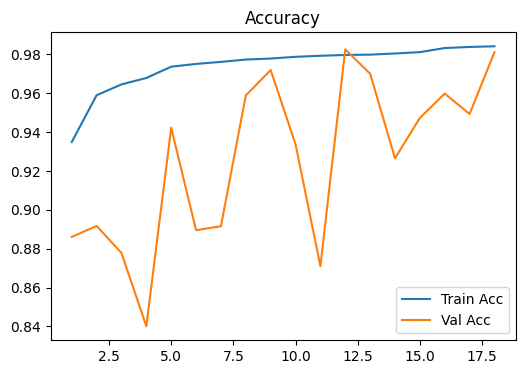

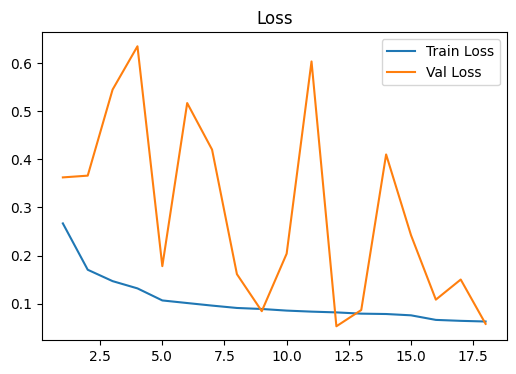

1406/1406 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step


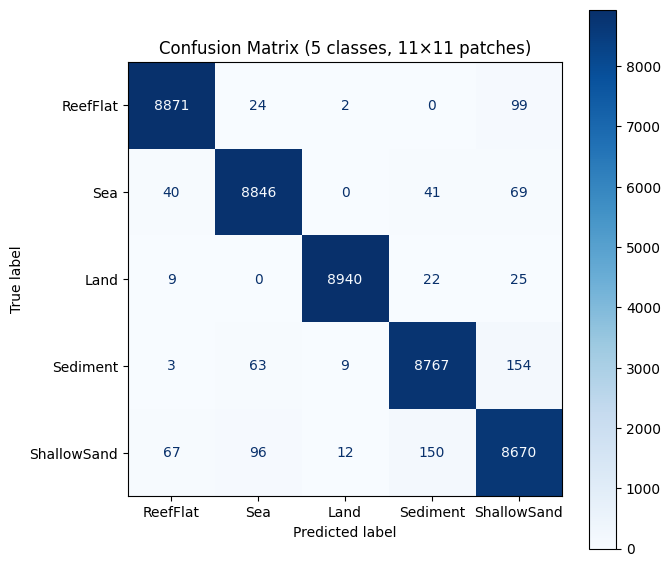

Saved model to: /content/drive/MyDrive/AI4EO/Final_Project/TrainedCNN/11x11_testrun_carbon/reef_cnn_11x11.h5


In [13]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight
import json
from codecarbon import EmissionsTracker

# ─── Paths ─────────────────────────────────────────────────────────────────────
TRAIN_DATA_DIR = '/content/drive/MyDrive/AI4EO/Final_Project/TrainingData/test_run'
CONFIG_PATH    = '/content/drive/MyDrive/AI4EO/Final_Project/config_reef.json'
MODEL_DIR      = '/content/drive/MyDrive/AI4EO/Final_Project/TrainedCNN/11x11_testrun_carbon'
os.makedirs(MODEL_DIR, exist_ok=True)

# ─── Hyperparameters ──────────────────────────────────────────────────────────
PATCH_SIZE       = 11
BATCH_SIZE       = 128
EPOCHS           = 50
VALIDATION_SPLIT = 0.1
PATIENCE_ES      = 6
PATIENCE_LR      = 3
MIN_LR           = 1e-6
INITIAL_LR       = 1e-3
EPS              = 1e-6

# ─── Load config for class names ───────────────────────────────────────────────
with open(CONFIG_PATH) as f:
    cfg = json.load(f)
classes     = cfg['classes']
num_classes = len(classes)
class_names = [c['name'] for c in classes]

# ─── Load 11×11 training data ──────────────────────────────────────────────────
X_train = np.load(os.path.join(TRAIN_DATA_DIR, f'X{PATCH_SIZE}_train.npy'))  # (N,11,11,4)
X_test  = np.load(os.path.join(TRAIN_DATA_DIR, f'X{PATCH_SIZE}_test.npy'))
y_train = np.load(os.path.join(TRAIN_DATA_DIR, 'y_train.npy'))
y_test  = np.load(os.path.join(TRAIN_DATA_DIR, 'y_test.npy'))

print(f"Data shapes: X_train={X_train.shape}, X_test={X_test.shape}, "
      f"y_train={y_train.shape}, y_test={y_test.shape}")

# ─── Append NDWI channel ──────────────────────────────────────────────────────
def append_ndwi(X):
    green = X[...,1].astype(float)
    nir   = X[...,3].astype(float)
    ndwi  = (green - nir) / (green + nir + EPS)
    return np.concatenate([X, ndwi[...,None]], axis=-1)

X_train = append_ndwi(X_train)  # now (N,11,11,5)
X_test  = append_ndwi(X_test)

# ─── Compute class weights (balance + extra penalty) ─────────────────────────
cw = class_weight.compute_class_weight('balanced',
                                       classes=np.arange(num_classes),
                                       y=y_train)
class_weight_dict = dict(enumerate(cw))

reef_i    = class_names.index('ReefFlat')
shallow_i = class_names.index('ShallowSand')
class_weight_dict[reef_i]    *= 2.0
class_weight_dict[shallow_i] *= 2.0

print("Class weight dict:", class_weight_dict)

# ─── Build the model ──────────────────────────────────────────────────────────
input_ch = X_train.shape[-1]  # 5
model = models.Sequential([
    # Block 1
    layers.Conv2D(32, (3,3), activation='relu', padding='same',
                  input_shape=(PATCH_SIZE, PATCH_SIZE, input_ch)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),  # 11→5

    # Block 2
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),

    # Classifier head
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

# ─── Callbacks ────────────────────────────────────────────────────────────────
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE_ES,
                                     restore_best_weights=True)
reduce_lr  = callbacks.ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.5,
                                         patience=PATIENCE_LR,
                                         min_lr=MIN_LR)

# ─── TRAIN with CodeCarbon ─────────────────────────────────────────────────────
tracker = EmissionsTracker(
    project_name="reef_training",
    output_dir="//content/drive/MyDrive/AI4EO/Final_Project/Emissions_Log"
)

# Start tracking just before the heavy compute
tracker.start()

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr]
)

# Stop tracking right after .fit() ends
tracker.stop()

# ─── Retrieve the EmissionsData object ────────────────────────────────────────
emissions_data = tracker.final_emissions_data

# Access attributes instead of indexing
print(f"\n▶ Training CO₂ emissions (kg):     {emissions_data.emissions:.5f}")
print(f"▶ Energy consumed (kWh):           {emissions_data.energy_consumed:.5f}")
print(f"▶ Average CPU power (W):           {emissions_data.cpu_power:.2f}")
print(f"▶ Average GPU power (W):           {getattr(emissions_data, 'gpu_power', 0.0):.2f}\n")

# ─── Plot training curves ──────────────────────────────────────────────────────
def plot_curves(h):
    epochs = range(1, len(h.history['loss']) + 1)
    plt.figure(figsize=(6,4))
    plt.plot(epochs, h.history['accuracy'],    label='Train Acc')
    plt.plot(epochs, h.history['val_accuracy'],label='Val Acc')
    plt.title('Accuracy'); plt.legend(); plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(epochs, h.history['loss'],    label='Train Loss')
    plt.plot(epochs, h.history['val_loss'],label='Val Loss')
    plt.title('Loss'); plt.legend(); plt.show()

plot_curves(history)

# ─── Evaluate & confusion matrix ───────────────────────────────────────────────
y_pred = np.argmax(model.predict(X_test), axis=1)
cm     = confusion_matrix(y_test, y_pred, labels=list(range(num_classes)))
disp   = ConfusionMatrixDisplay(cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(7,7))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title(f'Confusion Matrix ({num_classes} classes, {PATCH_SIZE}×{PATCH_SIZE} patches)')
plt.show()

# ─── Save the model ────────────────────────────────────────────────────────────
model_path = os.path.join(MODEL_DIR, f'reef_cnn_{PATCH_SIZE}x{PATCH_SIZE}.h5')
model.save(model_path)
print("Saved model to:", model_path)

# Rollout of our CNN

We now run inference on the full Sentinel-2 scene by sliding a non-overlapping 11×11 patch window across the image, appending NDWI to each patch, and predicting reef class probabilities. The output is upsampled to image resolution and filtered using an NDWI mask to isolate confident, shallow-water reef regions for visualisation.

### Training Tile

Running inference: 100%|██████████| 973/973 [06:12<00:00,  2.61it/s]


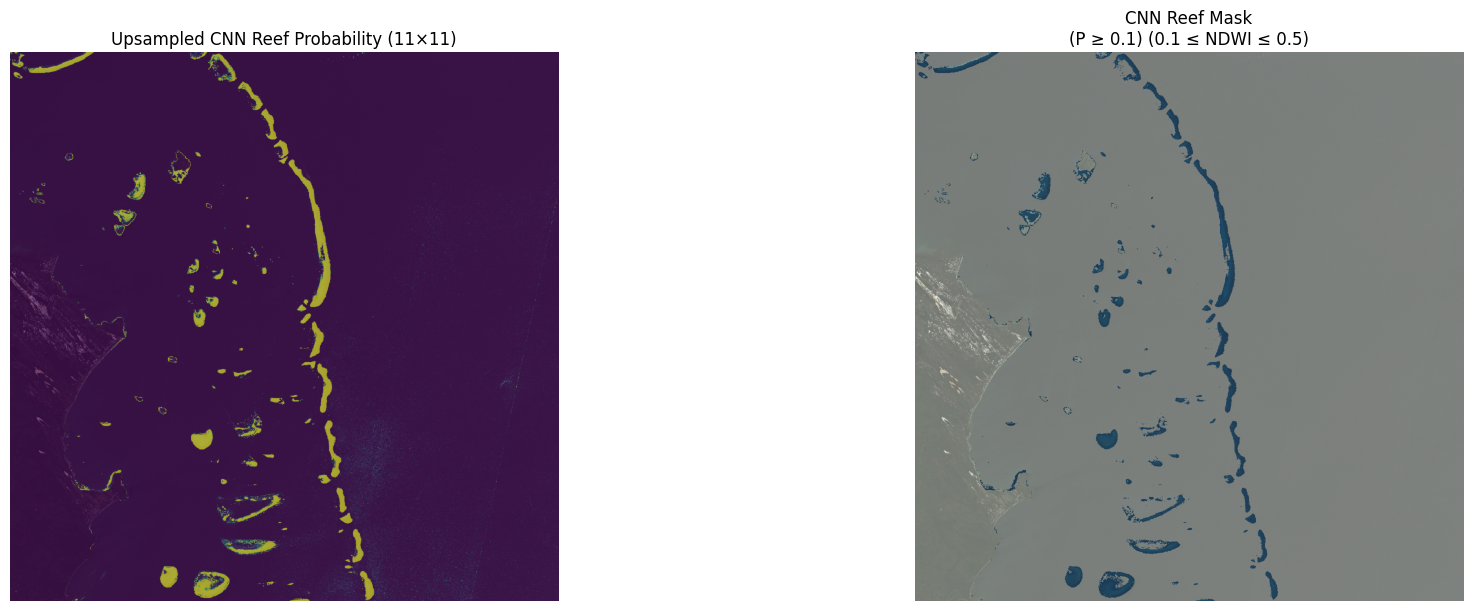

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tqdm import tqdm
import math

# ─── SETTINGS ─────────────────────────────────────────────────────────────
MODEL_PATH  = '/content/drive/MyDrive/AI4EO/Final_Project/TrainedCNN/11x11_testrun_carbon/reef_cnn_11x11.h5'
IMAGE_PATH  = '/content/drive/MyDrive/AI4EO/Final_Project/stacked_cube.npy'
PATCH_SIZE  = 11
BATCH_SIZE  = 1024   # how many patches to predict at once
P_THRESH    = 0.1
NDWI_MIN    = 0.1
NDWI_MAX    = 0.5
MAX_PREVIEW = 1024
EPS         = 1e-6

# ─── LOAD MODEL & IMAGE ─────────────────────────────────────────────────────
model = load_model(MODEL_PATH)
cube  = np.load(IMAGE_PATH)      # (H, W, 4)
H, W, _ = cube.shape

# ─── PRE-COMPUTE NDWI MAP ───────────────────────────────────────────────────
green    = cube[...,1].astype(np.float32)
nir      = cube[...,3].astype(np.float32)
ndwi_map = (green - nir) / (green + nir + EPS)

# ─── SET UP GRID OF NON-OVERLAPPING PATCH STARTS ────────────────────────────
ys = np.arange(0, H - PATCH_SIZE + 1, PATCH_SIZE)
xs = np.arange(0, W - PATCH_SIZE + 1, PATCH_SIZE)
h_s, w_s = len(ys), len(xs)
n_patches = h_s * w_s

n_batches = math.ceil(n_patches / BATCH_SIZE)
reef_prob_small = np.zeros((h_s, w_s), dtype=np.float32)

for batch_idx in tqdm(range(n_batches), desc="Running inference"):
    start = batch_idx * BATCH_SIZE
    end   = min(start + BATCH_SIZE, n_patches)
    batch_size = end - start

    # build your batch as before…
    batch = np.empty((batch_size, PATCH_SIZE, PATCH_SIZE, 5), dtype=np.float32)
    for i in range(batch_size):
        idx = start + i
        row, col = divmod(idx, w_s)
        y, x = ys[row], xs[col]
        p4 = cube[y:y+PATCH_SIZE, x:x+PATCH_SIZE, :].astype(np.float32)
        p_ndwi = ndwi_map[y:y+PATCH_SIZE, x:x+PATCH_SIZE][...,None]
        batch[i,:,:,:4] = p4
        batch[i,:,:,4]   = p_ndwi[...,0]

    # turn on Keras’s bar if you like (verbose=1), or keep verbose=0
    preds = model.predict(batch, batch_size=batch_size, verbose=0)
    reef_prob_small.flat[start:end] = preds[:, 0]

    del batch, preds

# ─── STREAMED INFERENCE ─────────────────────────────────────────────────────
reef_prob_small = np.zeros((h_s, w_s), dtype=np.float32)

for start in range(0, n_patches, BATCH_SIZE):
    end = min(start + BATCH_SIZE, n_patches)
    batch_size = end - start

    # allocate batch
    batch = np.empty((batch_size, PATCH_SIZE, PATCH_SIZE, 5), dtype=np.float32)

    for i in range(batch_size):
        idx = start + i
        row, col = divmod(idx, w_s)
        y, x = ys[row], xs[col]

        # load 4-band patch
        p4 = cube[y:y+PATCH_SIZE, x:x+PATCH_SIZE, :].astype(np.float32)
        # load ndwi patch
        p_ndwi = ndwi_map[y:y+PATCH_SIZE, x:x+PATCH_SIZE][..., None]

        batch[i, :, :, :4] = p4
        batch[i, :, :, 4]  = p_ndwi[..., 0]

    # predict and store only the “reef” class prob (class 0)
    preds = model.predict(batch, batch_size=batch_size, verbose=0)
    reef_prob_small.flat[start:end] = preds[:, 0]

    # free memory explicitly (optional)
    del batch, preds

# ─── UPSAMPLE TO FULL RESOLUTION ────────────────────────────────────────────
big_prob = np.kron(
    reef_prob_small.reshape(h_s, w_s),
    np.ones((PATCH_SIZE, PATCH_SIZE), dtype=np.float32)
)[:H, :W]

# ─── NDWI‐ONLY MASK ─────────────────────────────────────────────────────────
ndwi_mask = (ndwi_map >= NDWI_MIN) & (ndwi_map <= NDWI_MAX)

# ─── CROP TO MATCH big_prob’s SHAPE ─────────────────────────────────────────
h_bp, w_bp = big_prob.shape
ndwi_crop = ndwi_mask[:h_bp, :w_bp]

# ─── APPLY NDWI FILTER TO CNN PROBS ────────────────────────────────────────
final_cnn = (big_prob >= P_THRESH) & ndwi_crop

# ─── BUILD RGB BACKDROP ────────────────────────────────────────────────────
rgb = np.stack([
    (cube[...,2] - cube[...,2].min())/np.ptp(cube[...,2]),
    (cube[...,1] - cube[...,1].min())/np.ptp(cube[...,1]),
    (cube[...,0] - cube[...,0].min())/np.ptp(cube[...,0]),
], axis=-1)
rgb_crop = rgb[:H, :W]

# ─── LIGHTWEIGHT PLOTTING ─────────────────────────────────────────────────
scale = min(1.0, MAX_PREVIEW / max(H, W))
step  = max(1, int(1/scale))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), constrained_layout=True)

ax1.imshow(rgb_crop[::step,::step], vmin=0, vmax=1)
ax1.imshow(big_prob[::step,::step], cmap='viridis', alpha=0.6)
ax1.set_title("Upsampled CNN Reef Probability (11×11)")
ax1.axis('off')

ax2.imshow(rgb_crop[::step,::step], vmin=0, vmax=1)
ax2.imshow(final_cnn[::step,::step], cmap='GnBu', alpha=0.4)
ax2.set_title(f"CNN Reef Mask\n(P ≥ {P_THRESH}) ({NDWI_MIN} ≤ NDWI ≤ {NDWI_MAX})")
ax2.axis('off')

plt.show()

### Unseen Tile

Note here that regions affected by cloud have been removed from classification.

Running inference: 100%|██████████| 487/487 [03:05<00:00,  2.63it/s]


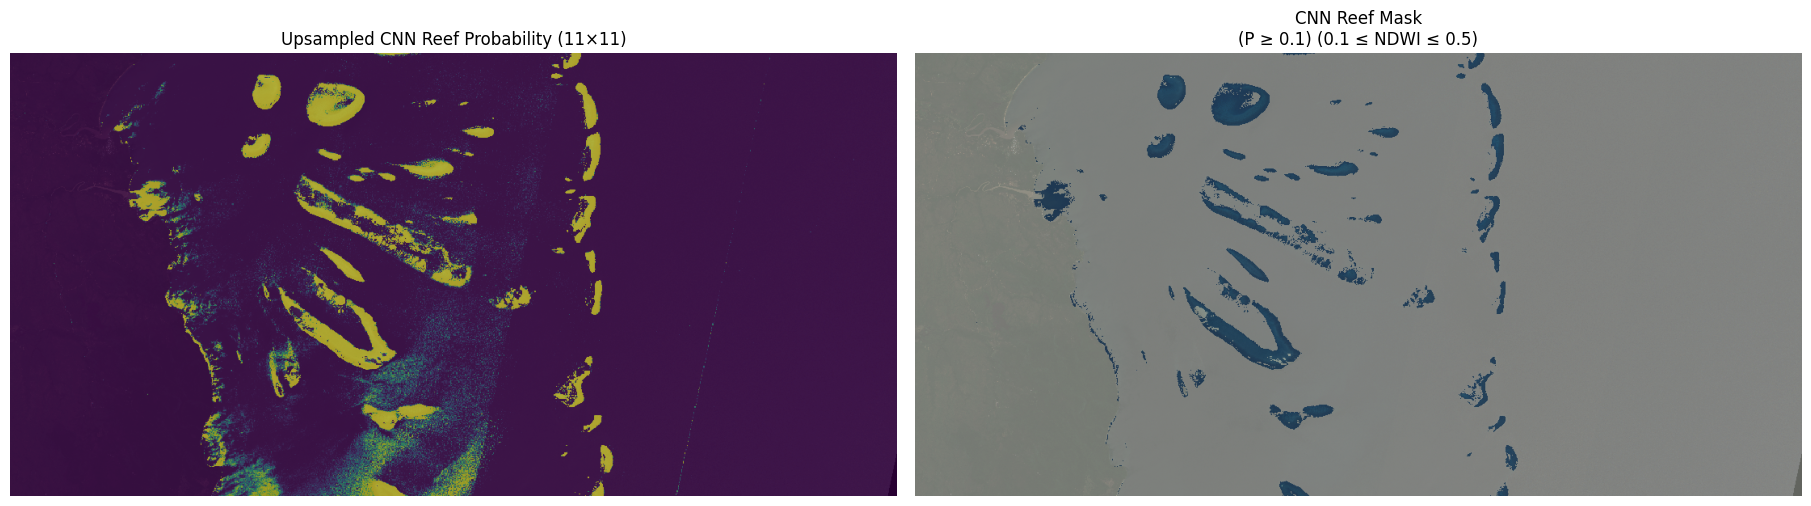

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tqdm import tqdm
import math

# ─── SETTINGS ─────────────────────────────────────────────────────────────
MODEL_PATH  = '/content/drive/MyDrive/AI4EO/Final_Project/TrainedCNN/11x11_testrun_carbon/reef_cnn_11x11.h5'
IMAGE_PATH  = '/content/drive/MyDrive/AI4EO/Final_Project/stacked_cube_gen.npy'
PATCH_SIZE  = 11
BATCH_SIZE  = 1024   # how many patches to predict at once
P_THRESH    = 0.1
NDWI_MIN    = 0.1
NDWI_MAX    = 0.5
MAX_PREVIEW = 1024
EPS         = 1e-6

# ─── LOAD & CROP IMAGE ──────────────────────────────────────────────────────
model = load_model(MODEL_PATH)
cube  = np.load(IMAGE_PATH)      # (H, W, 4)
H, W, _ = cube.shape

# drop bottom half (clouds/artifacts)
H2 = H // 2
cube = cube[:H2, :, :]
H, _, _ = cube.shape

# ─── PRE-COMPUTE NDWI MAP ───────────────────────────────────────────────────
green    = cube[...,1].astype(np.float32)
nir      = cube[...,3].astype(np.float32)
ndwi_map = (green - nir) / (green + nir + EPS)

# ─── SET UP GRID OF NON-OVERLAPPING PATCH STARTS ────────────────────────────
ys = np.arange(0, H - PATCH_SIZE + 1, PATCH_SIZE)
xs = np.arange(0, W - PATCH_SIZE + 1, PATCH_SIZE)
h_s, w_s = len(ys), len(xs)
n_patches = h_s * w_s

n_batches = math.ceil(n_patches / BATCH_SIZE)
reef_prob_small = np.zeros((h_s, w_s), dtype=np.float32)

for batch_idx in tqdm(range(n_batches), desc="Running inference"):
    start = batch_idx * BATCH_SIZE
    end   = min(start + BATCH_SIZE, n_patches)
    batch_size = end - start

    # build your batch as before…
    batch = np.empty((batch_size, PATCH_SIZE, PATCH_SIZE, 5), dtype=np.float32)
    for i in range(batch_size):
        idx = start + i
        row, col = divmod(idx, w_s)
        y, x = ys[row], xs[col]
        p4 = cube[y:y+PATCH_SIZE, x:x+PATCH_SIZE, :].astype(np.float32)
        p_ndwi = ndwi_map[y:y+PATCH_SIZE, x:x+PATCH_SIZE][...,None]
        batch[i,:,:,:4] = p4
        batch[i,:,:,4]   = p_ndwi[...,0]

    # turn on Keras’s bar if you like (verbose=1), or keep verbose=0
    preds = model.predict(batch, batch_size=batch_size, verbose=0)
    reef_prob_small.flat[start:end] = preds[:, 0]

    del batch, preds

# ─── STREAMED INFERENCE ─────────────────────────────────────────────────────
reef_prob_small = np.zeros((h_s, w_s), dtype=np.float32)

for start in range(0, n_patches, BATCH_SIZE):
    end = min(start + BATCH_SIZE, n_patches)
    batch_size = end - start

    # allocate batch
    batch = np.empty((batch_size, PATCH_SIZE, PATCH_SIZE, 5), dtype=np.float32)

    for i in range(batch_size):
        idx = start + i
        row, col = divmod(idx, w_s)
        y, x = ys[row], xs[col]

        # load 4-band patch
        p4 = cube[y:y+PATCH_SIZE, x:x+PATCH_SIZE, :].astype(np.float32)
        # load ndwi patch
        p_ndwi = ndwi_map[y:y+PATCH_SIZE, x:x+PATCH_SIZE][..., None]

        batch[i, :, :, :4] = p4
        batch[i, :, :, 4]  = p_ndwi[..., 0]

    # predict and store only the “reef” class prob (class 0)
    preds = model.predict(batch, batch_size=batch_size, verbose=0)
    reef_prob_small.flat[start:end] = preds[:, 0]

    # free memory explicitly (optional)
    del batch, preds

# ─── UPSAMPLE TO FULL RESOLUTION ────────────────────────────────────────────
big_prob = np.kron(
    reef_prob_small.reshape(h_s, w_s),
    np.ones((PATCH_SIZE, PATCH_SIZE), dtype=np.float32)
)[:H, :W]

# ─── NDWI‐ONLY MASK ─────────────────────────────────────────────────────────
ndwi_mask = (ndwi_map >= NDWI_MIN) & (ndwi_map <= NDWI_MAX)

# ─── CROP TO MATCH big_prob’s SHAPE ─────────────────────────────────────────
h_bp, w_bp = big_prob.shape
ndwi_crop = ndwi_mask[:h_bp, :w_bp]

# ─── APPLY NDWI FILTER TO CNN PROBS ────────────────────────────────────────
final_cnn = (big_prob >= P_THRESH) & ndwi_crop

# ─── BUILD RGB BACKDROP ────────────────────────────────────────────────────
rgb = np.stack([
    (cube[...,2] - cube[...,2].min())/np.ptp(cube[...,2]),
    (cube[...,1] - cube[...,1].min())/np.ptp(cube[...,1]),
    (cube[...,0] - cube[...,0].min())/np.ptp(cube[...,0]),
], axis=-1)
rgb_crop = rgb[:H, :W]

# ─── LIGHTWEIGHT PLOTTING ─────────────────────────────────────────────────
scale = min(1.0, MAX_PREVIEW / max(H, W))
step  = max(1, int(1/scale))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), constrained_layout=True)

ax1.imshow(rgb_crop[::step,::step], vmin=0, vmax=1)
ax1.imshow(big_prob[::step,::step], cmap='viridis', alpha=0.6)
ax1.set_title("Upsampled CNN Reef Probability (11×11)")
ax1.axis('off')

ax2.imshow(rgb_crop[::step,::step], vmin=0, vmax=1)
ax2.imshow(final_cnn[::step,::step], cmap='GnBu', alpha=0.4)
ax2.set_title(f"CNN Reef Mask\n(P ≥ {P_THRESH}) ({NDWI_MIN} ≤ NDWI ≤ {NDWI_MAX})")
ax2.axis('off')

plt.show()

# Extracting Ground Truth from the ACA

To create a ground truth mask for evaluation, we extract and rasterize selected geomorphic classes from a vector shapefile of the reef system (focusing on reef flats and lagoons) and align them spatially using the metadata (CRS, dimensions, transform) from a reference Sentinel-2 .jp2 image, downloaded earlier in the notebook.

The shapefile is sourced from the Allen Coral Atlas (ACA), a high-quality open-access platform providing detailed geomorphic reef classifications. While the data is free to use for research, creating an ACA account is required to access and download the shapefiles.

The resulting binary masks are cropped and saved as .npy arrays for efficient integration into our model validation workflow.

In [4]:
import os
import fiona
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
import numpy as np

# ─── CONFIG ────────────────────────────────────────────────────────────────
GPKG_PATH = '/content/drive/MyDrive/AI4EO/Final_Project/Great-Barrier-Reef-and-Torres-Strait-20230310013521/Geomorphic-Map/geomorphic.gpkg'

# list of (reference JP2, output .npy, crop_bottom_half)
mask_jobs = [
    (
        '/content/drive/MyDrive/AI4EO/Final_Project/T55LCD_20190211T003709_B03_10m.jp2',
        '/content/drive/MyDrive/AI4EO/Final_Project/reef_aca_mask_full.npy',
        False
    ),
    (
        '/content/drive/MyDrive/AI4EO/Final_Project/T55LCC_20190211T003709_B03_10m.jp2',
        '/content/drive/MyDrive/AI4EO/Final_Project/reef_aca_mask_cropped.npy',
        True
    )
]

# ─── 1) Load entire Geomorphic vector once ─────────────────────────────────
layers = fiona.listlayers(GPKG_PATH)
reef_gdf = gpd.read_file(GPKG_PATH, layer=layers[0])
print(f"Loaded {len(reef_gdf)} features from layer '{layers[0]}'")

#  ─── 1a) Inspect unique classes (already known, but good to confirm) ───────
unique_classes = reef_gdf['class'].dropna().unique()
print("All available classes in 'class' column:")
for uc in unique_classes:
    print(f"  • {uc!r}")

# ─── 1b) Define which classes to keep (Reef Flat Class) ─────────────────
keep_classes = [
    'Reef Crest',
    'Outer Reef Flat',
    'Inner Reef Flat',
    'Terrestrial Reef Flat',
    'Plateau',
    'Deep Lagoon',
    'Shallow Lagoon'
]

print("\nFiltering to keep only these classes:")
for kc in keep_classes:
    print(f"  • {kc!r}")

# Filter the GeoDataFrame
filtered_gdf = reef_gdf[reef_gdf['class'].isin(keep_classes)].copy()
print(f"\nAfter filtering, {len(filtered_gdf)} features remain (out of {len(reef_gdf)})")

# ─── 2) Loop over each mask job and rasterize only filtered classes ────────
for jp2_path, out_npy, crop_half in mask_jobs:
    # Open JP2 to get CRS, transform & dimensions
    with rasterio.open(jp2_path) as src:
        transform = src.transform
        height, width = src.height, src.width
        dst_crs = src.crs

    # Reproject filtered vector if needed
    if filtered_gdf.crs != dst_crs:
        filtered_gdf = filtered_gdf.to_crs(dst_crs)

    # Prepare shapes iterable: each (geometry, 1) for the filtered classes
    shapes = ((geom, 1) for geom in filtered_gdf.geometry)

    # Rasterize: pixels inside any filtered polygon → 1; else 0
    mask_full = rasterize(
        shapes=shapes,
        out_shape=(height, width),
        transform=transform,
        fill=0,
        dtype=np.uint8
    )

    # Crop bottom half if requested
    if crop_half:
        mask = mask_full[: (height // 2), :]
    else:
        mask = mask_full

    # Save to .npy
    os.makedirs(os.path.dirname(out_npy), exist_ok=True)
    np.save(out_npy, mask)
    print(f"→ Saved filtered‐classes mask to {out_npy}, shape = {mask.shape}")

Loaded 441627 features from layer 'Great Barrier Reef and Torres Strait'
All available classes in 'class' column:
  • 'Back Reef Slope'
  • 'Reef Slope'
  • 'Reef Crest'
  • 'Outer Reef Flat'
  • 'Sheltered Reef Slope'
  • 'Deep Lagoon'
  • 'Shallow Lagoon'
  • 'Inner Reef Flat'
  • 'Plateau'
  • 'Terrestrial Reef Flat'

Filtering to keep only these classes:
  • 'Reef Crest'
  • 'Outer Reef Flat'
  • 'Inner Reef Flat'
  • 'Terrestrial Reef Flat'
  • 'Plateau'
  • 'Deep Lagoon'
  • 'Shallow Lagoon'

After filtering, 235795 features remain (out of 441627)
→ Saved filtered‐classes mask to /content/drive/MyDrive/AI4EO/Final_Project/reef_aca_mask_full.npy, shape = (10980, 10980)
→ Saved filtered‐classes mask to /content/drive/MyDrive/AI4EO/Final_Project/reef_aca_mask_cropped.npy, shape = (5490, 10980)


# Model Evaluation

We evaluate the performance of our CNN reef classifier by comparing its predictions for the unseen region to a ground truth mask from the ACA. Patch-wise reef probabilities are upsampled, thresholded, and aligned with the ACA mask to compute a confusion matrix, classification report. We also provide visual overlays highlighting true positives (green), false positives (blue), and false negatives (red).

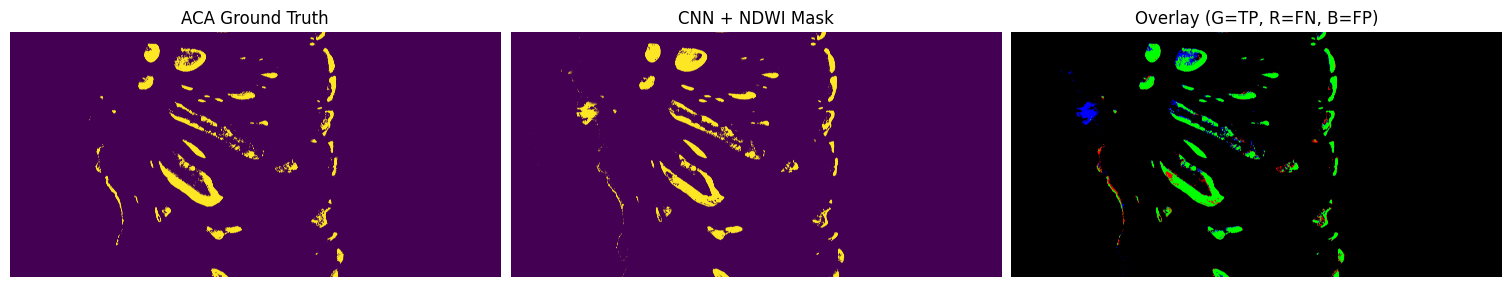

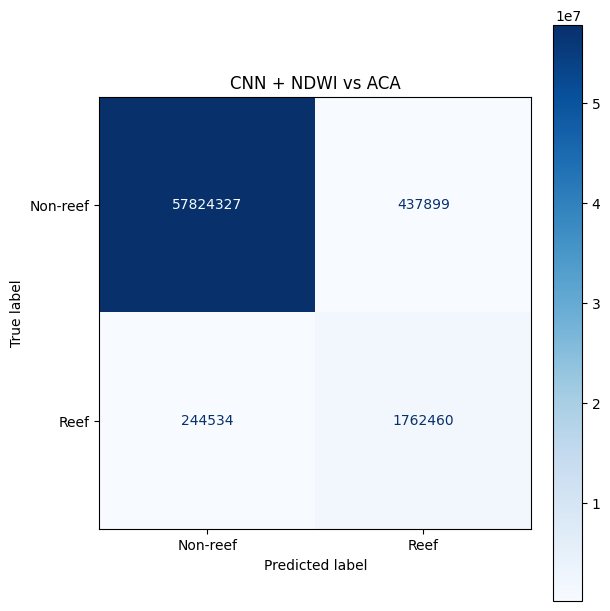

=== Classification Report ===

              precision    recall  f1-score   support

    Non-reef       1.00      0.99      0.99  58262226
        Reef       0.80      0.88      0.84   2006994

    accuracy                           0.99  60269220
   macro avg       0.90      0.94      0.92  60269220
weighted avg       0.99      0.99      0.99  60269220



In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# ─── Helper to load your CNN (Keras or ONNX) ───────────────────────────────
def load_cnn_model(path):
    try:
        from tensorflow.keras.models import load_model
        return load_model(path)
    except:
        try:
            from keras.models import load_model
            return load_model(path)
        except:
            import onnxruntime as ort
            sess = ort.InferenceSession(path)
            # assume the ONNX model expects 'input' as the input name
            return lambda x, **kwargs: sess.run(None, {'input': x})[0]

# ─── Paths & settings ─────────────────────────────────────────────────────
CUBE_PATH   = '/content/drive/MyDrive/AI4EO/Final_Project/stacked_cube_gen.npy'
ACA_MASK    = '/content/drive/MyDrive/AI4EO/Final_Project/reef_aca_mask_cropped.npy'
MODEL_PATH  = '/content/drive/MyDrive/AI4EO/Final_Project/TrainedCNN/11x11_testrun/reef_cnn_11x11.h5'

PATCH       = 11        # patch height & width
NDWI_MIN    = 0.1       # shallow‐water lower bound
P_THRESH    = 0.1       # probability threshold for “reef”
EPS         = 1e-6
BATCH_SIZE  = 1024      # how many patches to process at once (tune this to fit RAM)

# ─── 1) Load data & compute NDWI map ──────────────────────────────────────
cube      = np.load(CUBE_PATH)                 # shape = (H, W, 4)
aca_mask  = np.load(ACA_MASK).astype(bool)     # shape = (H₂, W₂)
H, W, _   = cube.shape

# compute NDWI map once (float32)
green     = cube[...,1].astype(np.float32)
nir       = cube[...,3].astype(np.float32)
ndwi_map  = (green - nir) / (green + nir + EPS)

# shallow‐water boolean mask (H×W)
shallow_mask = (ndwi_map >= NDWI_MIN)

# ─── 2) Prepare “grid” of non‐overlapping PATCH blocks ────────────────────
ys = np.arange(0, H - PATCH + 1, PATCH)
xs = np.arange(0, W - PATCH + 1, PATCH)
h_s, w_s = len(ys), len(xs)
n_patches = h_s * w_s

# Placeholder for patch‐level probabilities (coarse grid)
reef_prob_small = np.zeros((h_s, w_s), dtype=np.float32)

# ─── 3) CNN inference in batches (no giant pts array) ────────────────────
model = load_cnn_model(MODEL_PATH)

# We’ll iterate over all patch indices [0 .. n_patches-1], in chunks of BATCH_SIZE
for start in range(0, n_patches, BATCH_SIZE):
    end = min(start + BATCH_SIZE, n_patches)
    batch_size = end - start

    # Allocate a single batch array of shape (batch_size, PATCH, PATCH, 5)
    batch = np.zeros((batch_size, PATCH, PATCH, 5), dtype=np.float32)

    # Fill in the batch with (4 RGB+NIR bands) + (1 NDWI channel)
    for i in range(batch_size):
        idx = start + i
        row, col = divmod(idx, w_s)
        y, x = ys[row], xs[col]

        # 4‐band slice
        patch_4 = cube[y:y+PATCH, x:x+PATCH, :].astype(np.float32)  # shape = (PATCH, PATCH, 4)
        # NDWI slice
        patch_ndwi = ndwi_map[y:y+PATCH, x:x+PATCH].astype(np.float32)  # shape = (PATCH, PATCH)

        batch[i, :, :, :4] = patch_4
        batch[i, :, :, 4]  = patch_ndwi

    # Run inference on this batch; preds[:,0] is probability of “reef”
    preds = model.predict(batch, batch_size=batch_size, verbose=0)  # shape = (batch_size, 1) or (batch_size, 2)
    reef_prob_small.flat[start:end] = preds[:, 0].astype(np.float32)

    # Free the batch & preds right away
    del batch, preds

# ─── 4) Upsample patch‐level probs to full H×W “big_prob” ─────────────────
big_prob = np.kron(
    reef_prob_small,
    np.ones((PATCH, PATCH), dtype=np.float32)
)
# If H or W aren’t exact multiples of PATCH, crop down to exactly (H, W)
big_prob = big_prob[:H, :W]

# ─── 5) Gate by NDWI (≥ NDWI_MIN) and by probability threshold ───────────
# Crop shallow_mask to match big_prob’s shape, NOT to (H, W)
shallow_crop = shallow_mask[:big_prob.shape[0], :big_prob.shape[1]]  # <--- here
final_cnn    = (big_prob >= P_THRESH) & shallow_crop

# ─── 6) Crop both prediction & ACA mask to a common footprint ────────────
common_h = min(final_cnn.shape[0], aca_mask.shape[0])
common_w = min(final_cnn.shape[1], aca_mask.shape[1])

gt   = aca_mask[:common_h, :common_w]
pred = final_cnn[:common_h, :common_w]

# ─── 7) Visualize: ACA GT vs. CNN+NDWI vs. overlay ────────────────────────
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

ax1.imshow(gt,   cmap='viridis')
ax1.set_title('ACA Ground Truth')
ax1.axis('off')

ax2.imshow(pred, cmap='viridis')
ax2.set_title('CNN + NDWI Mask')
ax2.axis('off')

# Build an RGB overlay: G = True Positive, R = False Negative, B = False Positive
overlay = np.zeros((common_h, common_w, 3), dtype=np.float32)
overlay[(gt & pred), 1]  = 1.0   # True Positives → green
overlay[(gt & ~pred), 0] = 1.0   # False Negatives → red
overlay[(~gt & pred), 2] = 1.0   # False Positives → blue

ax3.imshow(overlay)
ax3.set_title('Overlay (G=TP, R=FN, B=FP)')
ax3.axis('off')

plt.show()

# ─── 8) Plot confusion matrix and classification report ────────────────
y_true = gt.ravel().astype(int)
y_pred = pred.ravel().astype(int)

cm      = confusion_matrix(y_true, y_pred, labels=[0,1])
disp    = ConfusionMatrixDisplay(cm, display_labels=['Non-reef','Reef'])

fig, ax = plt.subplots(figsize=(6, 6), constrained_layout=True)
disp.plot(ax=ax, cmap='Blues', values_format='d')
ax.set_title('CNN + NDWI vs ACA')
plt.show()

print("=== Classification Report ===\n")
print(classification_report(
    y_true, y_pred, target_names=['Non-reef','Reef']
))

# Conclusions

The results from the confusion matrix show that our NDWI + CNN workflow performs strongly overall, achieving an accuracy of 99% across over 60 million pixels, with an F1-score of 0.84 for the reef class. This performance reflects a complementary relationship between the two components: the NDWI mask effectively removes deep water and terrestrial regions that often confuse the CNN, while the CNN provides spatial and spectral nuance that NDWI alone lacks—particularly in distinguishing reef structures from similarly reflective features like sediment and turbid sand.

To illustrate this, we plot our NDWI mask with our ACA overlayed, and do the same with our CNN classification. See below:

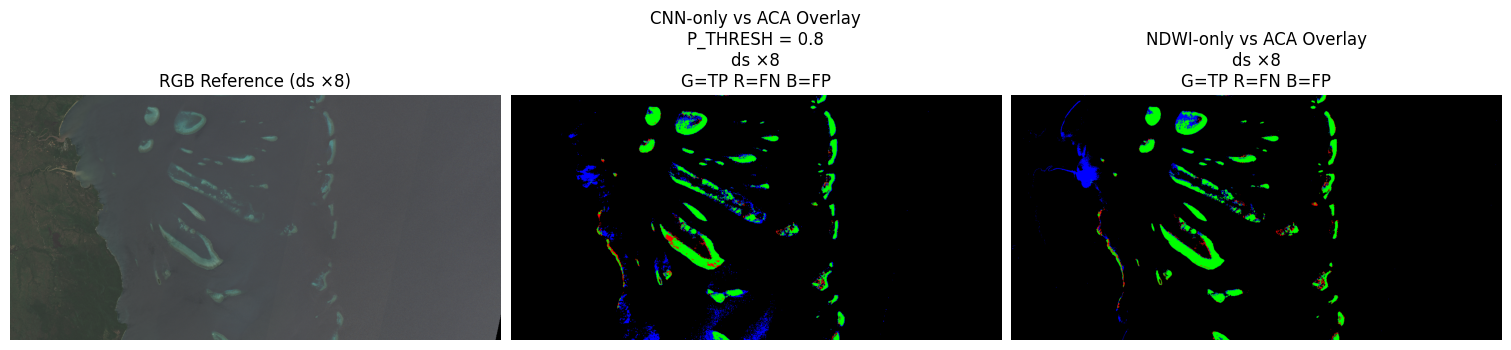

In [4]:
# ─── Downsample factor ───────────────────────────────────────────────────────
factor = 8  # keep every 4th pixel (adjust as needed)

# ─── Adjustable probability threshold for CNN ─────────────────────────────────
P_THRESH = 0.8  # adjust this value as needed

# ─── 1) Prepare RGB reference (crop + downsample) ────────────────────────────
# Assumes cube has shape (H, W, 4) with bands [Blue, Green, Red, NIR].
rgb_full = cube[..., :3]  # [Blue, Green, Red]
# Permute to [R, G, B] for display
rgb_display = np.stack([rgb_full[..., 2], rgb_full[..., 1], rgb_full[..., 0]], axis=-1)
rgb_ref = rgb_display[:common_h, :common_w]  # (common_h, common_w, 3)

# Downsample by slicing every 'factor' pixels
rgb_ref_ds = rgb_ref[::factor, ::factor]
# Normalize for display
rgb_ref_ds = rgb_ref_ds / np.max(rgb_ref_ds)

# ─── 2) CNN-only classification (threshold big_prob → crop + downsample) ─────
cnn_only_pred_full = (big_prob >= P_THRESH)  # boolean array (H, W)
cnn_only_pred = cnn_only_pred_full[:common_h, :common_w]  # (common_h, common_w)
cnn_ds = cnn_only_pred[::factor, ::factor]  # (h_ds, w_ds)

# ─── 3) NDWI-only classification (crop + downsample) ──────────────────────────
ndwi_pred_full = shallow_mask  # boolean array (H, W)
ndwi_only_pred = ndwi_pred_full[:common_h, :common_w]  # (common_h, common_w)
ndwi_ds = ndwi_only_pred[::factor, ::factor]  # (h_ds, w_ds)

# ─── 4) Downsample GT mask ────────────────────────────────────────────────────
gt_ds = gt[:common_h, :common_w][::factor, ::factor]  # ground truth (h_ds, w_ds)

# ─── 5) Build TP / FN / FP overlay for CNN-only vs. ACA (downsampled) ─────────
h_ds, w_ds = gt_ds.shape
overlay_cnn_ds = np.zeros((h_ds, w_ds, 3), dtype=np.float32)
# True Positives (CNN & GT) → green
overlay_cnn_ds[(gt_ds & cnn_ds), 1] = 1.0
# False Negatives (GT=1 & CNN=0) → red
overlay_cnn_ds[(gt_ds & ~cnn_ds), 0] = 1.0
# False Positives (CNN=1 & GT=0) → blue
overlay_cnn_ds[(~gt_ds & cnn_ds), 2] = 1.0

# ─── 6) Build TP / FN / FP overlay for NDWI-only vs. ACA (downsampled) ───────
overlay_ndwi_ds = np.zeros((h_ds, w_ds, 3), dtype=np.float32)
# True Positives (NDWI & GT) → green
overlay_ndwi_ds[(gt_ds & ndwi_ds), 1] = 1.0
# False Negatives (GT=1 & NDWI=0) → red
overlay_ndwi_ds[(gt_ds & ~ndwi_ds), 0] = 1.0
# False Positives (NDWI=1 & GT=0) → blue
overlay_ndwi_ds[(~gt_ds & ndwi_ds), 2] = 1.0

# ─── 7) Plot: downsampled RGB, CNN vs ACA overlay, and NDWI vs ACA overlay ────
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

# RGB reference
ax1.imshow(rgb_ref_ds)
ax1.set_title(f'RGB Reference (ds ×{factor})')
ax1.axis('off')

# CNN vs ACA overlay
ax2.imshow(overlay_cnn_ds)
ax2.set_title(f'CNN-only vs ACA Overlay\nP_THRESH = {P_THRESH}\nds ×{factor}\nG=TP R=FN B=FP')
ax2.axis('off')

# NDWI vs ACA overlay
ax3.imshow(overlay_ndwi_ds)
ax3.set_title(f'NDWI-only vs ACA Overlay\nds ×{factor}\nG=TP R=FN B=FP')
ax3.axis('off')

plt.show()

We can see that our CNN better at disregarding reflective features like sediment (inspect the top left of our images, where we see runoff from a river into the ocean). However it struggles with deeper waters (see the bottom middle section of our CNN overlay), where the NDWI mask is more effective. This highlights the benefits of such a dual classification, if training time or compute is of concern.  

The CNN tends to be inclusive, capturing the majority of reef pixels (recall = 0.88), though it remains more selective than a purely NDWI-based classification. It recovers most reef pixels (recall 0.88) at the cost of some false positives (precision 0.80). For monitoring, this bias is preferable; missed reefs are harder to correct than over-segmentation, and residual false positives can be pruned in post-processing.

Furthermore, this model was trained specifically on labelled data from the Great Barrier Reef, and further work is needed to assess generalisation to other reef systems. In particular, expanding the training dataset and using CNN architectures that incorporate larger spatial context (beyond the current 11×11 patch size) could improve the model’s ability to resolve more complex geomorphic transitions.

It is also worth noting that the ACA classifies reef geomorphology using Random Forest classifiers trained on multi-source remote sensing data, as well as extensive post-processing, including manual correction by regional experts. While that approach leverages extensive feature engineering, our end-to-end CNN + NDWI pipeline offers a lightweight and scalable alternative, serving as a proof of concept for real-time or large-scale reef classification using publicly available imagery and minimal preprocessing.

# Environmental Cost of Training

Given the rising energy demands of machine learning workflows, it's important to quantify their environmental footprint, especially in research projects where scalability and cloud computing are involved.

In the cell below, we estimate the environmental impact of training our model using CodeCarbon. Since Google Colab runs in a cloud environment, the library’s automatic location detection may be inaccurate. To address this, we manually calculate emissions using the average CO₂ output per kilowatt-hour (kWh) for the UK.
If you're based in a different region, simply adjust this value to reflect your local energy mix.

In [16]:
import pandas as pd

csv_path = "/content/drive/MyDrive/AI4EO/Final_Project/Emissions_Log/emissions.csv"
df = pd.read_csv(csv_path)

# 3. Display available columns
print("Available columns in CSV:")
print(df.columns.tolist(), "\n")

# 4. Identify energy column and compute carbon assuming UK grid (0.2 kg CO₂/kWh)
energy_col = "energy_consumed"  # adjust if different
carbon_intensity = 0.20         # kg CO₂ per kWh (UK average)

df["carbon_kg"] = df[energy_col] * carbon_intensity

# 5. Show per-run emissions and total summary
result = df[["timestamp", energy_col, "carbon_kg"]]
print("Computed per-run carbon emissions (kg CO₂):")
display(result)

total_energy = df[energy_col].sum()
total_carbon = df["carbon_kg"].sum()
print(f"\nTotal energy consumed across all runs: {total_energy:.5f} kWh")
print(f"Total carbon emissions (UK assumed):   {total_carbon:.5f} kg CO₂")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Available columns in CSV:
['timestamp', 'project_name', 'run_id', 'experiment_id', 'duration', 'emissions', 'emissions_rate', 'cpu_power', 'gpu_power', 'ram_power', 'cpu_energy', 'gpu_energy', 'ram_energy', 'energy_consumed', 'country_name', 'country_iso_code', 'region', 'cloud_provider', 'cloud_region', 'os', 'python_version', 'codecarbon_version', 'cpu_count', 'cpu_model', 'gpu_count', 'gpu_model', 'longitude', 'latitude', 'ram_total_size', 'tracking_mode', 'on_cloud', 'pue'] 

Computed per-run carbon emissions (kg CO₂):


timestamp  energy_consumed  carbon_kg
0  2025-06-01T22:08:45         0.090681   0.018136


Total energy consumed across all runs: 0.09068 kWh
Total carbon emissions (UK assumed):   0.01814 kg CO₂


To contextualize this value, 0.018 kg of CO₂ is roughly equivalent to running a 60W incandescent bulb for 12–15 minutes, or charging a smartphone once.

These emissions are remarkably low thanks to the lightweight CNN architecture, minimal training iterations, and use of freely available public satellite imagery. This reinforces the feasibility of deploying similar models in large-scale or low-resource settings with minimal environmental impact.

This estimate captures the compute-related emissions of model training only, using a single CNN training run on Google Colab. Preprocessing, data transfers, and storage-related emissions are not included, but are assumed to be negligible in comparison.
